# Miller age

In [1]:
ood_seed = 6

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_continuous"] = adata.obs["age"].astype(float)
d = {i: ind for ind, i in enumerate(sorted(adata.obs["age"].astype(float).unique()))}
adata.obs["age_training"] = [d[float(i)] for i in adata.obs["age"]]

df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [6]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
2             18.0    3005
1             15.0    2924
3             21.0     769
0             11.5     707
dtype: int64

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables

[(('Bud tip adjacent cells', '11.5'), 169),
 (('Bud tip adjacent cells', '15.0'), 282),
 (('Bud tip adjacent cells', '18.0'), 777),
 (('Bud tip progenitor', '11.5'), 273),
 (('Bud tip progenitor', '15.0'), 338),
 (('Bud tip progenitor', '18.0'), 683),
 (('Hub cells', '11.5'), 218),
 (('Hub cells', '15.0'), 308),
 (('Hub cells', '18.0'), 620),
 (('Lung ciliated cells', '15.0'), 692),
 (('Lung ciliated cells', '18.0'), 494),
 (('Lung ciliated cells', '21.0'), 165),
 (('Lung secretory cells', '15.0'), 595),
 (('Lung secretory cells', '21.0'), 438),
 (('Submucosal gland cells', '15.0'), 380),
 (('Submucosal gland cells', '18.0'), 156)]

In [9]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Hub cells', '11.5'), 218)

Removed datapoint: 218


In [10]:
adata

AnnData object with n_obs × n_vars = 7187 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous', 'age_training'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_ood_cont_expression-seed-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [14]:
warmup_epoch_range = [6, 48]

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = "age_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]


In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)), 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: qfqy41ab
Name: dark-rancor-351
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/qfqy41ab
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_021115-qfqy41ab/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_training` for `training` set. Number of elements in each group: 386,2351,2395,618
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 237,149,548,235,1568,1486,909,618
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_training` for `validation` set. Number of elements in each group: 103,573,610,151
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `validation` set. Number of elements in each group: 62,41,135,71,367,380,230,151
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:04<48:10,  4.83s/it]

Epoch 1/600:   0%|          | 1/600 [00:04<48:10,  4.83s/it, v_num=ab_1, total_loss_train=1.2e+3, kl_local_train=13.3, tardis_age_training_0_train=70.4, tardis_integration_donor_0_train=30.8]

Epoch 2/600:   0%|          | 1/600 [00:04<48:10,  4.83s/it, v_num=ab_1, total_loss_train=1.2e+3, kl_local_train=13.3, tardis_age_training_0_train=70.4, tardis_integration_donor_0_train=30.8]

Epoch 2/600:   0%|          | 2/600 [00:09<46:02,  4.62s/it, v_num=ab_1, total_loss_train=1.2e+3, kl_local_train=13.3, tardis_age_training_0_train=70.4, tardis_integration_donor_0_train=30.8]

Epoch 2/600:   0%|          | 2/600 [00:09<46:02,  4.62s/it, v_num=ab_1, total_loss_train=1.05e+3, kl_local_train=34.3, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.3]

Epoch 3/600:   0%|          | 2/600 [00:09<46:02,  4.62s/it, v_num=ab_1, total_loss_train=1.05e+3, kl_local_train=34.3, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.3]

Epoch 3/600:   0%|          | 3/600 [00:13<45:35,  4.58s/it, v_num=ab_1, total_loss_train=1.05e+3, kl_local_train=34.3, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.3]

Epoch 3/600:   0%|          | 3/600 [00:13<45:35,  4.58s/it, v_num=ab_1, total_loss_train=1e+3, kl_local_train=39.8, tardis_age_training_0_train=63.1, tardis_integration_donor_0_train=29.9]   

Epoch 4/600:   0%|          | 3/600 [00:13<45:35,  4.58s/it, v_num=ab_1, total_loss_train=1e+3, kl_local_train=39.8, tardis_age_training_0_train=63.1, tardis_integration_donor_0_train=29.9]

Epoch 4/600:   1%|          | 4/600 [00:18<44:49,  4.51s/it, v_num=ab_1, total_loss_train=1e+3, kl_local_train=39.8, tardis_age_training_0_train=63.1, tardis_integration_donor_0_train=29.9]

Epoch 4/600:   1%|          | 4/600 [00:18<44:49,  4.51s/it, v_num=ab_1, total_loss_train=971, kl_local_train=47.6, tardis_age_training_0_train=65.9, tardis_integration_donor_0_train=28.9] 

Epoch 5/600:   1%|          | 4/600 [00:18<44:49,  4.51s/it, v_num=ab_1, total_loss_train=971, kl_local_train=47.6, tardis_age_training_0_train=65.9, tardis_integration_donor_0_train=28.9]

Epoch 5/600:   1%|          | 5/600 [00:22<44:56,  4.53s/it, v_num=ab_1, total_loss_train=971, kl_local_train=47.6, tardis_age_training_0_train=65.9, tardis_integration_donor_0_train=28.9]

Epoch 5/600:   1%|          | 5/600 [00:22<44:56,  4.53s/it, v_num=ab_1, total_loss_train=942, kl_local_train=52.6, tardis_age_training_0_train=66, tardis_integration_donor_0_train=30.1]  

Epoch 6/600:   1%|          | 5/600 [00:22<44:56,  4.53s/it, v_num=ab_1, total_loss_train=942, kl_local_train=52.6, tardis_age_training_0_train=66, tardis_integration_donor_0_train=30.1]

Epoch 6/600:   1%|          | 6/600 [00:27<44:21,  4.48s/it, v_num=ab_1, total_loss_train=942, kl_local_train=52.6, tardis_age_training_0_train=66, tardis_integration_donor_0_train=30.1]

Epoch 6/600:   1%|          | 6/600 [00:27<44:21,  4.48s/it, v_num=ab_1, total_loss_train=924, kl_local_train=53.4, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.8]

Epoch 7/600:   1%|          | 6/600 [00:27<44:21,  4.48s/it, v_num=ab_1, total_loss_train=924, kl_local_train=53.4, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.8]

Epoch 7/600:   1%|          | 7/600 [00:31<44:00,  4.45s/it, v_num=ab_1, total_loss_train=924, kl_local_train=53.4, tardis_age_training_0_train=65.8, tardis_integration_donor_0_train=31.8]

Epoch 7/600:   1%|          | 7/600 [00:31<44:00,  4.45s/it, v_num=ab_1, total_loss_train=910, kl_local_train=51.3, tardis_age_training_0_train=70.2, tardis_integration_donor_0_train=32.6]

Epoch 8/600:   1%|          | 7/600 [00:31<44:00,  4.45s/it, v_num=ab_1, total_loss_train=910, kl_local_train=51.3, tardis_age_training_0_train=70.2, tardis_integration_donor_0_train=32.6]

Epoch 8/600:   1%|▏         | 8/600 [00:35<43:46,  4.44s/it, v_num=ab_1, total_loss_train=910, kl_local_train=51.3, tardis_age_training_0_train=70.2, tardis_integration_donor_0_train=32.6]

Epoch 8/600:   1%|▏         | 8/600 [00:35<43:46,  4.44s/it, v_num=ab_1, total_loss_train=906, kl_local_train=49.3, tardis_age_training_0_train=62.3, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   1%|▏         | 8/600 [00:36<43:46,  4.44s/it, v_num=ab_1, total_loss_train=906, kl_local_train=49.3, tardis_age_training_0_train=62.3, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   2%|▏         | 9/600 [00:40<44:09,  4.48s/it, v_num=ab_1, total_loss_train=906, kl_local_train=49.3, tardis_age_training_0_train=62.3, tardis_integration_donor_0_train=34.3]

Epoch 9/600:   2%|▏         | 9/600 [00:40<44:09,  4.48s/it, v_num=ab_1, total_loss_train=905, kl_local_train=45.6, tardis_age_training_0_train=55, tardis_integration_donor_0_train=35.3]  

Epoch 10/600:   2%|▏         | 9/600 [00:40<44:09,  4.48s/it, v_num=ab_1, total_loss_train=905, kl_local_train=45.6, tardis_age_training_0_train=55, tardis_integration_donor_0_train=35.3]

Epoch 10/600:   2%|▏         | 10/600 [00:44<43:36,  4.43s/it, v_num=ab_1, total_loss_train=905, kl_local_train=45.6, tardis_age_training_0_train=55, tardis_integration_donor_0_train=35.3]

Epoch 10/600:   2%|▏         | 10/600 [00:44<43:36,  4.43s/it, v_num=ab_1, total_loss_train=906, kl_local_train=43.4, tardis_age_training_0_train=53.1, tardis_integration_donor_0_train=32.9]

Epoch 11/600:   2%|▏         | 10/600 [00:44<43:36,  4.43s/it, v_num=ab_1, total_loss_train=906, kl_local_train=43.4, tardis_age_training_0_train=53.1, tardis_integration_donor_0_train=32.9]

Epoch 11/600:   2%|▏         | 11/600 [00:49<43:13,  4.40s/it, v_num=ab_1, total_loss_train=906, kl_local_train=43.4, tardis_age_training_0_train=53.1, tardis_integration_donor_0_train=32.9]

Epoch 11/600:   2%|▏         | 11/600 [00:49<43:13,  4.40s/it, v_num=ab_1, total_loss_train=907, kl_local_train=46.2, tardis_age_training_0_train=51.9, tardis_integration_donor_0_train=29.9]

Epoch 12/600:   2%|▏         | 11/600 [00:49<43:13,  4.40s/it, v_num=ab_1, total_loss_train=907, kl_local_train=46.2, tardis_age_training_0_train=51.9, tardis_integration_donor_0_train=29.9]

Epoch 12/600:   2%|▏         | 12/600 [00:53<43:24,  4.43s/it, v_num=ab_1, total_loss_train=907, kl_local_train=46.2, tardis_age_training_0_train=51.9, tardis_integration_donor_0_train=29.9]

Epoch 12/600:   2%|▏         | 12/600 [00:53<43:24,  4.43s/it, v_num=ab_1, total_loss_train=909, kl_local_train=50.6, tardis_age_training_0_train=50.3, tardis_integration_donor_0_train=28.7]

Epoch 13/600:   2%|▏         | 12/600 [00:53<43:24,  4.43s/it, v_num=ab_1, total_loss_train=909, kl_local_train=50.6, tardis_age_training_0_train=50.3, tardis_integration_donor_0_train=28.7]

Epoch 13/600:   2%|▏         | 13/600 [00:58<43:04,  4.40s/it, v_num=ab_1, total_loss_train=909, kl_local_train=50.6, tardis_age_training_0_train=50.3, tardis_integration_donor_0_train=28.7]

Epoch 13/600:   2%|▏         | 13/600 [00:58<43:04,  4.40s/it, v_num=ab_1, total_loss_train=911, kl_local_train=54.7, tardis_age_training_0_train=50.6, tardis_integration_donor_0_train=27.1]

Epoch 14/600:   2%|▏         | 13/600 [00:58<43:04,  4.40s/it, v_num=ab_1, total_loss_train=911, kl_local_train=54.7, tardis_age_training_0_train=50.6, tardis_integration_donor_0_train=27.1]

Epoch 14/600:   2%|▏         | 14/600 [01:02<42:50,  4.39s/it, v_num=ab_1, total_loss_train=911, kl_local_train=54.7, tardis_age_training_0_train=50.6, tardis_integration_donor_0_train=27.1]

Epoch 14/600:   2%|▏         | 14/600 [01:02<42:50,  4.39s/it, v_num=ab_1, total_loss_train=913, kl_local_train=57, tardis_age_training_0_train=50.1, tardis_integration_donor_0_train=26.2]  

Epoch 15/600:   2%|▏         | 14/600 [01:02<42:50,  4.39s/it, v_num=ab_1, total_loss_train=913, kl_local_train=57, tardis_age_training_0_train=50.1, tardis_integration_donor_0_train=26.2]

Epoch 15/600:   2%|▎         | 15/600 [01:06<42:59,  4.41s/it, v_num=ab_1, total_loss_train=913, kl_local_train=57, tardis_age_training_0_train=50.1, tardis_integration_donor_0_train=26.2]

Epoch 15/600:   2%|▎         | 15/600 [01:06<42:59,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=62.7, tardis_age_training_0_train=49.6, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   2%|▎         | 15/600 [01:06<42:59,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=62.7, tardis_age_training_0_train=49.6, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   3%|▎         | 16/600 [01:11<42:30,  4.37s/it, v_num=ab_1, total_loss_train=914, kl_local_train=62.7, tardis_age_training_0_train=49.6, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   3%|▎         | 16/600 [01:11<42:30,  4.37s/it, v_num=ab_1, total_loss_train=915, kl_local_train=76.1, tardis_age_training_0_train=48, tardis_integration_donor_0_train=26.4]  

Epoch 17/600:   3%|▎         | 16/600 [01:11<42:30,  4.37s/it, v_num=ab_1, total_loss_train=915, kl_local_train=76.1, tardis_age_training_0_train=48, tardis_integration_donor_0_train=26.4]

Epoch 17/600:   3%|▎         | 17/600 [01:15<42:10,  4.34s/it, v_num=ab_1, total_loss_train=915, kl_local_train=76.1, tardis_age_training_0_train=48, tardis_integration_donor_0_train=26.4]

Epoch 17/600:   3%|▎         | 17/600 [01:15<42:10,  4.34s/it, v_num=ab_1, total_loss_train=914, kl_local_train=92.7, tardis_age_training_0_train=39.2, tardis_integration_donor_0_train=24.6]

Epoch 18/600:   3%|▎         | 17/600 [01:15<42:10,  4.34s/it, v_num=ab_1, total_loss_train=914, kl_local_train=92.7, tardis_age_training_0_train=39.2, tardis_integration_donor_0_train=24.6]

Epoch 18/600:   3%|▎         | 18/600 [01:19<42:31,  4.38s/it, v_num=ab_1, total_loss_train=914, kl_local_train=92.7, tardis_age_training_0_train=39.2, tardis_integration_donor_0_train=24.6]

Epoch 18/600:   3%|▎         | 18/600 [01:19<42:31,  4.38s/it, v_num=ab_1, total_loss_train=912, kl_local_train=92.3, tardis_age_training_0_train=32.1, tardis_integration_donor_0_train=22.7]

Epoch 19/600:   3%|▎         | 18/600 [01:19<42:31,  4.38s/it, v_num=ab_1, total_loss_train=912, kl_local_train=92.3, tardis_age_training_0_train=32.1, tardis_integration_donor_0_train=22.7]

Epoch 19/600:   3%|▎         | 19/600 [01:24<42:17,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=92.3, tardis_age_training_0_train=32.1, tardis_integration_donor_0_train=22.7]

Epoch 19/600:   3%|▎         | 19/600 [01:24<42:17,  4.37s/it, v_num=ab_1, total_loss_train=908, kl_local_train=100, tardis_age_training_0_train=22.9, tardis_integration_donor_0_train=17.9] 

Epoch 20/600:   3%|▎         | 19/600 [01:24<42:17,  4.37s/it, v_num=ab_1, total_loss_train=908, kl_local_train=100, tardis_age_training_0_train=22.9, tardis_integration_donor_0_train=17.9]

Epoch 20/600:   3%|▎         | 20/600 [01:28<42:07,  4.36s/it, v_num=ab_1, total_loss_train=908, kl_local_train=100, tardis_age_training_0_train=22.9, tardis_integration_donor_0_train=17.9]

Epoch 20/600:   3%|▎         | 20/600 [01:28<42:07,  4.36s/it, v_num=ab_1, total_loss_train=907, kl_local_train=110, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=15.5]

Epoch 21/600:   3%|▎         | 20/600 [01:28<42:07,  4.36s/it, v_num=ab_1, total_loss_train=907, kl_local_train=110, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=15.5]

Epoch 21/600:   4%|▎         | 21/600 [01:33<42:31,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=110, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=15.5]

Epoch 21/600:   4%|▎         | 21/600 [01:33<42:31,  4.41s/it, v_num=ab_1, total_loss_train=906, kl_local_train=119, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 22/600:   4%|▎         | 21/600 [01:33<42:31,  4.41s/it, v_num=ab_1, total_loss_train=906, kl_local_train=119, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 22/600:   4%|▎         | 22/600 [01:37<42:14,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=119, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 22/600:   4%|▎         | 22/600 [01:37<42:14,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=127, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]  

Epoch 23/600:   4%|▎         | 22/600 [01:37<42:14,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=127, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]

Epoch 23/600:   4%|▍         | 23/600 [01:41<42:04,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=127, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]

Epoch 23/600:   4%|▍         | 23/600 [01:41<42:04,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=132, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=10.8]

Epoch 24/600:   4%|▍         | 23/600 [01:41<42:04,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=132, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=10.8]

Epoch 24/600:   4%|▍         | 24/600 [01:46<42:20,  4.41s/it, v_num=ab_1, total_loss_train=906, kl_local_train=132, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=10.8]

Epoch 24/600:   4%|▍         | 24/600 [01:46<42:20,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=136, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 25/600:   4%|▍         | 24/600 [01:46<42:20,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=136, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 25/600:   4%|▍         | 25/600 [01:50<42:05,  4.39s/it, v_num=ab_1, total_loss_train=907, kl_local_train=136, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 25/600:   4%|▍         | 25/600 [01:50<42:05,  4.39s/it, v_num=ab_1, total_loss_train=908, kl_local_train=141, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=9.79]

Epoch 26/600:   4%|▍         | 25/600 [01:50<42:05,  4.39s/it, v_num=ab_1, total_loss_train=908, kl_local_train=141, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=9.79]

Epoch 26/600:   4%|▍         | 26/600 [01:54<41:49,  4.37s/it, v_num=ab_1, total_loss_train=908, kl_local_train=141, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=9.79]

Epoch 26/600:   4%|▍         | 26/600 [01:54<41:49,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=140, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.35]

Epoch 27/600:   4%|▍         | 26/600 [01:54<41:49,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=140, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.35]

Epoch 27/600:   4%|▍         | 27/600 [01:59<42:05,  4.41s/it, v_num=ab_1, total_loss_train=909, kl_local_train=140, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.35]

Epoch 27/600:   4%|▍         | 27/600 [01:59<42:05,  4.41s/it, v_num=ab_1, total_loss_train=910, kl_local_train=143, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.84]

Epoch 28/600:   4%|▍         | 27/600 [01:59<42:05,  4.41s/it, v_num=ab_1, total_loss_train=910, kl_local_train=143, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.84]

Epoch 28/600:   5%|▍         | 28/600 [02:03<41:48,  4.38s/it, v_num=ab_1, total_loss_train=910, kl_local_train=143, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.84]

Epoch 28/600:   5%|▍         | 28/600 [02:03<41:48,  4.38s/it, v_num=ab_1, total_loss_train=912, kl_local_train=146, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.47]  

Epoch 29/600:   5%|▍         | 28/600 [02:03<41:48,  4.38s/it, v_num=ab_1, total_loss_train=912, kl_local_train=146, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.47]

Epoch 29/600:   5%|▍         | 29/600 [02:08<41:35,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=146, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.47]

Epoch 29/600:   5%|▍         | 29/600 [02:08<41:35,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=149, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.14]

Epoch 30/600:   5%|▍         | 29/600 [02:08<41:35,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=149, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.14]

Epoch 30/600:   5%|▌         | 30/600 [02:12<41:52,  4.41s/it, v_num=ab_1, total_loss_train=913, kl_local_train=149, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.14]

Epoch 30/600:   5%|▌         | 30/600 [02:12<41:52,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=148, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.12]

Epoch 31/600:   5%|▌         | 30/600 [02:12<41:52,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=148, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.12]

Epoch 31/600:   5%|▌         | 31/600 [02:16<41:33,  4.38s/it, v_num=ab_1, total_loss_train=914, kl_local_train=148, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.12]

Epoch 31/600:   5%|▌         | 31/600 [02:16<41:33,  4.38s/it, v_num=ab_1, total_loss_train=916, kl_local_train=150, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=8.01]

Epoch 32/600:   5%|▌         | 31/600 [02:16<41:33,  4.38s/it, v_num=ab_1, total_loss_train=916, kl_local_train=150, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=8.01]

Epoch 32/600:   5%|▌         | 32/600 [02:21<41:19,  4.37s/it, v_num=ab_1, total_loss_train=916, kl_local_train=150, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=8.01]

Epoch 32/600:   5%|▌         | 32/600 [02:21<41:19,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=152, tardis_age_training_0_train=9.75, tardis_integration_donor_0_train=7.5] 

Epoch 33/600:   5%|▌         | 32/600 [02:21<41:19,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=152, tardis_age_training_0_train=9.75, tardis_integration_donor_0_train=7.5]

Epoch 33/600:   6%|▌         | 33/600 [02:25<41:16,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=152, tardis_age_training_0_train=9.75, tardis_integration_donor_0_train=7.5]

Epoch 33/600:   6%|▌         | 33/600 [02:25<41:16,  4.37s/it, v_num=ab_1, total_loss_train=920, kl_local_train=153, tardis_age_training_0_train=9.68, tardis_integration_donor_0_train=7.41]

Epoch 34/600:   6%|▌         | 33/600 [02:25<41:16,  4.37s/it, v_num=ab_1, total_loss_train=920, kl_local_train=153, tardis_age_training_0_train=9.68, tardis_integration_donor_0_train=7.41]

Epoch 34/600:   6%|▌         | 34/600 [02:29<41:08,  4.36s/it, v_num=ab_1, total_loss_train=920, kl_local_train=153, tardis_age_training_0_train=9.68, tardis_integration_donor_0_train=7.41]

Epoch 34/600:   6%|▌         | 34/600 [02:29<41:08,  4.36s/it, v_num=ab_1, total_loss_train=921, kl_local_train=155, tardis_age_training_0_train=9.32, tardis_integration_donor_0_train=7.19]

Epoch 35/600:   6%|▌         | 34/600 [02:29<41:08,  4.36s/it, v_num=ab_1, total_loss_train=921, kl_local_train=155, tardis_age_training_0_train=9.32, tardis_integration_donor_0_train=7.19]

Epoch 35/600:   6%|▌         | 35/600 [02:34<41:43,  4.43s/it, v_num=ab_1, total_loss_train=921, kl_local_train=155, tardis_age_training_0_train=9.32, tardis_integration_donor_0_train=7.19]

Epoch 35/600:   6%|▌         | 35/600 [02:34<41:43,  4.43s/it, v_num=ab_1, total_loss_train=923, kl_local_train=155, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.17]

Epoch 36/600:   6%|▌         | 35/600 [02:34<41:43,  4.43s/it, v_num=ab_1, total_loss_train=923, kl_local_train=155, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.17]

Epoch 36/600:   6%|▌         | 36/600 [02:38<41:23,  4.40s/it, v_num=ab_1, total_loss_train=923, kl_local_train=155, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.17]

Epoch 36/600:   6%|▌         | 36/600 [02:38<41:23,  4.40s/it, v_num=ab_1, total_loss_train=925, kl_local_train=150, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=6.88]

Epoch 37/600:   6%|▌         | 36/600 [02:38<41:23,  4.40s/it, v_num=ab_1, total_loss_train=925, kl_local_train=150, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=6.88]

Epoch 37/600:   6%|▌         | 37/600 [02:43<41:12,  4.39s/it, v_num=ab_1, total_loss_train=925, kl_local_train=150, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=6.88]

Epoch 37/600:   6%|▌         | 37/600 [02:43<41:12,  4.39s/it, v_num=ab_1, total_loss_train=927, kl_local_train=148, tardis_age_training_0_train=8.99, tardis_integration_donor_0_train=7.03]

Epoch 38/600:   6%|▌         | 37/600 [02:43<41:12,  4.39s/it, v_num=ab_1, total_loss_train=927, kl_local_train=148, tardis_age_training_0_train=8.99, tardis_integration_donor_0_train=7.03]

Epoch 38/600:   6%|▋         | 38/600 [02:47<41:35,  4.44s/it, v_num=ab_1, total_loss_train=927, kl_local_train=148, tardis_age_training_0_train=8.99, tardis_integration_donor_0_train=7.03]

Epoch 38/600:   6%|▋         | 38/600 [02:47<41:35,  4.44s/it, v_num=ab_1, total_loss_train=929, kl_local_train=147, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.2] 

Epoch 39/600:   6%|▋         | 38/600 [02:47<41:35,  4.44s/it, v_num=ab_1, total_loss_train=929, kl_local_train=147, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.2]

Epoch 39/600:   6%|▋         | 39/600 [02:52<41:16,  4.41s/it, v_num=ab_1, total_loss_train=929, kl_local_train=147, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.2]

Epoch 39/600:   6%|▋         | 39/600 [02:52<41:16,  4.41s/it, v_num=ab_1, total_loss_train=930, kl_local_train=147, tardis_age_training_0_train=8.65, tardis_integration_donor_0_train=6.71]

Epoch 40/600:   6%|▋         | 39/600 [02:52<41:16,  4.41s/it, v_num=ab_1, total_loss_train=930, kl_local_train=147, tardis_age_training_0_train=8.65, tardis_integration_donor_0_train=6.71]

Epoch 40/600:   7%|▋         | 40/600 [02:56<41:00,  4.39s/it, v_num=ab_1, total_loss_train=930, kl_local_train=147, tardis_age_training_0_train=8.65, tardis_integration_donor_0_train=6.71]

Epoch 40/600:   7%|▋         | 40/600 [02:56<41:00,  4.39s/it, v_num=ab_1, total_loss_train=932, kl_local_train=146, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=6.62]

Epoch 41/600:   7%|▋         | 40/600 [02:56<41:00,  4.39s/it, v_num=ab_1, total_loss_train=932, kl_local_train=146, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=6.62]

Epoch 41/600:   7%|▋         | 41/600 [03:01<42:06,  4.52s/it, v_num=ab_1, total_loss_train=932, kl_local_train=146, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=6.62]

Epoch 41/600:   7%|▋         | 41/600 [03:01<42:06,  4.52s/it, v_num=ab_1, total_loss_train=935, kl_local_train=147, tardis_age_training_0_train=8.61, tardis_integration_donor_0_train=6.79]

Epoch 42/600:   7%|▋         | 41/600 [03:01<42:06,  4.52s/it, v_num=ab_1, total_loss_train=935, kl_local_train=147, tardis_age_training_0_train=8.61, tardis_integration_donor_0_train=6.79]

Epoch 42/600:   7%|▋         | 42/600 [03:05<41:31,  4.46s/it, v_num=ab_1, total_loss_train=935, kl_local_train=147, tardis_age_training_0_train=8.61, tardis_integration_donor_0_train=6.79]

Epoch 42/600:   7%|▋         | 42/600 [03:05<41:31,  4.46s/it, v_num=ab_1, total_loss_train=937, kl_local_train=151, tardis_age_training_0_train=8.35, tardis_integration_donor_0_train=6.58]

Epoch 43/600:   7%|▋         | 42/600 [03:05<41:31,  4.46s/it, v_num=ab_1, total_loss_train=937, kl_local_train=151, tardis_age_training_0_train=8.35, tardis_integration_donor_0_train=6.58]

Epoch 43/600:   7%|▋         | 43/600 [03:10<41:11,  4.44s/it, v_num=ab_1, total_loss_train=937, kl_local_train=151, tardis_age_training_0_train=8.35, tardis_integration_donor_0_train=6.58]

Epoch 43/600:   7%|▋         | 43/600 [03:10<41:11,  4.44s/it, v_num=ab_1, total_loss_train=939, kl_local_train=150, tardis_age_training_0_train=8.34, tardis_integration_donor_0_train=6.54]

Epoch 44/600:   7%|▋         | 43/600 [03:10<41:11,  4.44s/it, v_num=ab_1, total_loss_train=939, kl_local_train=150, tardis_age_training_0_train=8.34, tardis_integration_donor_0_train=6.54]

Epoch 44/600:   7%|▋         | 44/600 [03:14<41:41,  4.50s/it, v_num=ab_1, total_loss_train=939, kl_local_train=150, tardis_age_training_0_train=8.34, tardis_integration_donor_0_train=6.54]

Epoch 44/600:   7%|▋         | 44/600 [03:14<41:41,  4.50s/it, v_num=ab_1, total_loss_train=942, kl_local_train=152, tardis_age_training_0_train=8.37, tardis_integration_donor_0_train=6.47]

Epoch 45/600:   7%|▋         | 44/600 [03:14<41:41,  4.50s/it, v_num=ab_1, total_loss_train=942, kl_local_train=152, tardis_age_training_0_train=8.37, tardis_integration_donor_0_train=6.47]

Epoch 45/600:   8%|▊         | 45/600 [03:18<41:04,  4.44s/it, v_num=ab_1, total_loss_train=942, kl_local_train=152, tardis_age_training_0_train=8.37, tardis_integration_donor_0_train=6.47]

Epoch 45/600:   8%|▊         | 45/600 [03:18<41:04,  4.44s/it, v_num=ab_1, total_loss_train=944, kl_local_train=150, tardis_age_training_0_train=8.6, tardis_integration_donor_0_train=6.47] 

Epoch 46/600:   8%|▊         | 45/600 [03:19<41:04,  4.44s/it, v_num=ab_1, total_loss_train=944, kl_local_train=150, tardis_age_training_0_train=8.6, tardis_integration_donor_0_train=6.47]

Epoch 46/600:   8%|▊         | 46/600 [03:23<40:48,  4.42s/it, v_num=ab_1, total_loss_train=944, kl_local_train=150, tardis_age_training_0_train=8.6, tardis_integration_donor_0_train=6.47]

Epoch 46/600:   8%|▊         | 46/600 [03:23<40:48,  4.42s/it, v_num=ab_1, total_loss_train=945, kl_local_train=153, tardis_age_training_0_train=8.14, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 46/600 [03:23<40:48,  4.42s/it, v_num=ab_1, total_loss_train=945, kl_local_train=153, tardis_age_training_0_train=8.14, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 47/600 [03:27<40:35,  4.40s/it, v_num=ab_1, total_loss_train=945, kl_local_train=153, tardis_age_training_0_train=8.14, tardis_integration_donor_0_train=6.34]

Epoch 47/600:   8%|▊         | 47/600 [03:27<40:35,  4.40s/it, v_num=ab_1, total_loss_train=948, kl_local_train=153, tardis_age_training_0_train=7.92, tardis_integration_donor_0_train=6.14]

Epoch 48/600:   8%|▊         | 47/600 [03:27<40:35,  4.40s/it, v_num=ab_1, total_loss_train=948, kl_local_train=153, tardis_age_training_0_train=7.92, tardis_integration_donor_0_train=6.14]

Epoch 48/600:   8%|▊         | 48/600 [03:32<41:15,  4.49s/it, v_num=ab_1, total_loss_train=948, kl_local_train=153, tardis_age_training_0_train=7.92, tardis_integration_donor_0_train=6.14]

Epoch 48/600:   8%|▊         | 48/600 [03:32<41:15,  4.49s/it, v_num=ab_1, total_loss_train=950, kl_local_train=153, tardis_age_training_0_train=7.89, tardis_integration_donor_0_train=6.2] 

Epoch 49/600:   8%|▊         | 48/600 [03:32<41:15,  4.49s/it, v_num=ab_1, total_loss_train=950, kl_local_train=153, tardis_age_training_0_train=7.89, tardis_integration_donor_0_train=6.2]

Epoch 49/600:   8%|▊         | 49/600 [03:36<40:49,  4.44s/it, v_num=ab_1, total_loss_train=950, kl_local_train=153, tardis_age_training_0_train=7.89, tardis_integration_donor_0_train=6.2]

Epoch 49/600:   8%|▊         | 49/600 [03:36<40:49,  4.44s/it, v_num=ab_1, total_loss_train=952, kl_local_train=153, tardis_age_training_0_train=7.84, tardis_integration_donor_0_train=6.3]

Epoch 50/600:   8%|▊         | 49/600 [03:36<40:49,  4.44s/it, v_num=ab_1, total_loss_train=952, kl_local_train=153, tardis_age_training_0_train=7.84, tardis_integration_donor_0_train=6.3]

Epoch 50/600:   8%|▊         | 50/600 [03:41<41:02,  4.48s/it, v_num=ab_1, total_loss_train=952, kl_local_train=153, tardis_age_training_0_train=7.84, tardis_integration_donor_0_train=6.3]

Epoch 50/600:   8%|▊         | 50/600 [03:41<41:02,  4.48s/it, v_num=ab_1, total_loss_train=954, kl_local_train=153, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.25]

Epoch 51/600:   8%|▊         | 50/600 [03:41<41:02,  4.48s/it, v_num=ab_1, total_loss_train=954, kl_local_train=153, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.25]

Epoch 51/600:   8%|▊         | 51/600 [03:45<40:51,  4.47s/it, v_num=ab_1, total_loss_train=954, kl_local_train=153, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.25]

Epoch 51/600:   8%|▊         | 51/600 [03:45<40:51,  4.47s/it, v_num=ab_1, total_loss_train=953, kl_local_train=155, tardis_age_training_0_train=7.63, tardis_integration_donor_0_train=6]   

Epoch 52/600:   8%|▊         | 51/600 [03:45<40:51,  4.47s/it, v_num=ab_1, total_loss_train=953, kl_local_train=155, tardis_age_training_0_train=7.63, tardis_integration_donor_0_train=6]

Epoch 52/600:   9%|▊         | 52/600 [03:50<40:29,  4.43s/it, v_num=ab_1, total_loss_train=953, kl_local_train=155, tardis_age_training_0_train=7.63, tardis_integration_donor_0_train=6]

Epoch 52/600:   9%|▊         | 52/600 [03:50<40:29,  4.43s/it, v_num=ab_1, total_loss_train=953, kl_local_train=149, tardis_age_training_0_train=8.07, tardis_integration_donor_0_train=6.21]

Epoch 53/600:   9%|▊         | 52/600 [03:50<40:29,  4.43s/it, v_num=ab_1, total_loss_train=953, kl_local_train=149, tardis_age_training_0_train=8.07, tardis_integration_donor_0_train=6.21]

Epoch 53/600:   9%|▉         | 53/600 [03:54<40:14,  4.41s/it, v_num=ab_1, total_loss_train=953, kl_local_train=149, tardis_age_training_0_train=8.07, tardis_integration_donor_0_train=6.21]

Epoch 53/600:   9%|▉         | 53/600 [03:54<40:14,  4.41s/it, v_num=ab_1, total_loss_train=952, kl_local_train=148, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.15]

Epoch 54/600:   9%|▉         | 53/600 [03:54<40:14,  4.41s/it, v_num=ab_1, total_loss_train=952, kl_local_train=148, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.15]

Epoch 54/600:   9%|▉         | 54/600 [03:59<40:46,  4.48s/it, v_num=ab_1, total_loss_train=952, kl_local_train=148, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.15]

Epoch 54/600:   9%|▉         | 54/600 [03:59<40:46,  4.48s/it, v_num=ab_1, total_loss_train=951, kl_local_train=149, tardis_age_training_0_train=7.6, tardis_integration_donor_0_train=6.13] 

Epoch 55/600:   9%|▉         | 54/600 [03:59<40:46,  4.48s/it, v_num=ab_1, total_loss_train=951, kl_local_train=149, tardis_age_training_0_train=7.6, tardis_integration_donor_0_train=6.13]

Epoch 55/600:   9%|▉         | 55/600 [04:03<40:16,  4.43s/it, v_num=ab_1, total_loss_train=951, kl_local_train=149, tardis_age_training_0_train=7.6, tardis_integration_donor_0_train=6.13]

Epoch 55/600:   9%|▉         | 55/600 [04:03<40:16,  4.43s/it, v_num=ab_1, total_loss_train=950, kl_local_train=149, tardis_age_training_0_train=7.61, tardis_integration_donor_0_train=6.11]

Epoch 56/600:   9%|▉         | 55/600 [04:03<40:16,  4.43s/it, v_num=ab_1, total_loss_train=950, kl_local_train=149, tardis_age_training_0_train=7.61, tardis_integration_donor_0_train=6.11]

Epoch 56/600:   9%|▉         | 56/600 [04:07<39:49,  4.39s/it, v_num=ab_1, total_loss_train=950, kl_local_train=149, tardis_age_training_0_train=7.61, tardis_integration_donor_0_train=6.11]

Epoch 56/600:   9%|▉         | 56/600 [04:07<39:49,  4.39s/it, v_num=ab_1, total_loss_train=950, kl_local_train=148, tardis_age_training_0_train=7.66, tardis_integration_donor_0_train=6.06]

Epoch 57/600:   9%|▉         | 56/600 [04:07<39:49,  4.39s/it, v_num=ab_1, total_loss_train=950, kl_local_train=148, tardis_age_training_0_train=7.66, tardis_integration_donor_0_train=6.06]

Epoch 57/600:  10%|▉         | 57/600 [04:12<40:32,  4.48s/it, v_num=ab_1, total_loss_train=950, kl_local_train=148, tardis_age_training_0_train=7.66, tardis_integration_donor_0_train=6.06]

Epoch 57/600:  10%|▉         | 57/600 [04:12<40:32,  4.48s/it, v_num=ab_1, total_loss_train=949, kl_local_train=146, tardis_age_training_0_train=7.64, tardis_integration_donor_0_train=6.24]

Epoch 58/600:  10%|▉         | 57/600 [04:12<40:32,  4.48s/it, v_num=ab_1, total_loss_train=949, kl_local_train=146, tardis_age_training_0_train=7.64, tardis_integration_donor_0_train=6.24]

Epoch 58/600:  10%|▉         | 58/600 [04:16<39:56,  4.42s/it, v_num=ab_1, total_loss_train=949, kl_local_train=146, tardis_age_training_0_train=7.64, tardis_integration_donor_0_train=6.24]

Epoch 58/600:  10%|▉         | 58/600 [04:16<39:56,  4.42s/it, v_num=ab_1, total_loss_train=949, kl_local_train=145, tardis_age_training_0_train=7.69, tardis_integration_donor_0_train=6.13]

Epoch 59/600:  10%|▉         | 58/600 [04:16<39:56,  4.42s/it, v_num=ab_1, total_loss_train=949, kl_local_train=145, tardis_age_training_0_train=7.69, tardis_integration_donor_0_train=6.13]

Epoch 59/600:  10%|▉         | 59/600 [04:21<39:33,  4.39s/it, v_num=ab_1, total_loss_train=949, kl_local_train=145, tardis_age_training_0_train=7.69, tardis_integration_donor_0_train=6.13]

Epoch 59/600:  10%|▉         | 59/600 [04:21<39:33,  4.39s/it, v_num=ab_1, total_loss_train=948, kl_local_train=144, tardis_age_training_0_train=7.78, tardis_integration_donor_0_train=6.26]

Epoch 60/600:  10%|▉         | 59/600 [04:21<39:33,  4.39s/it, v_num=ab_1, total_loss_train=948, kl_local_train=144, tardis_age_training_0_train=7.78, tardis_integration_donor_0_train=6.26]

Epoch 60/600:  10%|█         | 60/600 [04:25<39:19,  4.37s/it, v_num=ab_1, total_loss_train=948, kl_local_train=144, tardis_age_training_0_train=7.78, tardis_integration_donor_0_train=6.26]

Epoch 60/600:  10%|█         | 60/600 [04:25<39:19,  4.37s/it, v_num=ab_1, total_loss_train=948, kl_local_train=142, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.21]

Epoch 61/600:  10%|█         | 60/600 [04:25<39:19,  4.37s/it, v_num=ab_1, total_loss_train=948, kl_local_train=142, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.21]

Epoch 61/600:  10%|█         | 61/600 [04:29<39:40,  4.42s/it, v_num=ab_1, total_loss_train=948, kl_local_train=142, tardis_age_training_0_train=7.86, tardis_integration_donor_0_train=6.21]

Epoch 61/600:  10%|█         | 61/600 [04:29<39:40,  4.42s/it, v_num=ab_1, total_loss_train=947, kl_local_train=140, tardis_age_training_0_train=7.56, tardis_integration_donor_0_train=6.13]

Epoch 62/600:  10%|█         | 61/600 [04:29<39:40,  4.42s/it, v_num=ab_1, total_loss_train=947, kl_local_train=140, tardis_age_training_0_train=7.56, tardis_integration_donor_0_train=6.13]

Epoch 62/600:  10%|█         | 62/600 [04:34<39:19,  4.39s/it, v_num=ab_1, total_loss_train=947, kl_local_train=140, tardis_age_training_0_train=7.56, tardis_integration_donor_0_train=6.13]

Epoch 62/600:  10%|█         | 62/600 [04:34<39:19,  4.39s/it, v_num=ab_1, total_loss_train=946, kl_local_train=140, tardis_age_training_0_train=7.52, tardis_integration_donor_0_train=6.2] 

Epoch 63/600:  10%|█         | 62/600 [04:34<39:19,  4.39s/it, v_num=ab_1, total_loss_train=946, kl_local_train=140, tardis_age_training_0_train=7.52, tardis_integration_donor_0_train=6.2]

Epoch 63/600:  10%|█         | 63/600 [04:38<38:59,  4.36s/it, v_num=ab_1, total_loss_train=946, kl_local_train=140, tardis_age_training_0_train=7.52, tardis_integration_donor_0_train=6.2]

Epoch 63/600:  10%|█         | 63/600 [04:38<38:59,  4.36s/it, v_num=ab_1, total_loss_train=945, kl_local_train=138, tardis_age_training_0_train=7.73, tardis_integration_donor_0_train=6.21]

Epoch 64/600:  10%|█         | 63/600 [04:38<38:59,  4.36s/it, v_num=ab_1, total_loss_train=945, kl_local_train=138, tardis_age_training_0_train=7.73, tardis_integration_donor_0_train=6.21]

Epoch 64/600:  11%|█         | 64/600 [04:43<39:36,  4.43s/it, v_num=ab_1, total_loss_train=945, kl_local_train=138, tardis_age_training_0_train=7.73, tardis_integration_donor_0_train=6.21]

Epoch 64/600:  11%|█         | 64/600 [04:43<39:36,  4.43s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.1] 

Epoch 65/600:  11%|█         | 64/600 [04:43<39:36,  4.43s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.1]

Epoch 65/600:  11%|█         | 65/600 [04:47<39:10,  4.39s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.71, tardis_integration_donor_0_train=6.1]

Epoch 65/600:  11%|█         | 65/600 [04:47<39:10,  4.39s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.19]

Epoch 66/600:  11%|█         | 65/600 [04:47<39:10,  4.39s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.19]

Epoch 66/600:  11%|█         | 66/600 [04:51<38:52,  4.37s/it, v_num=ab_1, total_loss_train=945, kl_local_train=136, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.19]

Epoch 66/600:  11%|█         | 66/600 [04:51<38:52,  4.37s/it, v_num=ab_1, total_loss_train=944, kl_local_train=135, tardis_age_training_0_train=7.72, tardis_integration_donor_0_train=6.34]

Epoch 67/600:  11%|█         | 66/600 [04:51<38:52,  4.37s/it, v_num=ab_1, total_loss_train=944, kl_local_train=135, tardis_age_training_0_train=7.72, tardis_integration_donor_0_train=6.34]

Epoch 67/600:  11%|█         | 67/600 [04:56<39:12,  4.41s/it, v_num=ab_1, total_loss_train=944, kl_local_train=135, tardis_age_training_0_train=7.72, tardis_integration_donor_0_train=6.34]

Epoch 67/600:  11%|█         | 67/600 [04:56<39:12,  4.41s/it, v_num=ab_1, total_loss_train=944, kl_local_train=132, tardis_age_training_0_train=7.87, tardis_integration_donor_0_train=6.42]

Epoch 68/600:  11%|█         | 67/600 [04:56<39:12,  4.41s/it, v_num=ab_1, total_loss_train=944, kl_local_train=132, tardis_age_training_0_train=7.87, tardis_integration_donor_0_train=6.42]

Epoch 68/600:  11%|█▏        | 68/600 [05:00<38:47,  4.38s/it, v_num=ab_1, total_loss_train=944, kl_local_train=132, tardis_age_training_0_train=7.87, tardis_integration_donor_0_train=6.42]

Epoch 68/600:  11%|█▏        | 68/600 [05:00<38:47,  4.38s/it, v_num=ab_1, total_loss_train=943, kl_local_train=135, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.22]

Epoch 69/600:  11%|█▏        | 68/600 [05:00<38:47,  4.38s/it, v_num=ab_1, total_loss_train=943, kl_local_train=135, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.22]

Epoch 69/600:  12%|█▏        | 69/600 [05:04<38:36,  4.36s/it, v_num=ab_1, total_loss_train=943, kl_local_train=135, tardis_age_training_0_train=7.74, tardis_integration_donor_0_train=6.22]

Epoch 69/600:  12%|█▏        | 69/600 [05:04<38:36,  4.36s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.81, tardis_integration_donor_0_train=6.33]

Epoch 70/600:  12%|█▏        | 69/600 [05:04<38:36,  4.36s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.81, tardis_integration_donor_0_train=6.33]

Epoch 70/600:  12%|█▏        | 70/600 [05:09<38:51,  4.40s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.81, tardis_integration_donor_0_train=6.33]

Epoch 70/600:  12%|█▏        | 70/600 [05:09<38:51,  4.40s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.8, tardis_integration_donor_0_train=6.27] 

Epoch 71/600:  12%|█▏        | 70/600 [05:09<38:51,  4.40s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.8, tardis_integration_donor_0_train=6.27]

Epoch 71/600:  12%|█▏        | 71/600 [05:13<38:17,  4.34s/it, v_num=ab_1, total_loss_train=943, kl_local_train=134, tardis_age_training_0_train=7.8, tardis_integration_donor_0_train=6.27]

Epoch 71/600:  12%|█▏        | 71/600 [05:13<38:17,  4.34s/it, v_num=ab_1, total_loss_train=942, kl_local_train=130, tardis_age_training_0_train=7.85, tardis_integration_donor_0_train=6.44]

Epoch 72/600:  12%|█▏        | 71/600 [05:13<38:17,  4.34s/it, v_num=ab_1, total_loss_train=942, kl_local_train=130, tardis_age_training_0_train=7.85, tardis_integration_donor_0_train=6.44]

Epoch 72/600:  12%|█▏        | 72/600 [05:17<37:45,  4.29s/it, v_num=ab_1, total_loss_train=942, kl_local_train=130, tardis_age_training_0_train=7.85, tardis_integration_donor_0_train=6.44]

Epoch 72/600:  12%|█▏        | 72/600 [05:17<37:45,  4.29s/it, v_num=ab_1, total_loss_train=942, kl_local_train=127, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.57]

Epoch 73/600:  12%|█▏        | 72/600 [05:17<37:45,  4.29s/it, v_num=ab_1, total_loss_train=942, kl_local_train=127, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.57]

Epoch 73/600:  12%|█▏        | 73/600 [05:22<37:51,  4.31s/it, v_num=ab_1, total_loss_train=942, kl_local_train=127, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.57]

Epoch 73/600:  12%|█▏        | 73/600 [05:22<37:51,  4.31s/it, v_num=ab_1, total_loss_train=941, kl_local_train=126, tardis_age_training_0_train=8.01, tardis_integration_donor_0_train=6.75]

Epoch 74/600:  12%|█▏        | 73/600 [05:22<37:51,  4.31s/it, v_num=ab_1, total_loss_train=941, kl_local_train=126, tardis_age_training_0_train=8.01, tardis_integration_donor_0_train=6.75]

Epoch 74/600:  12%|█▏        | 74/600 [05:26<38:15,  4.36s/it, v_num=ab_1, total_loss_train=941, kl_local_train=126, tardis_age_training_0_train=8.01, tardis_integration_donor_0_train=6.75]

Epoch 74/600:  12%|█▏        | 74/600 [05:26<38:15,  4.36s/it, v_num=ab_1, total_loss_train=942, kl_local_train=126, tardis_age_training_0_train=8.02, tardis_integration_donor_0_train=6.75]

Epoch 75/600:  12%|█▏        | 74/600 [05:26<38:15,  4.36s/it, v_num=ab_1, total_loss_train=942, kl_local_train=126, tardis_age_training_0_train=8.02, tardis_integration_donor_0_train=6.75]

Epoch 75/600:  12%|█▎        | 75/600 [05:30<37:57,  4.34s/it, v_num=ab_1, total_loss_train=942, kl_local_train=126, tardis_age_training_0_train=8.02, tardis_integration_donor_0_train=6.75]

Epoch 75/600:  12%|█▎        | 75/600 [05:30<37:57,  4.34s/it, v_num=ab_1, total_loss_train=941, kl_local_train=127, tardis_age_training_0_train=8.12, tardis_integration_donor_0_train=6.65]

Epoch 76/600:  12%|█▎        | 75/600 [05:30<37:57,  4.34s/it, v_num=ab_1, total_loss_train=941, kl_local_train=127, tardis_age_training_0_train=8.12, tardis_integration_donor_0_train=6.65]

Epoch 76/600:  13%|█▎        | 76/600 [05:35<37:44,  4.32s/it, v_num=ab_1, total_loss_train=941, kl_local_train=127, tardis_age_training_0_train=8.12, tardis_integration_donor_0_train=6.65]

Epoch 76/600:  13%|█▎        | 76/600 [05:35<37:44,  4.32s/it, v_num=ab_1, total_loss_train=940, kl_local_train=127, tardis_age_training_0_train=7.94, tardis_integration_donor_0_train=6.68]

Epoch 77/600:  13%|█▎        | 76/600 [05:35<37:44,  4.32s/it, v_num=ab_1, total_loss_train=940, kl_local_train=127, tardis_age_training_0_train=7.94, tardis_integration_donor_0_train=6.68]

Epoch 77/600:  13%|█▎        | 77/600 [05:39<38:10,  4.38s/it, v_num=ab_1, total_loss_train=940, kl_local_train=127, tardis_age_training_0_train=7.94, tardis_integration_donor_0_train=6.68]

Epoch 77/600:  13%|█▎        | 77/600 [05:39<38:10,  4.38s/it, v_num=ab_1, total_loss_train=940, kl_local_train=125, tardis_age_training_0_train=8.3, tardis_integration_donor_0_train=6.67] 

Epoch 78/600:  13%|█▎        | 77/600 [05:39<38:10,  4.38s/it, v_num=ab_1, total_loss_train=940, kl_local_train=125, tardis_age_training_0_train=8.3, tardis_integration_donor_0_train=6.67]

Epoch 78/600:  13%|█▎        | 78/600 [05:43<37:49,  4.35s/it, v_num=ab_1, total_loss_train=940, kl_local_train=125, tardis_age_training_0_train=8.3, tardis_integration_donor_0_train=6.67]

Epoch 78/600:  13%|█▎        | 78/600 [05:43<37:49,  4.35s/it, v_num=ab_1, total_loss_train=940, kl_local_train=126, tardis_age_training_0_train=8.08, tardis_integration_donor_0_train=6.69]

Epoch 79/600:  13%|█▎        | 78/600 [05:43<37:49,  4.35s/it, v_num=ab_1, total_loss_train=940, kl_local_train=126, tardis_age_training_0_train=8.08, tardis_integration_donor_0_train=6.69]

Epoch 79/600:  13%|█▎        | 79/600 [05:48<37:40,  4.34s/it, v_num=ab_1, total_loss_train=940, kl_local_train=126, tardis_age_training_0_train=8.08, tardis_integration_donor_0_train=6.69]

Epoch 79/600:  13%|█▎        | 79/600 [05:48<37:40,  4.34s/it, v_num=ab_1, total_loss_train=939, kl_local_train=126, tardis_age_training_0_train=7.93, tardis_integration_donor_0_train=6.56]

Epoch 80/600:  13%|█▎        | 79/600 [05:48<37:40,  4.34s/it, v_num=ab_1, total_loss_train=939, kl_local_train=126, tardis_age_training_0_train=7.93, tardis_integration_donor_0_train=6.56]

Epoch 80/600:  13%|█▎        | 80/600 [05:52<38:00,  4.39s/it, v_num=ab_1, total_loss_train=939, kl_local_train=126, tardis_age_training_0_train=7.93, tardis_integration_donor_0_train=6.56]

Epoch 80/600:  13%|█▎        | 80/600 [05:52<38:00,  4.39s/it, v_num=ab_1, total_loss_train=939, kl_local_train=125, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.55]

Epoch 81/600:  13%|█▎        | 80/600 [05:52<38:00,  4.39s/it, v_num=ab_1, total_loss_train=939, kl_local_train=125, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.55]

Epoch 81/600:  14%|█▎        | 81/600 [05:56<37:30,  4.34s/it, v_num=ab_1, total_loss_train=939, kl_local_train=125, tardis_age_training_0_train=7.91, tardis_integration_donor_0_train=6.55]

Epoch 81/600:  14%|█▎        | 81/600 [05:56<37:30,  4.34s/it, v_num=ab_1, total_loss_train=939, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.8] 

Epoch 82/600:  14%|█▎        | 81/600 [05:56<37:30,  4.34s/it, v_num=ab_1, total_loss_train=939, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.8]

Epoch 82/600:  14%|█▎        | 82/600 [06:01<37:21,  4.33s/it, v_num=ab_1, total_loss_train=939, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.8]

Epoch 82/600:  14%|█▎        | 82/600 [06:01<37:21,  4.33s/it, v_num=ab_1, total_loss_train=938, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.79]

Epoch 83/600:  14%|█▎        | 82/600 [06:01<37:21,  4.33s/it, v_num=ab_1, total_loss_train=938, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.79]

Epoch 83/600:  14%|█▍        | 83/600 [06:05<37:36,  4.37s/it, v_num=ab_1, total_loss_train=938, kl_local_train=123, tardis_age_training_0_train=8.04, tardis_integration_donor_0_train=6.79]

Epoch 83/600:  14%|█▍        | 83/600 [06:05<37:36,  4.37s/it, v_num=ab_1, total_loss_train=938, kl_local_train=122, tardis_age_training_0_train=8.31, tardis_integration_donor_0_train=6.79]

Epoch 84/600:  14%|█▍        | 83/600 [06:05<37:36,  4.37s/it, v_num=ab_1, total_loss_train=938, kl_local_train=122, tardis_age_training_0_train=8.31, tardis_integration_donor_0_train=6.79]

Epoch 84/600:  14%|█▍        | 84/600 [06:09<37:22,  4.35s/it, v_num=ab_1, total_loss_train=938, kl_local_train=122, tardis_age_training_0_train=8.31, tardis_integration_donor_0_train=6.79]

Epoch 84/600:  14%|█▍        | 84/600 [06:09<37:22,  4.35s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.21, tardis_integration_donor_0_train=6.74]

Epoch 85/600:  14%|█▍        | 84/600 [06:09<37:22,  4.35s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.21, tardis_integration_donor_0_train=6.74]

Epoch 85/600:  14%|█▍        | 85/600 [06:14<37:08,  4.33s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.21, tardis_integration_donor_0_train=6.74]

Epoch 85/600:  14%|█▍        | 85/600 [06:14<37:08,  4.33s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.71]

Epoch 86/600:  14%|█▍        | 85/600 [06:14<37:08,  4.33s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.71]

Epoch 86/600:  14%|█▍        | 86/600 [06:18<37:31,  4.38s/it, v_num=ab_1, total_loss_train=938, kl_local_train=121, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.71]

Epoch 86/600:  14%|█▍        | 86/600 [06:18<37:31,  4.38s/it, v_num=ab_1, total_loss_train=937, kl_local_train=121, tardis_age_training_0_train=8.11, tardis_integration_donor_0_train=6.82]

Epoch 87/600:  14%|█▍        | 86/600 [06:18<37:31,  4.38s/it, v_num=ab_1, total_loss_train=937, kl_local_train=121, tardis_age_training_0_train=8.11, tardis_integration_donor_0_train=6.82]

Epoch 87/600:  14%|█▍        | 87/600 [06:23<38:05,  4.45s/it, v_num=ab_1, total_loss_train=937, kl_local_train=121, tardis_age_training_0_train=8.11, tardis_integration_donor_0_train=6.82]

Epoch 87/600:  14%|█▍        | 87/600 [06:23<38:05,  4.45s/it, v_num=ab_1, total_loss_train=937, kl_local_train=120, tardis_age_training_0_train=8.25, tardis_integration_donor_0_train=6.87]

Epoch 88/600:  14%|█▍        | 87/600 [06:23<38:05,  4.45s/it, v_num=ab_1, total_loss_train=937, kl_local_train=120, tardis_age_training_0_train=8.25, tardis_integration_donor_0_train=6.87]

Epoch 88/600:  15%|█▍        | 88/600 [06:27<37:32,  4.40s/it, v_num=ab_1, total_loss_train=937, kl_local_train=120, tardis_age_training_0_train=8.25, tardis_integration_donor_0_train=6.87]

Epoch 88/600:  15%|█▍        | 88/600 [06:27<37:32,  4.40s/it, v_num=ab_1, total_loss_train=937, kl_local_train=118, tardis_age_training_0_train=8.24, tardis_integration_donor_0_train=6.91]

Epoch 89/600:  15%|█▍        | 88/600 [06:27<37:32,  4.40s/it, v_num=ab_1, total_loss_train=937, kl_local_train=118, tardis_age_training_0_train=8.24, tardis_integration_donor_0_train=6.91]

Epoch 89/600:  15%|█▍        | 89/600 [06:31<37:09,  4.36s/it, v_num=ab_1, total_loss_train=937, kl_local_train=118, tardis_age_training_0_train=8.24, tardis_integration_donor_0_train=6.91]

Epoch 89/600:  15%|█▍        | 89/600 [06:31<37:09,  4.36s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.09, tardis_integration_donor_0_train=6.94]

Epoch 90/600:  15%|█▍        | 89/600 [06:31<37:09,  4.36s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.09, tardis_integration_donor_0_train=6.94]

Epoch 90/600:  15%|█▌        | 90/600 [06:36<37:19,  4.39s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.09, tardis_integration_donor_0_train=6.94]

Epoch 90/600:  15%|█▌        | 90/600 [06:36<37:19,  4.39s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.41, tardis_integration_donor_0_train=6.99]

Epoch 91/600:  15%|█▌        | 90/600 [06:36<37:19,  4.39s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.41, tardis_integration_donor_0_train=6.99]

Epoch 91/600:  15%|█▌        | 91/600 [06:40<36:58,  4.36s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.41, tardis_integration_donor_0_train=6.99]

Epoch 91/600:  15%|█▌        | 91/600 [06:40<36:58,  4.36s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.4, tardis_integration_donor_0_train=6.93] 

Epoch 92/600:  15%|█▌        | 91/600 [06:40<36:58,  4.36s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.4, tardis_integration_donor_0_train=6.93]

Epoch 92/600:  15%|█▌        | 92/600 [06:44<36:40,  4.33s/it, v_num=ab_1, total_loss_train=936, kl_local_train=117, tardis_age_training_0_train=8.4, tardis_integration_donor_0_train=6.93]

Epoch 92/600:  15%|█▌        | 92/600 [06:44<36:40,  4.33s/it, v_num=ab_1, total_loss_train=935, kl_local_train=118, tardis_age_training_0_train=8.17, tardis_integration_donor_0_train=6.68]

Epoch 93/600:  15%|█▌        | 92/600 [06:44<36:40,  4.33s/it, v_num=ab_1, total_loss_train=935, kl_local_train=118, tardis_age_training_0_train=8.17, tardis_integration_donor_0_train=6.68]

Epoch 93/600:  16%|█▌        | 93/600 [06:49<37:00,  4.38s/it, v_num=ab_1, total_loss_train=935, kl_local_train=118, tardis_age_training_0_train=8.17, tardis_integration_donor_0_train=6.68]

Epoch 93/600:  16%|█▌        | 93/600 [06:49<37:00,  4.38s/it, v_num=ab_1, total_loss_train=936, kl_local_train=115, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.05]

Epoch 94/600:  16%|█▌        | 93/600 [06:49<37:00,  4.38s/it, v_num=ab_1, total_loss_train=936, kl_local_train=115, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.05]

Epoch 94/600:  16%|█▌        | 94/600 [06:53<36:34,  4.34s/it, v_num=ab_1, total_loss_train=936, kl_local_train=115, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.05]

Epoch 94/600:  16%|█▌        | 94/600 [06:53<36:34,  4.34s/it, v_num=ab_1, total_loss_train=935, kl_local_train=114, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.06]

Epoch 95/600:  16%|█▌        | 94/600 [06:53<36:34,  4.34s/it, v_num=ab_1, total_loss_train=935, kl_local_train=114, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.06]

Epoch 95/600:  16%|█▌        | 95/600 [06:57<36:20,  4.32s/it, v_num=ab_1, total_loss_train=935, kl_local_train=114, tardis_age_training_0_train=8.44, tardis_integration_donor_0_train=7.06]

Epoch 95/600:  16%|█▌        | 95/600 [06:57<36:20,  4.32s/it, v_num=ab_1, total_loss_train=934, kl_local_train=113, tardis_age_training_0_train=8.39, tardis_integration_donor_0_train=6.99]

Epoch 96/600:  16%|█▌        | 95/600 [06:57<36:20,  4.32s/it, v_num=ab_1, total_loss_train=934, kl_local_train=113, tardis_age_training_0_train=8.39, tardis_integration_donor_0_train=6.99]

Epoch 96/600:  16%|█▌        | 96/600 [07:02<36:33,  4.35s/it, v_num=ab_1, total_loss_train=934, kl_local_train=113, tardis_age_training_0_train=8.39, tardis_integration_donor_0_train=6.99]

Epoch 96/600:  16%|█▌        | 96/600 [07:02<36:33,  4.35s/it, v_num=ab_1, total_loss_train=935, kl_local_train=112, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.1] 

Epoch 97/600:  16%|█▌        | 96/600 [07:02<36:33,  4.35s/it, v_num=ab_1, total_loss_train=935, kl_local_train=112, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.1]

Epoch 97/600:  16%|█▌        | 97/600 [07:06<36:20,  4.33s/it, v_num=ab_1, total_loss_train=935, kl_local_train=112, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.1]

Epoch 97/600:  16%|█▌        | 97/600 [07:06<36:20,  4.33s/it, v_num=ab_1, total_loss_train=934, kl_local_train=114, tardis_age_training_0_train=8.49, tardis_integration_donor_0_train=6.96]

Epoch 98/600:  16%|█▌        | 97/600 [07:06<36:20,  4.33s/it, v_num=ab_1, total_loss_train=934, kl_local_train=114, tardis_age_training_0_train=8.49, tardis_integration_donor_0_train=6.96]

Epoch 98/600:  16%|█▋        | 98/600 [07:10<36:04,  4.31s/it, v_num=ab_1, total_loss_train=934, kl_local_train=114, tardis_age_training_0_train=8.49, tardis_integration_donor_0_train=6.96]

Epoch 98/600:  16%|█▋        | 98/600 [07:10<36:04,  4.31s/it, v_num=ab_1, total_loss_train=933, kl_local_train=113, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.96]

Epoch 99/600:  16%|█▋        | 98/600 [07:10<36:04,  4.31s/it, v_num=ab_1, total_loss_train=933, kl_local_train=113, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.96]

Epoch 99/600:  16%|█▋        | 99/600 [07:15<35:56,  4.30s/it, v_num=ab_1, total_loss_train=933, kl_local_train=113, tardis_age_training_0_train=8.33, tardis_integration_donor_0_train=6.96]

Epoch 99/600:  16%|█▋        | 99/600 [07:15<35:56,  4.30s/it, v_num=ab_1, total_loss_train=934, kl_local_train=111, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.1] 

Epoch 100/600:  16%|█▋        | 99/600 [07:15<35:56,  4.30s/it, v_num=ab_1, total_loss_train=934, kl_local_train=111, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.1]

Epoch 100/600:  17%|█▋        | 100/600 [07:19<36:22,  4.36s/it, v_num=ab_1, total_loss_train=934, kl_local_train=111, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.1]

Epoch 100/600:  17%|█▋        | 100/600 [07:19<36:22,  4.36s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.17]

Epoch 101/600:  17%|█▋        | 100/600 [07:19<36:22,  4.36s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.17]

Epoch 101/600:  17%|█▋        | 101/600 [07:23<36:01,  4.33s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.17]

Epoch 101/600:  17%|█▋        | 101/600 [07:23<36:01,  4.33s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.7, tardis_integration_donor_0_train=7.11] 

Epoch 102/600:  17%|█▋        | 101/600 [07:23<36:01,  4.33s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.7, tardis_integration_donor_0_train=7.11]

Epoch 102/600:  17%|█▋        | 102/600 [07:28<35:50,  4.32s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.7, tardis_integration_donor_0_train=7.11]

Epoch 102/600:  17%|█▋        | 102/600 [07:28<35:50,  4.32s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.66, tardis_integration_donor_0_train=7.11]

Epoch 103/600:  17%|█▋        | 102/600 [07:28<35:50,  4.32s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.66, tardis_integration_donor_0_train=7.11]

Epoch 103/600:  17%|█▋        | 103/600 [07:32<36:09,  4.36s/it, v_num=ab_1, total_loss_train=933, kl_local_train=110, tardis_age_training_0_train=8.66, tardis_integration_donor_0_train=7.11]

Epoch 103/600:  17%|█▋        | 103/600 [07:32<36:09,  4.36s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.1] 

Epoch 104/600:  17%|█▋        | 103/600 [07:32<36:09,  4.36s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.1]

Epoch 104/600:  17%|█▋        | 104/600 [07:37<35:51,  4.34s/it, v_num=ab_1, total_loss_train=933, kl_local_train=109, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.1]

Epoch 104/600:  17%|█▋        | 104/600 [07:37<35:51,  4.34s/it, v_num=ab_1, total_loss_train=932, kl_local_train=109, tardis_age_training_0_train=8.58, tardis_integration_donor_0_train=6.98]

Epoch 105/600:  17%|█▋        | 104/600 [07:37<35:51,  4.34s/it, v_num=ab_1, total_loss_train=932, kl_local_train=109, tardis_age_training_0_train=8.58, tardis_integration_donor_0_train=6.98]

Epoch 105/600:  18%|█▊        | 105/600 [07:41<35:39,  4.32s/it, v_num=ab_1, total_loss_train=932, kl_local_train=109, tardis_age_training_0_train=8.58, tardis_integration_donor_0_train=6.98]

Epoch 105/600:  18%|█▊        | 105/600 [07:41<35:39,  4.32s/it, v_num=ab_1, total_loss_train=932, kl_local_train=107, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 105/600 [07:41<35:39,  4.32s/it, v_num=ab_1, total_loss_train=932, kl_local_train=107, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 106/600 [07:45<36:07,  4.39s/it, v_num=ab_1, total_loss_train=932, kl_local_train=107, tardis_age_training_0_train=8.53, tardis_integration_donor_0_train=7.02]

Epoch 106/600:  18%|█▊        | 106/600 [07:45<36:07,  4.39s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.64, tardis_integration_donor_0_train=7.35]

Epoch 107/600:  18%|█▊        | 106/600 [07:45<36:07,  4.39s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.64, tardis_integration_donor_0_train=7.35]

Epoch 107/600:  18%|█▊        | 107/600 [07:50<35:46,  4.35s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.64, tardis_integration_donor_0_train=7.35]

Epoch 107/600:  18%|█▊        | 107/600 [07:50<35:46,  4.35s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 107/600 [07:50<35:46,  4.35s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 108/600 [07:54<35:33,  4.34s/it, v_num=ab_1, total_loss_train=932, kl_local_train=106, tardis_age_training_0_train=8.69, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 108/600 [07:54<35:33,  4.34s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.21]

Epoch 109/600:  18%|█▊        | 108/600 [07:54<35:33,  4.34s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.21]

Epoch 109/600:  18%|█▊        | 109/600 [07:58<35:58,  4.40s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.67, tardis_integration_donor_0_train=7.21]

Epoch 109/600:  18%|█▊        | 109/600 [07:58<35:58,  4.40s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.16]

Epoch 110/600:  18%|█▊        | 109/600 [07:58<35:58,  4.40s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.16]

Epoch 110/600:  18%|█▊        | 110/600 [08:03<35:31,  4.35s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.16]

Epoch 110/600:  18%|█▊        | 110/600 [08:03<35:31,  4.35s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.78, tardis_integration_donor_0_train=7.21]

Epoch 111/600:  18%|█▊        | 110/600 [08:03<35:31,  4.35s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.78, tardis_integration_donor_0_train=7.21]

Epoch 111/600:  18%|█▊        | 111/600 [08:07<35:13,  4.32s/it, v_num=ab_1, total_loss_train=931, kl_local_train=107, tardis_age_training_0_train=8.78, tardis_integration_donor_0_train=7.21]

Epoch 111/600:  18%|█▊        | 111/600 [08:07<35:13,  4.32s/it, v_num=ab_1, total_loss_train=931, kl_local_train=106, tardis_age_training_0_train=8.79, tardis_integration_donor_0_train=7.19]

Epoch 112/600:  18%|█▊        | 111/600 [08:07<35:13,  4.32s/it, v_num=ab_1, total_loss_train=931, kl_local_train=106, tardis_age_training_0_train=8.79, tardis_integration_donor_0_train=7.19]

Epoch 112/600:  19%|█▊        | 112/600 [08:11<35:00,  4.30s/it, v_num=ab_1, total_loss_train=931, kl_local_train=106, tardis_age_training_0_train=8.79, tardis_integration_donor_0_train=7.19]

Epoch 112/600:  19%|█▊        | 112/600 [08:11<35:00,  4.30s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.28]

Epoch 113/600:  19%|█▊        | 112/600 [08:11<35:00,  4.30s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.28]

Epoch 113/600:  19%|█▉        | 113/600 [08:16<35:28,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.77, tardis_integration_donor_0_train=7.28]

Epoch 113/600:  19%|█▉        | 113/600 [08:16<35:28,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.84, tardis_integration_donor_0_train=7.22]

Epoch 114/600:  19%|█▉        | 113/600 [08:16<35:28,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.84, tardis_integration_donor_0_train=7.22]

Epoch 114/600:  19%|█▉        | 114/600 [08:20<35:09,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.84, tardis_integration_donor_0_train=7.22]

Epoch 114/600:  19%|█▉        | 114/600 [08:20<35:09,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.89, tardis_integration_donor_0_train=7.24]

Epoch 115/600:  19%|█▉        | 114/600 [08:20<35:09,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.89, tardis_integration_donor_0_train=7.24]

Epoch 115/600:  19%|█▉        | 115/600 [08:24<34:50,  4.31s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.89, tardis_integration_donor_0_train=7.24]

Epoch 115/600:  19%|█▉        | 115/600 [08:24<34:50,  4.31s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.81, tardis_integration_donor_0_train=7.37]

Epoch 116/600:  19%|█▉        | 115/600 [08:24<34:50,  4.31s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.81, tardis_integration_donor_0_train=7.37]

Epoch 116/600:  19%|█▉        | 116/600 [08:29<35:17,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.81, tardis_integration_donor_0_train=7.37]

Epoch 116/600:  19%|█▉        | 116/600 [08:29<35:17,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  19%|█▉        | 116/600 [08:29<35:17,  4.37s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  20%|█▉        | 117/600 [08:33<34:54,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=105, tardis_age_training_0_train=8.57, tardis_integration_donor_0_train=7.38]

Epoch 117/600:  20%|█▉        | 117/600 [08:33<34:54,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.49]

Epoch 118/600:  20%|█▉        | 117/600 [08:33<34:54,  4.34s/it, v_num=ab_1, total_loss_train=930, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.49]

Epoch 118/600:  20%|█▉        | 118/600 [08:37<34:38,  4.31s/it, v_num=ab_1, total_loss_train=930, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.49]

Epoch 118/600:  20%|█▉        | 118/600 [08:37<34:38,  4.31s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.39]

Epoch 119/600:  20%|█▉        | 118/600 [08:37<34:38,  4.31s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.39]

Epoch 119/600:  20%|█▉        | 119/600 [08:42<35:26,  4.42s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.94, tardis_integration_donor_0_train=7.39]

Epoch 119/600:  20%|█▉        | 119/600 [08:42<35:26,  4.42s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.76, tardis_integration_donor_0_train=7.4] 

Epoch 120/600:  20%|█▉        | 119/600 [08:42<35:26,  4.42s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.76, tardis_integration_donor_0_train=7.4]

Epoch 120/600:  20%|██        | 120/600 [08:46<35:08,  4.39s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.76, tardis_integration_donor_0_train=7.4]

Epoch 120/600:  20%|██        | 120/600 [08:46<35:08,  4.39s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=7.33]

Epoch 121/600:  20%|██        | 120/600 [08:46<35:08,  4.39s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=7.33]

Epoch 121/600:  20%|██        | 121/600 [08:51<34:47,  4.36s/it, v_num=ab_1, total_loss_train=929, kl_local_train=102, tardis_age_training_0_train=8.93, tardis_integration_donor_0_train=7.33]

Epoch 121/600:  20%|██        | 121/600 [08:51<34:47,  4.36s/it, v_num=ab_1, total_loss_train=928, kl_local_train=101, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.3] 

Epoch 122/600:  20%|██        | 121/600 [08:51<34:47,  4.36s/it, v_num=ab_1, total_loss_train=928, kl_local_train=101, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.3]

Epoch 122/600:  20%|██        | 122/600 [08:55<34:36,  4.34s/it, v_num=ab_1, total_loss_train=928, kl_local_train=101, tardis_age_training_0_train=8.91, tardis_integration_donor_0_train=7.3]

Epoch 122/600:  20%|██        | 122/600 [08:55<34:36,  4.34s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.13, tardis_integration_donor_0_train=7.5]

Epoch 123/600:  20%|██        | 122/600 [08:55<34:36,  4.34s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.13, tardis_integration_donor_0_train=7.5]

Epoch 123/600:  20%|██        | 123/600 [08:59<34:44,  4.37s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.13, tardis_integration_donor_0_train=7.5]

Epoch 123/600:  20%|██        | 123/600 [08:59<34:44,  4.37s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.2, tardis_integration_donor_0_train=7.5] 

Epoch 124/600:  20%|██        | 123/600 [08:59<34:44,  4.37s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.2, tardis_integration_donor_0_train=7.5]

Epoch 124/600:  21%|██        | 124/600 [09:03<34:16,  4.32s/it, v_num=ab_1, total_loss_train=928, kl_local_train=100, tardis_age_training_0_train=9.2, tardis_integration_donor_0_train=7.5]

Epoch 124/600:  21%|██        | 124/600 [09:03<34:16,  4.32s/it, v_num=ab_1, total_loss_train=928, kl_local_train=98.9, tardis_age_training_0_train=9.15, tardis_integration_donor_0_train=7.5]

Epoch 125/600:  21%|██        | 124/600 [09:04<34:16,  4.32s/it, v_num=ab_1, total_loss_train=928, kl_local_train=98.9, tardis_age_training_0_train=9.15, tardis_integration_donor_0_train=7.5]

Epoch 125/600:  21%|██        | 125/600 [09:08<33:43,  4.26s/it, v_num=ab_1, total_loss_train=928, kl_local_train=98.9, tardis_age_training_0_train=9.15, tardis_integration_donor_0_train=7.5]

Epoch 125/600:  21%|██        | 125/600 [09:08<33:43,  4.26s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.53]

Epoch 126/600:  21%|██        | 125/600 [09:08<33:43,  4.26s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.53]

Epoch 126/600:  21%|██        | 126/600 [09:12<33:20,  4.22s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.53]

Epoch 126/600:  21%|██        | 126/600 [09:12<33:20,  4.22s/it, v_num=ab_1, total_loss_train=927, kl_local_train=99.3, tardis_age_training_0_train=8.97, tardis_integration_donor_0_train=7.56]

Epoch 127/600:  21%|██        | 126/600 [09:12<33:20,  4.22s/it, v_num=ab_1, total_loss_train=927, kl_local_train=99.3, tardis_age_training_0_train=8.97, tardis_integration_donor_0_train=7.56]

Epoch 127/600:  21%|██        | 127/600 [09:16<33:40,  4.27s/it, v_num=ab_1, total_loss_train=927, kl_local_train=99.3, tardis_age_training_0_train=8.97, tardis_integration_donor_0_train=7.56]

Epoch 127/600:  21%|██        | 127/600 [09:16<33:40,  4.27s/it, v_num=ab_1, total_loss_train=928, kl_local_train=99.1, tardis_age_training_0_train=9.1, tardis_integration_donor_0_train=7.64] 

Epoch 128/600:  21%|██        | 127/600 [09:16<33:40,  4.27s/it, v_num=ab_1, total_loss_train=928, kl_local_train=99.1, tardis_age_training_0_train=9.1, tardis_integration_donor_0_train=7.64]

Epoch 128/600:  21%|██▏       | 128/600 [09:20<33:16,  4.23s/it, v_num=ab_1, total_loss_train=928, kl_local_train=99.1, tardis_age_training_0_train=9.1, tardis_integration_donor_0_train=7.64]

Epoch 128/600:  21%|██▏       | 128/600 [09:20<33:16,  4.23s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.5]

Epoch 129/600:  21%|██▏       | 128/600 [09:20<33:16,  4.23s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.5]

Epoch 129/600:  22%|██▏       | 129/600 [09:25<33:16,  4.24s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.8, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.5]

Epoch 129/600:  22%|██▏       | 129/600 [09:25<33:16,  4.24s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.2, tardis_age_training_0_train=9.24, tardis_integration_donor_0_train=7.6]

Epoch 130/600:  22%|██▏       | 129/600 [09:25<33:16,  4.24s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.2, tardis_age_training_0_train=9.24, tardis_integration_donor_0_train=7.6]

Epoch 130/600:  22%|██▏       | 130/600 [09:29<33:24,  4.27s/it, v_num=ab_1, total_loss_train=927, kl_local_train=98.2, tardis_age_training_0_train=9.24, tardis_integration_donor_0_train=7.6]

Epoch 130/600:  22%|██▏       | 130/600 [09:29<33:24,  4.27s/it, v_num=ab_1, total_loss_train=927, kl_local_train=97.6, tardis_age_training_0_train=9.42, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 130/600 [09:29<33:24,  4.27s/it, v_num=ab_1, total_loss_train=927, kl_local_train=97.6, tardis_age_training_0_train=9.42, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 131/600 [09:33<34:08,  4.37s/it, v_num=ab_1, total_loss_train=927, kl_local_train=97.6, tardis_age_training_0_train=9.42, tardis_integration_donor_0_train=7.62]

Epoch 131/600:  22%|██▏       | 131/600 [09:33<34:08,  4.37s/it, v_num=ab_1, total_loss_train=927, kl_local_train=95.8, tardis_age_training_0_train=9.64, tardis_integration_donor_0_train=7.86]

Epoch 132/600:  22%|██▏       | 131/600 [09:33<34:08,  4.37s/it, v_num=ab_1, total_loss_train=927, kl_local_train=95.8, tardis_age_training_0_train=9.64, tardis_integration_donor_0_train=7.86]

Epoch 132/600:  22%|██▏       | 132/600 [09:38<33:43,  4.32s/it, v_num=ab_1, total_loss_train=927, kl_local_train=95.8, tardis_age_training_0_train=9.64, tardis_integration_donor_0_train=7.86]

Epoch 132/600:  22%|██▏       | 132/600 [09:38<33:43,  4.32s/it, v_num=ab_1, total_loss_train=926, kl_local_train=97.2, tardis_age_training_0_train=9.44, tardis_integration_donor_0_train=7.64]

Epoch 133/600:  22%|██▏       | 132/600 [09:38<33:43,  4.32s/it, v_num=ab_1, total_loss_train=926, kl_local_train=97.2, tardis_age_training_0_train=9.44, tardis_integration_donor_0_train=7.64]

Epoch 133/600:  22%|██▏       | 133/600 [09:42<33:28,  4.30s/it, v_num=ab_1, total_loss_train=926, kl_local_train=97.2, tardis_age_training_0_train=9.44, tardis_integration_donor_0_train=7.64]

Epoch 133/600:  22%|██▏       | 133/600 [09:42<33:28,  4.30s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.6, tardis_age_training_0_train=9.31, tardis_integration_donor_0_train=7.62]

Epoch 134/600:  22%|██▏       | 133/600 [09:42<33:28,  4.30s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.6, tardis_age_training_0_train=9.31, tardis_integration_donor_0_train=7.62]

Epoch 134/600:  22%|██▏       | 134/600 [09:46<33:57,  4.37s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.6, tardis_age_training_0_train=9.31, tardis_integration_donor_0_train=7.62]

Epoch 134/600:  22%|██▏       | 134/600 [09:46<33:57,  4.37s/it, v_num=ab_1, total_loss_train=926, kl_local_train=95.9, tardis_age_training_0_train=9.43, tardis_integration_donor_0_train=7.74]

Epoch 135/600:  22%|██▏       | 134/600 [09:46<33:57,  4.37s/it, v_num=ab_1, total_loss_train=926, kl_local_train=95.9, tardis_age_training_0_train=9.43, tardis_integration_donor_0_train=7.74]

Epoch 135/600:  22%|██▎       | 135/600 [09:51<33:32,  4.33s/it, v_num=ab_1, total_loss_train=926, kl_local_train=95.9, tardis_age_training_0_train=9.43, tardis_integration_donor_0_train=7.74]

Epoch 135/600:  22%|██▎       | 135/600 [09:51<33:32,  4.33s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.1, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=7.77]

Epoch 136/600:  22%|██▎       | 135/600 [09:51<33:32,  4.33s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.1, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=7.77]

Epoch 136/600:  23%|██▎       | 136/600 [09:55<33:12,  4.29s/it, v_num=ab_1, total_loss_train=926, kl_local_train=96.1, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=7.77]

Epoch 136/600:  23%|██▎       | 136/600 [09:55<33:12,  4.29s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.7, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.67]

Epoch 137/600:  23%|██▎       | 136/600 [09:55<33:12,  4.29s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.7, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.67]

Epoch 137/600:  23%|██▎       | 137/600 [09:59<33:37,  4.36s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.7, tardis_age_training_0_train=9.28, tardis_integration_donor_0_train=7.67]

Epoch 137/600:  23%|██▎       | 137/600 [09:59<33:37,  4.36s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.36, tardis_integration_donor_0_train=7.81]

Epoch 138/600:  23%|██▎       | 137/600 [09:59<33:37,  4.36s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.36, tardis_integration_donor_0_train=7.81]

Epoch 138/600:  23%|██▎       | 138/600 [10:04<33:18,  4.33s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.36, tardis_integration_donor_0_train=7.81]

Epoch 138/600:  23%|██▎       | 138/600 [10:04<33:18,  4.33s/it, v_num=ab_1, total_loss_train=925, kl_local_train=93.8, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.91]

Epoch 139/600:  23%|██▎       | 138/600 [10:04<33:18,  4.33s/it, v_num=ab_1, total_loss_train=925, kl_local_train=93.8, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.91]

Epoch 139/600:  23%|██▎       | 139/600 [10:08<33:02,  4.30s/it, v_num=ab_1, total_loss_train=925, kl_local_train=93.8, tardis_age_training_0_train=9.46, tardis_integration_donor_0_train=7.91]

Epoch 139/600:  23%|██▎       | 139/600 [10:08<33:02,  4.30s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.58, tardis_integration_donor_0_train=7.78]

Epoch 140/600:  23%|██▎       | 139/600 [10:08<33:02,  4.30s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.58, tardis_integration_donor_0_train=7.78]

Epoch 140/600:  23%|██▎       | 140/600 [10:13<33:54,  4.42s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.7, tardis_age_training_0_train=9.58, tardis_integration_donor_0_train=7.78]

Epoch 140/600:  23%|██▎       | 140/600 [10:13<33:54,  4.42s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.8, tardis_age_training_0_train=9.3, tardis_integration_donor_0_train=7.67] 

Epoch 141/600:  23%|██▎       | 140/600 [10:13<33:54,  4.42s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.8, tardis_age_training_0_train=9.3, tardis_integration_donor_0_train=7.67]

Epoch 141/600:  24%|██▎       | 141/600 [10:17<33:36,  4.39s/it, v_num=ab_1, total_loss_train=925, kl_local_train=95.8, tardis_age_training_0_train=9.3, tardis_integration_donor_0_train=7.67]

Epoch 141/600:  24%|██▎       | 141/600 [10:17<33:36,  4.39s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.7, tardis_age_training_0_train=9.53, tardis_integration_donor_0_train=7.87]

Epoch 142/600:  24%|██▎       | 141/600 [10:17<33:36,  4.39s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.7, tardis_age_training_0_train=9.53, tardis_integration_donor_0_train=7.87]

Epoch 142/600:  24%|██▎       | 142/600 [10:21<33:14,  4.35s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.7, tardis_age_training_0_train=9.53, tardis_integration_donor_0_train=7.87]

Epoch 142/600:  24%|██▎       | 142/600 [10:21<33:14,  4.35s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.4, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=8]   

Epoch 143/600:  24%|██▎       | 142/600 [10:21<33:14,  4.35s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.4, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=8]

Epoch 143/600:  24%|██▍       | 143/600 [10:26<33:32,  4.40s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.4, tardis_age_training_0_train=9.63, tardis_integration_donor_0_train=8]

Epoch 143/600:  24%|██▍       | 143/600 [10:26<33:32,  4.40s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.2, tardis_age_training_0_train=9.5, tardis_integration_donor_0_train=7.98]

Epoch 144/600:  24%|██▍       | 143/600 [10:26<33:32,  4.40s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.2, tardis_age_training_0_train=9.5, tardis_integration_donor_0_train=7.98]

Epoch 144/600:  24%|██▍       | 144/600 [10:30<33:14,  4.37s/it, v_num=ab_1, total_loss_train=925, kl_local_train=94.2, tardis_age_training_0_train=9.5, tardis_integration_donor_0_train=7.98]

Epoch 144/600:  24%|██▍       | 144/600 [10:30<33:14,  4.37s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.1, tardis_age_training_0_train=9.69, tardis_integration_donor_0_train=7.87]

Epoch 145/600:  24%|██▍       | 144/600 [10:30<33:14,  4.37s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.1, tardis_age_training_0_train=9.69, tardis_integration_donor_0_train=7.87]

Epoch 145/600:  24%|██▍       | 145/600 [10:34<32:54,  4.34s/it, v_num=ab_1, total_loss_train=924, kl_local_train=93.1, tardis_age_training_0_train=9.69, tardis_integration_donor_0_train=7.87]

Epoch 145/600:  24%|██▍       | 145/600 [10:34<32:54,  4.34s/it, v_num=ab_1, total_loss_train=924, kl_local_train=92.7, tardis_age_training_0_train=9.62, tardis_integration_donor_0_train=7.96]

Epoch 146/600:  24%|██▍       | 145/600 [10:34<32:54,  4.34s/it, v_num=ab_1, total_loss_train=924, kl_local_train=92.7, tardis_age_training_0_train=9.62, tardis_integration_donor_0_train=7.96]

Epoch 146/600:  24%|██▍       | 146/600 [10:39<33:08,  4.38s/it, v_num=ab_1, total_loss_train=924, kl_local_train=92.7, tardis_age_training_0_train=9.62, tardis_integration_donor_0_train=7.96]

Epoch 146/600:  24%|██▍       | 146/600 [10:39<33:08,  4.38s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.9, tardis_age_training_0_train=10, tardis_integration_donor_0_train=7.94]  

Epoch 147/600:  24%|██▍       | 146/600 [10:39<33:08,  4.38s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.9, tardis_age_training_0_train=10, tardis_integration_donor_0_train=7.94]

Epoch 147/600:  24%|██▍       | 147/600 [10:43<32:47,  4.34s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.9, tardis_age_training_0_train=10, tardis_integration_donor_0_train=7.94]

Epoch 147/600:  24%|██▍       | 147/600 [10:43<32:47,  4.34s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.6, tardis_age_training_0_train=9.74, tardis_integration_donor_0_train=7.9]

Epoch 148/600:  24%|██▍       | 147/600 [10:43<32:47,  4.34s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.6, tardis_age_training_0_train=9.74, tardis_integration_donor_0_train=7.9]

Epoch 148/600:  25%|██▍       | 148/600 [10:47<32:34,  4.32s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.6, tardis_age_training_0_train=9.74, tardis_integration_donor_0_train=7.9]

Epoch 148/600:  25%|██▍       | 148/600 [10:47<32:34,  4.32s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.2, tardis_age_training_0_train=9.38, tardis_integration_donor_0_train=8.02]

Epoch 149/600:  25%|██▍       | 148/600 [10:47<32:34,  4.32s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.2, tardis_age_training_0_train=9.38, tardis_integration_donor_0_train=8.02]

Epoch 149/600:  25%|██▍       | 149/600 [10:52<32:58,  4.39s/it, v_num=ab_1, total_loss_train=923, kl_local_train=92.2, tardis_age_training_0_train=9.38, tardis_integration_donor_0_train=8.02]

Epoch 149/600:  25%|██▍       | 149/600 [10:52<32:58,  4.39s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.7, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1] 

Epoch 150/600:  25%|██▍       | 149/600 [10:52<32:58,  4.39s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.7, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1]

Epoch 150/600:  25%|██▌       | 150/600 [10:56<32:37,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.7, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1]

Epoch 150/600:  25%|██▌       | 150/600 [10:56<32:37,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.1, tardis_age_training_0_train=9.76, tardis_integration_donor_0_train=8.03]

Epoch 151/600:  25%|██▌       | 150/600 [10:56<32:37,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.1, tardis_age_training_0_train=9.76, tardis_integration_donor_0_train=8.03]

Epoch 151/600:  25%|██▌       | 151/600 [11:00<32:31,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=91.1, tardis_age_training_0_train=9.76, tardis_integration_donor_0_train=8.03]

Epoch 151/600:  25%|██▌       | 151/600 [11:00<32:31,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.1, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1] 

Epoch 152/600:  25%|██▌       | 151/600 [11:00<32:31,  4.35s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.1, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1]

Epoch 152/600:  25%|██▌       | 152/600 [11:05<32:45,  4.39s/it, v_num=ab_1, total_loss_train=923, kl_local_train=90.1, tardis_age_training_0_train=9.81, tardis_integration_donor_0_train=8.1]

Epoch 152/600:  25%|██▌       | 152/600 [11:05<32:45,  4.39s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.5, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=7.97]

Epoch 153/600:  25%|██▌       | 152/600 [11:05<32:45,  4.39s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.5, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=7.97]

Epoch 153/600:  26%|██▌       | 153/600 [11:09<32:28,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.5, tardis_age_training_0_train=9.91, tardis_integration_donor_0_train=7.97]

Epoch 153/600:  26%|██▌       | 153/600 [11:09<32:28,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.26]

Epoch 154/600:  26%|██▌       | 153/600 [11:09<32:28,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.26]

Epoch 154/600:  26%|██▌       | 154/600 [11:14<32:49,  4.42s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.26]

Epoch 154/600:  26%|██▌       | 154/600 [11:14<32:49,  4.42s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.4, tardis_age_training_0_train=9.89, tardis_integration_donor_0_train=8.08]

Epoch 155/600:  26%|██▌       | 154/600 [11:14<32:49,  4.42s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.4, tardis_age_training_0_train=9.89, tardis_integration_donor_0_train=8.08]

Epoch 155/600:  26%|██▌       | 155/600 [11:18<32:18,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.4, tardis_age_training_0_train=9.89, tardis_integration_donor_0_train=8.08]

Epoch 155/600:  26%|██▌       | 155/600 [11:18<32:18,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.03]

Epoch 156/600:  26%|██▌       | 155/600 [11:18<32:18,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.03]

Epoch 156/600:  26%|██▌       | 156/600 [11:22<32:01,  4.33s/it, v_num=ab_1, total_loss_train=922, kl_local_train=89.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.03]

Epoch 156/600:  26%|██▌       | 156/600 [11:22<32:01,  4.33s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.3, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.1] 

Epoch 157/600:  26%|██▌       | 156/600 [11:22<32:01,  4.33s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.3, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.1]

Epoch 157/600:  26%|██▌       | 157/600 [11:27<32:12,  4.36s/it, v_num=ab_1, total_loss_train=922, kl_local_train=90.3, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.1]

Epoch 157/600:  26%|██▌       | 157/600 [11:27<32:12,  4.36s/it, v_num=ab_1, total_loss_train=921, kl_local_train=89.5, tardis_age_training_0_train=9.97, tardis_integration_donor_0_train=8.23]

Epoch 158/600:  26%|██▌       | 157/600 [11:27<32:12,  4.36s/it, v_num=ab_1, total_loss_train=921, kl_local_train=89.5, tardis_age_training_0_train=9.97, tardis_integration_donor_0_train=8.23]

Epoch 158/600:  26%|██▋       | 158/600 [11:31<32:19,  4.39s/it, v_num=ab_1, total_loss_train=921, kl_local_train=89.5, tardis_age_training_0_train=9.97, tardis_integration_donor_0_train=8.23]

Epoch 158/600:  26%|██▋       | 158/600 [11:31<32:19,  4.39s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.7, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.27]

Epoch 159/600:  26%|██▋       | 158/600 [11:31<32:19,  4.39s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.7, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.27]

Epoch 159/600:  26%|██▋       | 159/600 [11:35<31:59,  4.35s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.7, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.27]

Epoch 159/600:  26%|██▋       | 159/600 [11:35<31:59,  4.35s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.3, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.4] 

Epoch 160/600:  26%|██▋       | 159/600 [11:35<31:59,  4.35s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.3, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.4]

Epoch 160/600:  27%|██▋       | 160/600 [11:40<32:17,  4.40s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.3, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.4]

Epoch 160/600:  27%|██▋       | 160/600 [11:40<32:17,  4.40s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.19]

Epoch 161/600:  27%|██▋       | 160/600 [11:40<32:17,  4.40s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.19]

Epoch 161/600:  27%|██▋       | 161/600 [11:44<31:45,  4.34s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88.8, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.19]

Epoch 161/600:  27%|██▋       | 161/600 [11:44<31:45,  4.34s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.4]   

Epoch 162/600:  27%|██▋       | 161/600 [11:44<31:45,  4.34s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.4]

Epoch 162/600:  27%|██▋       | 162/600 [11:48<31:32,  4.32s/it, v_num=ab_1, total_loss_train=921, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.4]

Epoch 162/600:  27%|██▋       | 162/600 [11:48<31:32,  4.32s/it, v_num=ab_1, total_loss_train=921, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.42]

Epoch 163/600:  27%|██▋       | 162/600 [11:48<31:32,  4.32s/it, v_num=ab_1, total_loss_train=921, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.42]

Epoch 163/600:  27%|██▋       | 163/600 [11:53<31:41,  4.35s/it, v_num=ab_1, total_loss_train=921, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.42]

Epoch 163/600:  27%|██▋       | 163/600 [11:53<31:41,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.9, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.45]

Epoch 164/600:  27%|██▋       | 163/600 [11:53<31:41,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.9, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.45]

Epoch 164/600:  27%|██▋       | 164/600 [11:57<31:35,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.9, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.45]

Epoch 164/600:  27%|██▋       | 164/600 [11:57<31:35,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=88.3, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.45]

Epoch 165/600:  27%|██▋       | 164/600 [11:57<31:35,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=88.3, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.45]

Epoch 165/600:  28%|██▊       | 165/600 [12:01<31:26,  4.34s/it, v_num=ab_1, total_loss_train=920, kl_local_train=88.3, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.45]

Epoch 165/600:  28%|██▊       | 165/600 [12:01<31:26,  4.34s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88.1, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.3] 

Epoch 166/600:  28%|██▊       | 165/600 [12:01<31:26,  4.34s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88.1, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.3]

Epoch 166/600:  28%|██▊       | 166/600 [12:06<31:53,  4.41s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88.1, tardis_age_training_0_train=10.1, tardis_integration_donor_0_train=8.3]

Epoch 166/600:  28%|██▊       | 166/600 [12:06<31:53,  4.41s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.3]

Epoch 167/600:  28%|██▊       | 166/600 [12:06<31:53,  4.41s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.3]

Epoch 167/600:  28%|██▊       | 167/600 [12:10<31:22,  4.35s/it, v_num=ab_1, total_loss_train=920, kl_local_train=87.6, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.3]

Epoch 167/600:  28%|██▊       | 167/600 [12:10<31:22,  4.35s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.17] 

Epoch 168/600:  28%|██▊       | 167/600 [12:10<31:22,  4.35s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.17]

Epoch 168/600:  28%|██▊       | 168/600 [12:14<31:06,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=88, tardis_age_training_0_train=10.2, tardis_integration_donor_0_train=8.17]

Epoch 168/600:  28%|██▊       | 168/600 [12:14<31:06,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87, tardis_age_training_0_train=10.5, tardis_integration_donor_0_train=8.36]

Epoch 169/600:  28%|██▊       | 168/600 [12:15<31:06,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87, tardis_age_training_0_train=10.5, tardis_integration_donor_0_train=8.36]

Epoch 169/600:  28%|██▊       | 169/600 [12:19<30:55,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87, tardis_age_training_0_train=10.5, tardis_integration_donor_0_train=8.36]

Epoch 169/600:  28%|██▊       | 169/600 [12:19<30:55,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87.2, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.31]

Epoch 170/600:  28%|██▊       | 169/600 [12:19<30:55,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87.2, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.31]

Epoch 170/600:  28%|██▊       | 170/600 [12:23<31:16,  4.36s/it, v_num=ab_1, total_loss_train=919, kl_local_train=87.2, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.31]

Epoch 170/600:  28%|██▊       | 170/600 [12:23<31:16,  4.36s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.9, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.39]

Epoch 171/600:  28%|██▊       | 170/600 [12:23<31:16,  4.36s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.9, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.39]

Epoch 171/600:  28%|██▊       | 171/600 [12:27<30:54,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.9, tardis_age_training_0_train=10.4, tardis_integration_donor_0_train=8.39]

Epoch 171/600:  28%|██▊       | 171/600 [12:27<30:54,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=86.4, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.33]

Epoch 172/600:  28%|██▊       | 171/600 [12:28<30:54,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=86.4, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.33]

Epoch 172/600:  29%|██▊       | 172/600 [12:32<30:43,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=86.4, tardis_age_training_0_train=10.3, tardis_integration_donor_0_train=8.33]

Epoch 172/600:  29%|██▊       | 172/600 [12:32<30:43,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.48]

Epoch 173/600:  29%|██▊       | 172/600 [12:32<30:43,  4.31s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.48]

Epoch 173/600:  29%|██▉       | 173/600 [12:36<30:57,  4.35s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.48]

Epoch 173/600:  29%|██▉       | 173/600 [12:36<30:57,  4.35s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.54]  

Epoch 174/600:  29%|██▉       | 173/600 [12:36<30:57,  4.35s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.54]

Epoch 174/600:  29%|██▉       | 174/600 [12:40<30:41,  4.32s/it, v_num=ab_1, total_loss_train=919, kl_local_train=85, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.54]

Epoch 174/600:  29%|██▉       | 174/600 [12:40<30:41,  4.32s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.45]

Epoch 175/600:  29%|██▉       | 174/600 [12:40<30:41,  4.32s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.45]

Epoch 175/600:  29%|██▉       | 175/600 [12:45<30:27,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.45]

Epoch 175/600:  29%|██▉       | 175/600 [12:45<30:27,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.52]  

Epoch 176/600:  29%|██▉       | 175/600 [12:45<30:27,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.52]

Epoch 176/600:  29%|██▉       | 176/600 [12:49<30:48,  4.36s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.52]

Epoch 176/600:  29%|██▉       | 176/600 [12:49<30:48,  4.36s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.5, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 177/600:  29%|██▉       | 176/600 [12:49<30:48,  4.36s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.5, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 177/600:  30%|██▉       | 177/600 [12:53<30:23,  4.31s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.5, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 177/600:  30%|██▉       | 177/600 [12:53<30:23,  4.31s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.9, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.52]

Epoch 178/600:  30%|██▉       | 177/600 [12:53<30:23,  4.31s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.9, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.52]

Epoch 178/600:  30%|██▉       | 178/600 [12:58<30:15,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.9, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.52]

Epoch 178/600:  30%|██▉       | 178/600 [12:58<30:15,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.8, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 179/600:  30%|██▉       | 178/600 [12:58<30:15,  4.30s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.8, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 179/600:  30%|██▉       | 179/600 [13:02<30:41,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.8, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.59]

Epoch 179/600:  30%|██▉       | 179/600 [13:02<30:41,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.2, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.61]

Epoch 180/600:  30%|██▉       | 179/600 [13:02<30:41,  4.37s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.2, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.61]

Epoch 180/600:  30%|███       | 180/600 [13:07<30:23,  4.34s/it, v_num=ab_1, total_loss_train=918, kl_local_train=85.2, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.61]

Epoch 180/600:  30%|███       | 180/600 [13:07<30:23,  4.34s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.65]

Epoch 181/600:  30%|███       | 180/600 [13:07<30:23,  4.34s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.65]

Epoch 181/600:  30%|███       | 181/600 [13:11<30:08,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.5, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.65]

Epoch 181/600:  30%|███       | 181/600 [13:11<30:08,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.4, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.67]

Epoch 182/600:  30%|███       | 181/600 [13:11<30:08,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.4, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.67]

Epoch 182/600:  30%|███       | 182/600 [13:15<29:59,  4.31s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.4, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.67]

Epoch 182/600:  30%|███       | 182/600 [13:15<29:59,  4.31s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.75]

Epoch 183/600:  30%|███       | 182/600 [13:15<29:59,  4.31s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.75]

Epoch 183/600:  30%|███       | 183/600 [13:19<30:13,  4.35s/it, v_num=ab_1, total_loss_train=918, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.75]

Epoch 183/600:  30%|███       | 183/600 [13:19<30:13,  4.35s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.75]

Epoch 184/600:  30%|███       | 183/600 [13:20<30:13,  4.35s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.75]

Epoch 184/600:  31%|███       | 184/600 [13:24<29:58,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.75]

Epoch 184/600:  31%|███       | 184/600 [13:24<29:58,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.66]

Epoch 185/600:  31%|███       | 184/600 [13:24<29:58,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.66]

Epoch 185/600:  31%|███       | 185/600 [13:28<29:52,  4.32s/it, v_num=ab_1, total_loss_train=917, kl_local_train=84.3, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.66]

Epoch 185/600:  31%|███       | 185/600 [13:28<29:52,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83.1, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.84]

Epoch 186/600:  31%|███       | 185/600 [13:28<29:52,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83.1, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.84]

Epoch 186/600:  31%|███       | 186/600 [13:33<30:03,  4.36s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83.1, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.84]

Epoch 186/600:  31%|███       | 186/600 [13:33<30:03,  4.36s/it, v_num=ab_1, total_loss_train=917, kl_local_train=83.7, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.87]

Epoch 187/600:  31%|███       | 186/600 [13:33<30:03,  4.36s/it, v_num=ab_1, total_loss_train=917, kl_local_train=83.7, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.87]

Epoch 187/600:  31%|███       | 187/600 [13:37<29:50,  4.34s/it, v_num=ab_1, total_loss_train=917, kl_local_train=83.7, tardis_age_training_0_train=10.7, tardis_integration_donor_0_train=8.87]

Epoch 187/600:  31%|███       | 187/600 [13:37<29:50,  4.34s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.9, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 188/600:  31%|███       | 187/600 [13:37<29:50,  4.34s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.9, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 188/600:  31%|███▏      | 188/600 [13:41<29:39,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.9, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 188/600:  31%|███▏      | 188/600 [13:41<29:39,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.93]  

Epoch 189/600:  31%|███▏      | 188/600 [13:41<29:39,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.93]

Epoch 189/600:  32%|███▏      | 189/600 [13:45<29:33,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=83, tardis_age_training_0_train=10.6, tardis_integration_donor_0_train=8.93]

Epoch 189/600:  32%|███▏      | 189/600 [13:45<29:33,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.6, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.87]

Epoch 190/600:  32%|███▏      | 189/600 [13:45<29:33,  4.32s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.6, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.87]

Epoch 190/600:  32%|███▏      | 190/600 [13:50<29:53,  4.38s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.6, tardis_age_training_0_train=10.8, tardis_integration_donor_0_train=8.87]

Epoch 190/600:  32%|███▏      | 190/600 [13:50<29:53,  4.38s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.5, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.8]   

Epoch 191/600:  32%|███▏      | 190/600 [13:50<29:53,  4.38s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.5, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.8]

Epoch 191/600:  32%|███▏      | 191/600 [13:54<29:44,  4.36s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82.5, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.8]

Epoch 191/600:  32%|███▏      | 191/600 [13:54<29:44,  4.36s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.86]

Epoch 192/600:  32%|███▏      | 191/600 [13:54<29:44,  4.36s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.86]

Epoch 192/600:  32%|███▏      | 192/600 [13:59<29:32,  4.34s/it, v_num=ab_1, total_loss_train=916, kl_local_train=82, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.86]

Epoch 192/600:  32%|███▏      | 192/600 [13:59<29:32,  4.34s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=8.92]

Epoch 193/600:  32%|███▏      | 192/600 [13:59<29:32,  4.34s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=8.92]

Epoch 193/600:  32%|███▏      | 193/600 [14:03<29:46,  4.39s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=8.92]

Epoch 193/600:  32%|███▏      | 193/600 [14:03<29:46,  4.39s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 194/600:  32%|███▏      | 193/600 [14:03<29:46,  4.39s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 194/600:  32%|███▏      | 194/600 [14:07<29:28,  4.36s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.87]

Epoch 194/600:  32%|███▏      | 194/600 [14:07<29:28,  4.36s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.95]  

Epoch 195/600:  32%|███▏      | 194/600 [14:07<29:28,  4.36s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.95]

Epoch 195/600:  32%|███▎      | 195/600 [14:12<29:20,  4.35s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.3, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.95]

Epoch 195/600:  32%|███▎      | 195/600 [14:12<29:20,  4.35s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.2, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.92]

Epoch 196/600:  32%|███▎      | 195/600 [14:12<29:20,  4.35s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.2, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.92]

Epoch 196/600:  33%|███▎      | 196/600 [14:16<29:55,  4.44s/it, v_num=ab_1, total_loss_train=915, kl_local_train=82.2, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.92]

Epoch 196/600:  33%|███▎      | 196/600 [14:16<29:55,  4.44s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.98]  

Epoch 197/600:  33%|███▎      | 196/600 [14:16<29:55,  4.44s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.98]

Epoch 197/600:  33%|███▎      | 197/600 [14:21<29:29,  4.39s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11, tardis_integration_donor_0_train=8.98]

Epoch 197/600:  33%|███▎      | 197/600 [14:21<29:29,  4.39s/it, v_num=ab_1, total_loss_train=914, kl_local_train=81.7, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.84]

Epoch 198/600:  33%|███▎      | 197/600 [14:21<29:29,  4.39s/it, v_num=ab_1, total_loss_train=914, kl_local_train=81.7, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.84]

Epoch 198/600:  33%|███▎      | 198/600 [14:25<29:14,  4.36s/it, v_num=ab_1, total_loss_train=914, kl_local_train=81.7, tardis_age_training_0_train=10.9, tardis_integration_donor_0_train=8.84]

Epoch 198/600:  33%|███▎      | 198/600 [14:25<29:14,  4.36s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.16]

Epoch 199/600:  33%|███▎      | 198/600 [14:25<29:14,  4.36s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.16]

Epoch 199/600:  33%|███▎      | 199/600 [14:30<29:54,  4.47s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.16]

Epoch 199/600:  33%|███▎      | 199/600 [14:30<29:54,  4.47s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.8, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.13]

Epoch 200/600:  33%|███▎      | 199/600 [14:30<29:54,  4.47s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.8, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.13]

Epoch 200/600:  33%|███▎      | 200/600 [14:34<29:27,  4.42s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.8, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.13]

Epoch 200/600:  33%|███▎      | 200/600 [14:34<29:27,  4.42s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.07]

Epoch 201/600:  33%|███▎      | 200/600 [14:34<29:27,  4.42s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.07]

Epoch 201/600:  34%|███▎      | 201/600 [14:38<29:19,  4.41s/it, v_num=ab_1, total_loss_train=915, kl_local_train=81.1, tardis_age_training_0_train=11.1, tardis_integration_donor_0_train=9.07]

Epoch 201/600:  34%|███▎      | 201/600 [14:38<29:19,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.97]

Epoch 202/600:  34%|███▎      | 201/600 [14:38<29:19,  4.41s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.97]

Epoch 202/600:  34%|███▎      | 202/600 [14:43<29:33,  4.46s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=8.97]

Epoch 202/600:  34%|███▎      | 202/600 [14:43<29:33,  4.46s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.2, tardis_age_training_0_train=11, tardis_integration_donor_0_train=9.1]   

Epoch 203/600:  34%|███▎      | 202/600 [14:43<29:33,  4.46s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.2, tardis_age_training_0_train=11, tardis_integration_donor_0_train=9.1]

Epoch 203/600:  34%|███▍      | 203/600 [14:47<29:11,  4.41s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.2, tardis_age_training_0_train=11, tardis_integration_donor_0_train=9.1]

Epoch 203/600:  34%|███▍      | 203/600 [14:47<29:11,  4.41s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.05]

Epoch 204/600:  34%|███▍      | 203/600 [14:47<29:11,  4.41s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.05]

Epoch 204/600:  34%|███▍      | 204/600 [14:51<28:51,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.05]

Epoch 204/600:  34%|███▍      | 204/600 [14:51<28:51,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.5, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.21]

Epoch 205/600:  34%|███▍      | 204/600 [14:51<28:51,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.5, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.21]

Epoch 205/600:  34%|███▍      | 205/600 [14:56<29:12,  4.44s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.5, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.21]

Epoch 205/600:  34%|███▍      | 205/600 [14:56<29:12,  4.44s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.27]  

Epoch 206/600:  34%|███▍      | 205/600 [14:56<29:12,  4.44s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.27]

Epoch 206/600:  34%|███▍      | 206/600 [15:00<28:49,  4.39s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.27]

Epoch 206/600:  34%|███▍      | 206/600 [15:00<28:49,  4.39s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.15]

Epoch 207/600:  34%|███▍      | 206/600 [15:00<28:49,  4.39s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.15]

Epoch 207/600:  34%|███▍      | 207/600 [15:05<28:38,  4.37s/it, v_num=ab_1, total_loss_train=914, kl_local_train=80.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.15]

Epoch 207/600:  34%|███▍      | 207/600 [15:05<28:38,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.18]

Epoch 208/600:  34%|███▍      | 207/600 [15:05<28:38,  4.37s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.18]

Epoch 208/600:  35%|███▍      | 208/600 [15:09<28:35,  4.38s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.18]

Epoch 208/600:  35%|███▍      | 208/600 [15:09<28:35,  4.38s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.5, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.3] 

Epoch 209/600:  35%|███▍      | 208/600 [15:09<28:35,  4.38s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.5, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.3]

Epoch 209/600:  35%|███▍      | 209/600 [15:13<28:41,  4.40s/it, v_num=ab_1, total_loss_train=913, kl_local_train=79.5, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.3]

Epoch 209/600:  35%|███▍      | 209/600 [15:13<28:41,  4.40s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.1, tardis_age_training_0_train=11.3, tardis_integration_donor_0_train=9.15]

Epoch 210/600:  35%|███▍      | 209/600 [15:14<28:41,  4.40s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.1, tardis_age_training_0_train=11.3, tardis_integration_donor_0_train=9.15]

Epoch 210/600:  35%|███▌      | 210/600 [15:18<28:21,  4.36s/it, v_num=ab_1, total_loss_train=913, kl_local_train=80.1, tardis_age_training_0_train=11.3, tardis_integration_donor_0_train=9.15]

Epoch 210/600:  35%|███▌      | 210/600 [15:18<28:21,  4.36s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 211/600:  35%|███▌      | 210/600 [15:18<28:21,  4.36s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 211/600:  35%|███▌      | 211/600 [15:22<28:10,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 211/600:  35%|███▌      | 211/600 [15:22<28:10,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.2, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.25]

Epoch 212/600:  35%|███▌      | 211/600 [15:22<28:10,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.2, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.25]

Epoch 212/600:  35%|███▌      | 212/600 [15:27<28:29,  4.41s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.2, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.25]

Epoch 212/600:  35%|███▌      | 212/600 [15:27<28:29,  4.41s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.5, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.18]

Epoch 213/600:  35%|███▌      | 212/600 [15:27<28:29,  4.41s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.5, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.18]

Epoch 213/600:  36%|███▌      | 213/600 [15:31<28:11,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.5, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.18]

Epoch 213/600:  36%|███▌      | 213/600 [15:31<28:11,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 214/600:  36%|███▌      | 213/600 [15:31<28:11,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 214/600:  36%|███▌      | 214/600 [15:35<28:00,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=79.3, tardis_age_training_0_train=11.4, tardis_integration_donor_0_train=9.23]

Epoch 214/600:  36%|███▌      | 214/600 [15:35<28:00,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.2] 

Epoch 215/600:  36%|███▌      | 214/600 [15:35<28:00,  4.35s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.2]

Epoch 215/600:  36%|███▌      | 215/600 [15:40<28:21,  4.42s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.7, tardis_age_training_0_train=11.2, tardis_integration_donor_0_train=9.2]

Epoch 215/600:  36%|███▌      | 215/600 [15:40<28:21,  4.42s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.4, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.42]

Epoch 216/600:  36%|███▌      | 215/600 [15:40<28:21,  4.42s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.4, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.42]

Epoch 216/600:  36%|███▌      | 216/600 [15:44<27:59,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.4, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.42]

Epoch 216/600:  36%|███▌      | 216/600 [15:44<27:59,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.46]

Epoch 217/600:  36%|███▌      | 216/600 [15:44<27:59,  4.37s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.46]

Epoch 217/600:  36%|███▌      | 217/600 [15:48<27:43,  4.34s/it, v_num=ab_1, total_loss_train=912, kl_local_train=78.3, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.46]

Epoch 217/600:  36%|███▌      | 217/600 [15:48<27:43,  4.34s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.43]

Epoch 218/600:  36%|███▌      | 217/600 [15:48<27:43,  4.34s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.43]

Epoch 218/600:  36%|███▋      | 218/600 [15:53<27:57,  4.39s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.43]

Epoch 218/600:  36%|███▋      | 218/600 [15:53<27:57,  4.39s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.3, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.48]

Epoch 219/600:  36%|███▋      | 218/600 [15:53<27:57,  4.39s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.3, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.48]

Epoch 219/600:  36%|███▋      | 219/600 [15:57<27:38,  4.35s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.3, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.48]

Epoch 219/600:  36%|███▋      | 219/600 [15:57<27:38,  4.35s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.9, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.35]

Epoch 220/600:  36%|███▋      | 219/600 [15:57<27:38,  4.35s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.9, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.35]

Epoch 220/600:  37%|███▋      | 220/600 [16:01<27:29,  4.34s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.9, tardis_age_training_0_train=11.5, tardis_integration_donor_0_train=9.35]

Epoch 220/600:  37%|███▋      | 220/600 [16:01<27:29,  4.34s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.38]

Epoch 221/600:  37%|███▋      | 220/600 [16:01<27:29,  4.34s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.38]

Epoch 221/600:  37%|███▋      | 221/600 [16:06<27:57,  4.43s/it, v_num=ab_1, total_loss_train=911, kl_local_train=78.2, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.38]

Epoch 221/600:  37%|███▋      | 221/600 [16:06<27:57,  4.43s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.36]

Epoch 222/600:  37%|███▋      | 221/600 [16:06<27:57,  4.43s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.36]

Epoch 222/600:  37%|███▋      | 222/600 [16:10<27:36,  4.38s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.36]

Epoch 222/600:  37%|███▋      | 222/600 [16:10<27:36,  4.38s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.49]

Epoch 223/600:  37%|███▋      | 222/600 [16:10<27:36,  4.38s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.49]

Epoch 223/600:  37%|███▋      | 223/600 [16:15<27:26,  4.37s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.49]

Epoch 223/600:  37%|███▋      | 223/600 [16:15<27:26,  4.37s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.29]

Epoch 224/600:  37%|███▋      | 223/600 [16:15<27:26,  4.37s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.29]

Epoch 224/600:  37%|███▋      | 224/600 [16:19<27:40,  4.42s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.29]

Epoch 224/600:  37%|███▋      | 224/600 [16:19<27:40,  4.42s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.38]

Epoch 225/600:  37%|███▋      | 224/600 [16:19<27:40,  4.42s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.38]

Epoch 225/600:  38%|███▊      | 225/600 [16:23<27:20,  4.38s/it, v_num=ab_1, total_loss_train=911, kl_local_train=77.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.38]

Epoch 225/600:  38%|███▊      | 225/600 [16:23<27:20,  4.38s/it, v_num=ab_1, total_loss_train=910, kl_local_train=76.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.51]

Epoch 226/600:  38%|███▊      | 225/600 [16:23<27:20,  4.38s/it, v_num=ab_1, total_loss_train=910, kl_local_train=76.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.51]

Epoch 226/600:  38%|███▊      | 226/600 [16:28<27:07,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=76.7, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.51]

Epoch 226/600:  38%|███▊      | 226/600 [16:28<27:07,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.2, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.62]

Epoch 227/600:  38%|███▊      | 226/600 [16:28<27:07,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.2, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.62]

Epoch 227/600:  38%|███▊      | 227/600 [16:32<27:02,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.2, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.62]

Epoch 227/600:  38%|███▊      | 227/600 [16:32<27:02,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.49]

Epoch 228/600:  38%|███▊      | 227/600 [16:32<27:02,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.49]

Epoch 228/600:  38%|███▊      | 228/600 [16:37<27:13,  4.39s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.6, tardis_age_training_0_train=11.6, tardis_integration_donor_0_train=9.49]

Epoch 228/600:  38%|███▊      | 228/600 [16:37<27:13,  4.39s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.1, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.55]

Epoch 229/600:  38%|███▊      | 228/600 [16:37<27:13,  4.39s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.1, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.55]

Epoch 229/600:  38%|███▊      | 229/600 [16:41<26:58,  4.36s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.1, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.55]

Epoch 229/600:  38%|███▊      | 229/600 [16:41<26:58,  4.36s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.5, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.44]

Epoch 230/600:  38%|███▊      | 229/600 [16:41<26:58,  4.36s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.5, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.44]

Epoch 230/600:  38%|███▊      | 230/600 [16:45<26:47,  4.35s/it, v_num=ab_1, total_loss_train=910, kl_local_train=77.5, tardis_age_training_0_train=11.7, tardis_integration_donor_0_train=9.44]

Epoch 230/600:  38%|███▊      | 230/600 [16:45<26:47,  4.35s/it, v_num=ab_1, total_loss_train=909, kl_local_train=77, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.41]  

Epoch 231/600:  38%|███▊      | 230/600 [16:45<26:47,  4.35s/it, v_num=ab_1, total_loss_train=909, kl_local_train=77, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.41]

Epoch 231/600:  38%|███▊      | 231/600 [16:50<27:05,  4.41s/it, v_num=ab_1, total_loss_train=909, kl_local_train=77, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.41]

Epoch 231/600:  38%|███▊      | 231/600 [16:50<27:05,  4.41s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.7, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.56]

Epoch 232/600:  38%|███▊      | 231/600 [16:50<27:05,  4.41s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.7, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.56]

Epoch 232/600:  39%|███▊      | 232/600 [16:54<26:54,  4.39s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.7, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.56]

Epoch 232/600:  39%|███▊      | 232/600 [16:54<26:54,  4.39s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.1, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.63]

Epoch 233/600:  39%|███▊      | 232/600 [16:54<26:54,  4.39s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.1, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.63]

Epoch 233/600:  39%|███▉      | 233/600 [16:58<26:43,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=76.1, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.63]

Epoch 233/600:  39%|███▉      | 233/600 [16:58<26:43,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.2, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.7] 

Epoch 234/600:  39%|███▉      | 233/600 [16:58<26:43,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.2, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.7]

Epoch 234/600:  39%|███▉      | 234/600 [17:03<26:56,  4.42s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.2, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.7]

Epoch 234/600:  39%|███▉      | 234/600 [17:03<26:56,  4.42s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.79]

Epoch 235/600:  39%|███▉      | 234/600 [17:03<26:56,  4.42s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.79]

Epoch 235/600:  39%|███▉      | 235/600 [17:07<26:44,  4.40s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.79]

Epoch 235/600:  39%|███▉      | 235/600 [17:07<26:44,  4.40s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.9, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.74]  

Epoch 236/600:  39%|███▉      | 235/600 [17:07<26:44,  4.40s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.9, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.74]

Epoch 236/600:  39%|███▉      | 236/600 [17:12<26:29,  4.37s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.9, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.74]

Epoch 236/600:  39%|███▉      | 236/600 [17:12<26:29,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.75]

Epoch 237/600:  39%|███▉      | 236/600 [17:12<26:29,  4.37s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.75]

Epoch 237/600:  40%|███▉      | 237/600 [17:16<26:50,  4.44s/it, v_num=ab_1, total_loss_train=909, kl_local_train=75.6, tardis_age_training_0_train=11.9, tardis_integration_donor_0_train=9.75]

Epoch 237/600:  40%|███▉      | 237/600 [17:16<26:50,  4.44s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.73]    

Epoch 238/600:  40%|███▉      | 237/600 [17:16<26:50,  4.44s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.73]

Epoch 238/600:  40%|███▉      | 238/600 [17:20<26:33,  4.40s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.73]

Epoch 238/600:  40%|███▉      | 238/600 [17:20<26:33,  4.40s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.71]

Epoch 239/600:  40%|███▉      | 238/600 [17:21<26:33,  4.40s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.71]

Epoch 239/600:  40%|███▉      | 239/600 [17:25<26:19,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=76, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.71]

Epoch 239/600:  40%|███▉      | 239/600 [17:25<26:19,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.5, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.93]

Epoch 240/600:  40%|███▉      | 239/600 [17:25<26:19,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.5, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.93]

Epoch 240/600:  40%|████      | 240/600 [17:29<26:09,  4.36s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.5, tardis_age_training_0_train=11.8, tardis_integration_donor_0_train=9.93]

Epoch 240/600:  40%|████      | 240/600 [17:29<26:09,  4.36s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.6, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.97]  

Epoch 241/600:  40%|████      | 240/600 [17:29<26:09,  4.36s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.6, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.97]

Epoch 241/600:  40%|████      | 241/600 [17:34<26:24,  4.41s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.6, tardis_age_training_0_train=12, tardis_integration_donor_0_train=9.97]

Epoch 241/600:  40%|████      | 241/600 [17:34<26:24,  4.41s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.83]

Epoch 242/600:  40%|████      | 241/600 [17:34<26:24,  4.41s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.83]

Epoch 242/600:  40%|████      | 242/600 [17:38<26:08,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.83]

Epoch 242/600:  40%|████      | 242/600 [17:38<26:08,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.8, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.85]

Epoch 243/600:  40%|████      | 242/600 [17:38<26:08,  4.38s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.8, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.85]

Epoch 243/600:  40%|████      | 243/600 [17:42<25:58,  4.36s/it, v_num=ab_1, total_loss_train=908, kl_local_train=74.8, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.85]

Epoch 243/600:  40%|████      | 243/600 [17:42<25:58,  4.36s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.7, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.77]

Epoch 244/600:  40%|████      | 243/600 [17:42<25:58,  4.36s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.7, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.77]

Epoch 244/600:  41%|████      | 244/600 [17:47<26:08,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.7, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.77]

Epoch 244/600:  41%|████      | 244/600 [17:47<26:08,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.8] 

Epoch 245/600:  41%|████      | 244/600 [17:47<26:08,  4.41s/it, v_num=ab_1, total_loss_train=907, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.8]

Epoch 245/600:  41%|████      | 245/600 [17:51<25:50,  4.37s/it, v_num=ab_1, total_loss_train=907, kl_local_train=75.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=9.8]

Epoch 245/600:  41%|████      | 245/600 [17:51<25:50,  4.37s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=9.99]

Epoch 246/600:  41%|████      | 245/600 [17:51<25:50,  4.37s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=9.99]

Epoch 246/600:  41%|████      | 246/600 [17:55<25:35,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=9.99]

Epoch 246/600:  41%|████      | 246/600 [17:55<25:35,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10]  

Epoch 247/600:  41%|████      | 246/600 [17:55<25:35,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10]

Epoch 247/600:  41%|████      | 247/600 [18:00<25:30,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.3, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10]

Epoch 247/600:  41%|████      | 247/600 [18:00<25:30,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 248/600:  41%|████      | 247/600 [18:00<25:30,  4.34s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 248/600:  41%|████▏     | 248/600 [18:04<25:44,  4.39s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 248/600:  41%|████▏     | 248/600 [18:04<25:44,  4.39s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.93]

Epoch 249/600:  41%|████▏     | 248/600 [18:04<25:44,  4.39s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.93]

Epoch 249/600:  42%|████▏     | 249/600 [18:09<25:37,  4.38s/it, v_num=ab_1, total_loss_train=907, kl_local_train=74.2, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=9.93]

Epoch 249/600:  42%|████▏     | 249/600 [18:09<25:37,  4.38s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.5, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.2]

Epoch 250/600:  42%|████▏     | 249/600 [18:09<25:37,  4.38s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.5, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.2]

Epoch 250/600:  42%|████▏     | 250/600 [18:13<25:24,  4.36s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.5, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.2]

Epoch 250/600:  42%|████▏     | 250/600 [18:13<25:24,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.7, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 250/600 [18:13<25:24,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.7, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 251/600 [18:17<25:42,  4.42s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.7, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 251/600 [18:17<25:42,  4.42s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.7, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.1]

Epoch 252/600:  42%|████▏     | 251/600 [18:17<25:42,  4.42s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.7, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.1]

Epoch 252/600:  42%|████▏     | 252/600 [18:22<25:25,  4.38s/it, v_num=ab_1, total_loss_train=907, kl_local_train=73.7, tardis_age_training_0_train=12.5, tardis_integration_donor_0_train=10.1]

Epoch 252/600:  42%|████▏     | 252/600 [18:22<25:25,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]  

Epoch 253/600:  42%|████▏     | 252/600 [18:22<25:25,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [18:26<25:13,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [18:26<25:13,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 253/600 [18:26<25:13,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 254/600 [18:31<25:30,  4.42s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74.1, tardis_age_training_0_train=12.1, tardis_integration_donor_0_train=10.1]

Epoch 254/600:  42%|████▏     | 254/600 [18:31<25:30,  4.42s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=9.92]  

Epoch 255/600:  42%|████▏     | 254/600 [18:31<25:30,  4.42s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=9.92]

Epoch 255/600:  42%|████▎     | 255/600 [18:35<25:11,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=74, tardis_age_training_0_train=12.3, tardis_integration_donor_0_train=9.92]

Epoch 255/600:  42%|████▎     | 255/600 [18:35<25:11,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.4, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  42%|████▎     | 255/600 [18:35<25:11,  4.38s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.4, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  43%|████▎     | 256/600 [18:39<24:56,  4.35s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.4, tardis_age_training_0_train=12.2, tardis_integration_donor_0_train=10.1]

Epoch 256/600:  43%|████▎     | 256/600 [18:39<24:56,  4.35s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 256/600 [18:39<24:56,  4.35s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 257/600 [18:44<25:09,  4.40s/it, v_num=ab_1, total_loss_train=906, kl_local_train=73.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 257/600 [18:44<25:09,  4.40s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.5, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 257/600 [18:44<25:09,  4.40s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.5, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 258/600 [18:48<24:56,  4.38s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.5, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 258/600 [18:48<24:56,  4.38s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.4, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10.1]

Epoch 259/600:  43%|████▎     | 258/600 [18:48<24:56,  4.38s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.4, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10.1]

Epoch 259/600:  43%|████▎     | 259/600 [18:52<24:46,  4.36s/it, v_num=ab_1, total_loss_train=905, kl_local_train=73.4, tardis_age_training_0_train=12.4, tardis_integration_donor_0_train=10.1]

Epoch 259/600:  43%|████▎     | 259/600 [18:52<24:46,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.5, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 259/600 [18:52<24:46,  4.36s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.5, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 260/600 [18:57<25:13,  4.45s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.5, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 260/600 [18:57<25:13,  4.45s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.9, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 261/600:  43%|████▎     | 260/600 [18:57<25:13,  4.45s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.9, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 261/600:  44%|████▎     | 261/600 [19:01<24:56,  4.41s/it, v_num=ab_1, total_loss_train=906, kl_local_train=72.9, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 261/600:  44%|████▎     | 261/600 [19:01<24:56,  4.41s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 261/600 [19:01<24:56,  4.41s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 262/600 [19:06<24:44,  4.39s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 262/600:  44%|████▎     | 262/600 [19:06<24:44,  4.39s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.7, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.1]

Epoch 263/600:  44%|████▎     | 262/600 [19:06<24:44,  4.39s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.7, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.1]

Epoch 263/600:  44%|████▍     | 263/600 [19:10<24:44,  4.40s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.7, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.1]

Epoch 263/600:  44%|████▍     | 263/600 [19:10<24:44,  4.40s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.3, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 264/600:  44%|████▍     | 263/600 [19:10<24:44,  4.40s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.3, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 264/600:  44%|████▍     | 264/600 [19:14<24:36,  4.39s/it, v_num=ab_1, total_loss_train=905, kl_local_train=72.3, tardis_age_training_0_train=12.7, tardis_integration_donor_0_train=10.2]

Epoch 264/600:  44%|████▍     | 264/600 [19:14<24:36,  4.39s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.1, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.5]

Epoch 265/600:  44%|████▍     | 264/600 [19:14<24:36,  4.39s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.1, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.5]

Epoch 265/600:  44%|████▍     | 265/600 [19:19<24:22,  4.36s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.1, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.5]

Epoch 265/600:  44%|████▍     | 265/600 [19:19<24:22,  4.36s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.3, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 266/600:  44%|████▍     | 265/600 [19:19<24:22,  4.36s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.3, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 266/600:  44%|████▍     | 266/600 [19:23<24:10,  4.34s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.3, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 266/600:  44%|████▍     | 266/600 [19:23<24:10,  4.34s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.4, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 266/600 [19:23<24:10,  4.34s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.4, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 267/600 [19:28<24:27,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.4, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]

Epoch 267/600:  44%|████▍     | 267/600 [19:28<24:27,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.2, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 268/600:  44%|████▍     | 267/600 [19:28<24:27,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.2, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 268/600:  45%|████▍     | 268/600 [19:32<24:16,  4.39s/it, v_num=ab_1, total_loss_train=904, kl_local_train=72.2, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.2]

Epoch 268/600:  45%|████▍     | 268/600 [19:32<24:16,  4.39s/it, v_num=ab_1, total_loss_train=903, kl_local_train=72, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]  

Epoch 269/600:  45%|████▍     | 268/600 [19:32<24:16,  4.39s/it, v_num=ab_1, total_loss_train=903, kl_local_train=72, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]

Epoch 269/600:  45%|████▍     | 269/600 [19:36<24:09,  4.38s/it, v_num=ab_1, total_loss_train=903, kl_local_train=72, tardis_age_training_0_train=12.6, tardis_integration_donor_0_train=10.3]

Epoch 269/600:  45%|████▍     | 269/600 [19:36<24:09,  4.38s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▍     | 269/600 [19:36<24:09,  4.38s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:41<24:37,  4.48s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:41<24:37,  4.48s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.6, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.4]

Epoch 271/600:  45%|████▌     | 270/600 [19:41<24:37,  4.48s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.6, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.4]

Epoch 271/600:  45%|████▌     | 271/600 [19:45<24:21,  4.44s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.6, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.4]

Epoch 271/600:  45%|████▌     | 271/600 [19:45<24:21,  4.44s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.4]

Epoch 272/600:  45%|████▌     | 271/600 [19:45<24:21,  4.44s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.4]

Epoch 272/600:  45%|████▌     | 272/600 [19:50<24:07,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.4]

Epoch 272/600:  45%|████▌     | 272/600 [19:50<24:07,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  45%|████▌     | 272/600 [19:50<24:07,  4.41s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  46%|████▌     | 273/600 [19:54<24:20,  4.47s/it, v_num=ab_1, total_loss_train=904, kl_local_train=71.7, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  46%|████▌     | 273/600 [19:54<24:20,  4.47s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 274/600:  46%|████▌     | 273/600 [19:54<24:20,  4.47s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 274/600:  46%|████▌     | 274/600 [19:59<23:59,  4.42s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.3, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 274/600:  46%|████▌     | 274/600 [19:59<23:59,  4.42s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 274/600 [19:59<23:59,  4.42s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 275/600 [20:03<23:44,  4.38s/it, v_num=ab_1, total_loss_train=903, kl_local_train=71.1, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 275/600 [20:03<23:44,  4.38s/it, v_num=ab_1, total_loss_train=903, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]  

Epoch 276/600:  46%|████▌     | 275/600 [20:03<23:44,  4.38s/it, v_num=ab_1, total_loss_train=903, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]

Epoch 276/600:  46%|████▌     | 276/600 [20:07<23:59,  4.44s/it, v_num=ab_1, total_loss_train=903, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]

Epoch 276/600:  46%|████▌     | 276/600 [20:07<23:59,  4.44s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 277/600:  46%|████▌     | 276/600 [20:08<23:59,  4.44s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 277/600:  46%|████▌     | 277/600 [20:12<23:44,  4.41s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.3]

Epoch 277/600:  46%|████▌     | 277/600 [20:12<23:44,  4.41s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]  

Epoch 278/600:  46%|████▌     | 277/600 [20:12<23:44,  4.41s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 278/600:  46%|████▋     | 278/600 [20:16<23:32,  4.39s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 278/600:  46%|████▋     | 278/600 [20:16<23:32,  4.39s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 279/600:  46%|████▋     | 278/600 [20:16<23:32,  4.39s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 279/600:  46%|████▋     | 279/600 [20:21<23:46,  4.44s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.9, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 279/600:  46%|████▋     | 279/600 [20:21<23:46,  4.44s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71.1, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]

Epoch 280/600:  46%|████▋     | 279/600 [20:21<23:46,  4.44s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71.1, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]

Epoch 280/600:  47%|████▋     | 280/600 [20:25<23:28,  4.40s/it, v_num=ab_1, total_loss_train=902, kl_local_train=71.1, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.4]

Epoch 280/600:  47%|████▋     | 280/600 [20:25<23:28,  4.40s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 280/600 [20:25<23:28,  4.40s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 281/600 [20:29<23:13,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 281/600 [20:29<23:13,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.8, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 281/600 [20:29<23:13,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.8, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 282/600 [20:34<23:24,  4.42s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.8, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 282/600:  47%|████▋     | 282/600 [20:34<23:24,  4.42s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.6, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.6]

Epoch 283/600:  47%|████▋     | 282/600 [20:34<23:24,  4.42s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.6, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.6]

Epoch 283/600:  47%|████▋     | 283/600 [20:38<23:04,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.6, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.6]

Epoch 283/600:  47%|████▋     | 283/600 [20:38<23:04,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]  

Epoch 284/600:  47%|████▋     | 283/600 [20:38<23:04,  4.37s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 284/600:  47%|████▋     | 284/600 [20:42<22:52,  4.34s/it, v_num=ab_1, total_loss_train=902, kl_local_train=70.7, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.6]

Epoch 284/600:  47%|████▋     | 284/600 [20:42<22:52,  4.34s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70.4, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 285/600:  47%|████▋     | 284/600 [20:42<22:52,  4.34s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70.4, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 285/600:  48%|████▊     | 285/600 [20:47<22:44,  4.33s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70.4, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.4]

Epoch 285/600:  48%|████▊     | 285/600 [20:47<22:44,  4.33s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.8, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 285/600 [20:47<22:44,  4.33s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.8, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 286/600 [20:51<23:01,  4.40s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.8, tardis_age_training_0_train=12.8, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 286/600 [20:51<23:01,  4.40s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.6]  

Epoch 287/600:  48%|████▊     | 286/600 [20:51<23:01,  4.40s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.6]

Epoch 287/600:  48%|████▊     | 287/600 [20:56<22:48,  4.37s/it, v_num=ab_1, total_loss_train=901, kl_local_train=70, tardis_age_training_0_train=12.9, tardis_integration_donor_0_train=10.6]

Epoch 287/600:  48%|████▊     | 287/600 [20:56<22:48,  4.37s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 287/600 [20:56<22:48,  4.37s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 288/600 [21:00<22:38,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 288/600 [21:00<22:38,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.8]  

Epoch 289/600:  48%|████▊     | 288/600 [21:00<22:38,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:04<22:44,  4.39s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:04<22:44,  4.39s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 289/600 [21:04<22:44,  4.39s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 290/600 [21:09<22:33,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.2, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 290/600 [21:09<22:33,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.7, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 290/600 [21:09<22:33,  4.36s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.7, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [21:13<22:22,  4.34s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.7, tardis_age_training_0_train=13.1, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [21:13<22:22,  4.34s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.6]

Epoch 292/600:  48%|████▊     | 291/600 [21:13<22:22,  4.34s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.6]

Epoch 292/600:  49%|████▊     | 292/600 [21:18<22:39,  4.41s/it, v_num=ab_1, total_loss_train=901, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.6]

Epoch 292/600:  49%|████▊     | 292/600 [21:18<22:39,  4.41s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.7]

Epoch 293/600:  49%|████▊     | 292/600 [21:18<22:39,  4.41s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.7]

Epoch 293/600:  49%|████▉     | 293/600 [21:22<22:22,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.7]

Epoch 293/600:  49%|████▉     | 293/600 [21:22<22:22,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 294/600:  49%|████▉     | 293/600 [21:22<22:22,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 294/600:  49%|████▉     | 294/600 [21:26<22:11,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.1, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.7]

Epoch 294/600:  49%|████▉     | 294/600 [21:26<22:11,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 294/600 [21:26<22:11,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 295/600 [21:31<22:26,  4.41s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 295/600 [21:31<22:26,  4.41s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.8]

Epoch 296/600:  49%|████▉     | 295/600 [21:31<22:26,  4.41s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.8]

Epoch 296/600:  49%|████▉     | 296/600 [21:35<22:09,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.8]

Epoch 296/600:  49%|████▉     | 296/600 [21:35<22:09,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 297/600:  49%|████▉     | 296/600 [21:35<22:09,  4.37s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 297/600:  50%|████▉     | 297/600 [21:39<21:58,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=69.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 297/600:  50%|████▉     | 297/600 [21:39<21:58,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.8, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 297/600 [21:39<21:58,  4.35s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.8, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 298/600 [21:44<22:08,  4.40s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.8, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 298/600 [21:44<22:08,  4.40s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 298/600 [21:44<22:08,  4.40s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 299/600 [21:48<22:00,  4.39s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 299/600 [21:48<22:00,  4.39s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 300/600:  50%|████▉     | 299/600 [21:48<22:00,  4.39s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 300/600:  50%|█████     | 300/600 [21:52<21:48,  4.36s/it, v_num=ab_1, total_loss_train=900, kl_local_train=68.9, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.8]

Epoch 300/600:  50%|█████     | 300/600 [21:52<21:48,  4.36s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 300/600 [21:52<21:48,  4.36s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [21:57<22:04,  4.43s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.3, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [21:57<22:04,  4.43s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.5, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 301/600 [21:57<22:04,  4.43s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.5, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 302/600 [22:01<21:47,  4.39s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.5, tardis_age_training_0_train=13.2, tardis_integration_donor_0_train=10.9]

Epoch 302/600:  50%|█████     | 302/600 [22:01<21:47,  4.39s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 302/600 [22:01<21:47,  4.39s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 303/600 [22:06<21:35,  4.36s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.9, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 303/600 [22:06<21:35,  4.36s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.7, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  50%|█████     | 303/600 [22:06<21:35,  4.36s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.7, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  51%|█████     | 304/600 [22:10<22:09,  4.49s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.7, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  51%|█████     | 304/600 [22:10<22:09,  4.49s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]  

Epoch 305/600:  51%|█████     | 304/600 [22:10<22:09,  4.49s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 305/600:  51%|█████     | 305/600 [22:15<21:49,  4.44s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 305/600:  51%|█████     | 305/600 [22:15<21:49,  4.44s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.8]

Epoch 306/600:  51%|█████     | 305/600 [22:15<21:49,  4.44s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.8]

Epoch 306/600:  51%|█████     | 306/600 [22:19<21:34,  4.40s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.6, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=10.8]

Epoch 306/600:  51%|█████     | 306/600 [22:19<21:34,  4.40s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.6, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 306/600 [22:19<21:34,  4.40s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.6, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 307/600 [22:24<21:47,  4.46s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.6, tardis_age_training_0_train=13.4, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 307/600 [22:24<21:47,  4.46s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 308/600:  51%|█████     | 307/600 [22:24<21:47,  4.46s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 308/600:  51%|█████▏    | 308/600 [22:28<21:28,  4.41s/it, v_num=ab_1, total_loss_train=899, kl_local_train=68.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 308/600:  51%|█████▏    | 308/600 [22:28<21:28,  4.41s/it, v_num=ab_1, total_loss_train=899, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]  

Epoch 309/600:  51%|█████▏    | 308/600 [22:28<21:28,  4.41s/it, v_num=ab_1, total_loss_train=899, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]

Epoch 309/600:  52%|█████▏    | 309/600 [22:32<21:12,  4.37s/it, v_num=ab_1, total_loss_train=899, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]

Epoch 309/600:  52%|█████▏    | 309/600 [22:32<21:12,  4.37s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 309/600 [22:32<21:12,  4.37s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 310/600 [22:37<21:31,  4.45s/it, v_num=ab_1, total_loss_train=898, kl_local_train=68.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 310/600 [22:37<21:31,  4.45s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 310/600 [22:37<21:31,  4.45s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 311/600 [22:41<21:12,  4.40s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.9, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 311/600 [22:41<21:12,  4.40s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.8, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 312/600:  52%|█████▏    | 311/600 [22:41<21:12,  4.40s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.8, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 312/600:  52%|█████▏    | 312/600 [22:45<20:59,  4.37s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.8, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11]

Epoch 312/600:  52%|█████▏    | 312/600 [22:45<20:59,  4.37s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.8, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 313/600:  52%|█████▏    | 312/600 [22:45<20:59,  4.37s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.8, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 313/600:  52%|█████▏    | 313/600 [22:50<21:18,  4.45s/it, v_num=ab_1, total_loss_train=898, kl_local_train=67.8, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 313/600:  52%|█████▏    | 313/600 [22:50<21:18,  4.45s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 313/600 [22:50<21:18,  4.45s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 314/600 [22:54<21:01,  4.41s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.3, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 314/600 [22:54<21:01,  4.41s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 315/600:  52%|█████▏    | 314/600 [22:54<21:01,  4.41s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 315/600:  52%|█████▎    | 315/600 [22:59<20:46,  4.38s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 315/600:  52%|█████▎    | 315/600 [22:59<20:46,  4.38s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=11]  

Epoch 316/600:  52%|█████▎    | 315/600 [22:59<20:46,  4.38s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=11]

Epoch 316/600:  53%|█████▎    | 316/600 [23:03<21:07,  4.46s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.5, tardis_age_training_0_train=13.5, tardis_integration_donor_0_train=11]

Epoch 316/600:  53%|█████▎    | 316/600 [23:03<21:07,  4.46s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 317/600:  53%|█████▎    | 316/600 [23:03<21:07,  4.46s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 317/600:  53%|█████▎    | 317/600 [23:08<20:50,  4.42s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 317/600:  53%|█████▎    | 317/600 [23:08<20:50,  4.42s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 317/600 [23:08<20:50,  4.42s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 318/600 [23:12<20:37,  4.39s/it, v_num=ab_1, total_loss_train=897, kl_local_train=67.4, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 318/600 [23:12<20:37,  4.39s/it, v_num=ab_1, total_loss_train=896, kl_local_train=67.4, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 319/600:  53%|█████▎    | 318/600 [23:12<20:37,  4.39s/it, v_num=ab_1, total_loss_train=896, kl_local_train=67.4, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 319/600:  53%|█████▎    | 319/600 [23:17<20:51,  4.45s/it, v_num=ab_1, total_loss_train=896, kl_local_train=67.4, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.1]

Epoch 319/600:  53%|█████▎    | 319/600 [23:17<20:51,  4.45s/it, v_num=ab_1, total_loss_train=897, kl_local_train=66.7, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 320/600:  53%|█████▎    | 319/600 [23:17<20:51,  4.45s/it, v_num=ab_1, total_loss_train=897, kl_local_train=66.7, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 320/600:  53%|█████▎    | 320/600 [23:21<20:38,  4.42s/it, v_num=ab_1, total_loss_train=897, kl_local_train=66.7, tardis_age_training_0_train=13.7, tardis_integration_donor_0_train=11.2]

Epoch 320/600:  53%|█████▎    | 320/600 [23:21<20:38,  4.42s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.2]

Epoch 321/600:  53%|█████▎    | 320/600 [23:21<20:38,  4.42s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.2]

Epoch 321/600:  54%|█████▎    | 321/600 [23:25<20:25,  4.39s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.6, tardis_integration_donor_0_train=11.2]

Epoch 321/600:  54%|█████▎    | 321/600 [23:25<20:25,  4.39s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 321/600 [23:25<20:25,  4.39s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 322/600 [23:30<20:40,  4.46s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 322/600 [23:30<20:40,  4.46s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 323/600:  54%|█████▎    | 322/600 [23:30<20:40,  4.46s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 323/600:  54%|█████▍    | 323/600 [23:34<20:21,  4.41s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.7, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.1]

Epoch 323/600:  54%|█████▍    | 323/600 [23:34<20:21,  4.41s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.3]

Epoch 324/600:  54%|█████▍    | 323/600 [23:34<20:21,  4.41s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.3]

Epoch 324/600:  54%|█████▍    | 324/600 [23:38<20:08,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.3]

Epoch 324/600:  54%|█████▍    | 324/600 [23:38<20:08,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.1]  

Epoch 325/600:  54%|█████▍    | 324/600 [23:39<20:08,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.1]

Epoch 325/600:  54%|█████▍    | 325/600 [23:43<20:21,  4.44s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.6, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.1]

Epoch 325/600:  54%|█████▍    | 325/600 [23:43<20:21,  4.44s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 326/600:  54%|█████▍    | 325/600 [23:43<20:21,  4.44s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 326/600:  54%|█████▍    | 326/600 [23:47<20:09,  4.42s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 326/600:  54%|█████▍    | 326/600 [23:47<20:09,  4.42s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.4]

Epoch 327/600:  54%|█████▍    | 326/600 [23:47<20:09,  4.42s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.4]

Epoch 327/600:  55%|█████▍    | 327/600 [23:52<19:54,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=66.2, tardis_age_training_0_train=13.8, tardis_integration_donor_0_train=11.4]

Epoch 327/600:  55%|█████▍    | 327/600 [23:52<19:54,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=65.8, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]  

Epoch 328/600:  55%|█████▍    | 327/600 [23:52<19:54,  4.38s/it, v_num=ab_1, total_loss_train=896, kl_local_train=65.8, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]

Epoch 328/600:  55%|█████▍    | 328/600 [23:56<19:45,  4.36s/it, v_num=ab_1, total_loss_train=896, kl_local_train=65.8, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]

Epoch 328/600:  55%|█████▍    | 328/600 [23:56<19:45,  4.36s/it, v_num=ab_1, total_loss_train=895, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.4]

Epoch 329/600:  55%|█████▍    | 328/600 [23:56<19:45,  4.36s/it, v_num=ab_1, total_loss_train=895, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.4]

Epoch 329/600:  55%|█████▍    | 329/600 [24:01<20:06,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=66.3, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.4]

Epoch 329/600:  55%|█████▍    | 329/600 [24:01<20:06,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 330/600:  55%|█████▍    | 329/600 [24:01<20:06,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 330/600:  55%|█████▌    | 330/600 [24:05<19:47,  4.40s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=13.9, tardis_integration_donor_0_train=11.2]

Epoch 330/600:  55%|█████▌    | 330/600 [24:05<19:47,  4.40s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 331/600:  55%|█████▌    | 330/600 [24:05<19:47,  4.40s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 331/600:  55%|█████▌    | 331/600 [24:09<19:38,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 331/600:  55%|█████▌    | 331/600 [24:09<19:38,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]  

Epoch 332/600:  55%|█████▌    | 331/600 [24:09<19:38,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]

Epoch 332/600:  55%|█████▌    | 332/600 [24:14<19:53,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14, tardis_integration_donor_0_train=11.4]

Epoch 332/600:  55%|█████▌    | 332/600 [24:14<19:53,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.2]

Epoch 333/600:  55%|█████▌    | 332/600 [24:14<19:53,  4.45s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.2]

Epoch 333/600:  56%|█████▌    | 333/600 [24:18<19:37,  4.41s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.9, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.2]

Epoch 333/600:  56%|█████▌    | 333/600 [24:18<19:37,  4.41s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.3]

Epoch 334/600:  56%|█████▌    | 333/600 [24:18<19:37,  4.41s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.3]

Epoch 334/600:  56%|█████▌    | 334/600 [24:23<19:23,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.8, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.3]

Epoch 334/600:  56%|█████▌    | 334/600 [24:23<19:23,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 335/600:  56%|█████▌    | 334/600 [24:23<19:23,  4.38s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 335/600:  56%|█████▌    | 335/600 [24:27<19:37,  4.44s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 335/600:  56%|█████▌    | 335/600 [24:27<19:37,  4.44s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 335/600 [24:27<19:37,  4.44s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 336/600 [24:31<19:22,  4.40s/it, v_num=ab_1, total_loss_train=895, kl_local_train=65.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 336/600 [24:31<19:22,  4.40s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 337/600:  56%|█████▌    | 336/600 [24:31<19:22,  4.40s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 337/600:  56%|█████▌    | 337/600 [24:36<19:11,  4.38s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.4]

Epoch 337/600:  56%|█████▌    | 337/600 [24:36<19:11,  4.38s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 338/600:  56%|█████▌    | 337/600 [24:36<19:11,  4.38s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 338/600:  56%|█████▋    | 338/600 [24:40<19:23,  4.44s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.5, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 338/600:  56%|█████▋    | 338/600 [24:40<19:23,  4.44s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 338/600 [24:40<19:23,  4.44s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 339/600 [24:45<19:10,  4.41s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 339/600 [24:45<19:10,  4.41s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.2, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.5]

Epoch 340/600:  56%|█████▋    | 339/600 [24:45<19:10,  4.41s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.2, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.5]

Epoch 340/600:  57%|█████▋    | 340/600 [24:49<18:55,  4.37s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.2, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.5]

Epoch 340/600:  57%|█████▋    | 340/600 [24:49<18:55,  4.37s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.5]

Epoch 341/600:  57%|█████▋    | 340/600 [24:49<18:55,  4.37s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.5]

Epoch 341/600:  57%|█████▋    | 341/600 [24:54<19:10,  4.44s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.5]

Epoch 341/600:  57%|█████▋    | 341/600 [24:54<19:10,  4.44s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.6, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 342/600:  57%|█████▋    | 341/600 [24:54<19:10,  4.44s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.6, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 342/600:  57%|█████▋    | 342/600 [24:58<18:55,  4.40s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.6, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 342/600:  57%|█████▋    | 342/600 [24:58<18:55,  4.40s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 342/600 [24:58<18:55,  4.40s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 343/600 [25:02<18:44,  4.37s/it, v_num=ab_1, total_loss_train=894, kl_local_train=65.4, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 343/600 [25:02<18:44,  4.37s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 344/600:  57%|█████▋    | 343/600 [25:02<18:44,  4.37s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 344/600:  57%|█████▋    | 344/600 [25:07<18:52,  4.42s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.4]

Epoch 344/600:  57%|█████▋    | 344/600 [25:07<18:52,  4.42s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▋    | 344/600 [25:07<18:52,  4.42s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▊    | 345/600 [25:11<18:38,  4.39s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▊    | 345/600 [25:11<18:38,  4.39s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.6]  

Epoch 346/600:  57%|█████▊    | 345/600 [25:11<18:38,  4.39s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.6]

Epoch 346/600:  58%|█████▊    | 346/600 [25:15<18:32,  4.38s/it, v_num=ab_1, total_loss_train=893, kl_local_train=65, tardis_age_training_0_train=14.1, tardis_integration_donor_0_train=11.6]

Epoch 346/600:  58%|█████▊    | 346/600 [25:15<18:32,  4.38s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 346/600 [25:15<18:32,  4.38s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 347/600 [25:20<18:37,  4.42s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 347/600 [25:20<18:37,  4.42s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 348/600:  58%|█████▊    | 347/600 [25:20<18:37,  4.42s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 348/600:  58%|█████▊    | 348/600 [25:24<18:23,  4.38s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.2, tardis_integration_donor_0_train=11.4]

Epoch 348/600:  58%|█████▊    | 348/600 [25:24<18:23,  4.38s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.3, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 349/600:  58%|█████▊    | 348/600 [25:24<18:23,  4.38s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.3, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 349/600:  58%|█████▊    | 349/600 [25:29<18:34,  4.44s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.3, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 349/600:  58%|█████▊    | 349/600 [25:29<18:34,  4.44s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 350/600:  58%|█████▊    | 349/600 [25:29<18:34,  4.44s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 350/600:  58%|█████▊    | 350/600 [25:33<18:22,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.7, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 350/600:  58%|█████▊    | 350/600 [25:33<18:22,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 351/600:  58%|█████▊    | 350/600 [25:33<18:22,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 351/600:  58%|█████▊    | 351/600 [25:37<18:08,  4.37s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.3, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.6]

Epoch 351/600:  58%|█████▊    | 351/600 [25:37<18:08,  4.37s/it, v_num=ab_1, total_loss_train=893, kl_local_train=63.8, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  58%|█████▊    | 351/600 [25:37<18:08,  4.37s/it, v_num=ab_1, total_loss_train=893, kl_local_train=63.8, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  59%|█████▊    | 352/600 [25:42<18:25,  4.46s/it, v_num=ab_1, total_loss_train=893, kl_local_train=63.8, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  59%|█████▊    | 352/600 [25:42<18:25,  4.46s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 353/600:  59%|█████▊    | 352/600 [25:42<18:25,  4.46s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 353/600:  59%|█████▉    | 353/600 [25:46<18:09,  4.41s/it, v_num=ab_1, total_loss_train=893, kl_local_train=64.5, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.6]

Epoch 353/600:  59%|█████▉    | 353/600 [25:46<18:09,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.8, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 353/600 [25:46<18:09,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.8, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:51<18:00,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.8, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:51<18:00,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 355/600:  59%|█████▉    | 354/600 [25:51<18:00,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 355/600:  59%|█████▉    | 355/600 [25:55<18:13,  4.46s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 355/600:  59%|█████▉    | 355/600 [25:55<18:13,  4.46s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 356/600:  59%|█████▉    | 355/600 [25:55<18:13,  4.46s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 356/600:  59%|█████▉    | 356/600 [26:00<17:56,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.7]

Epoch 356/600:  59%|█████▉    | 356/600 [26:00<17:56,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.7]

Epoch 357/600:  59%|█████▉    | 356/600 [26:00<17:56,  4.41s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.7]

Epoch 357/600:  60%|█████▉    | 357/600 [26:04<17:45,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=64.1, tardis_age_training_0_train=14.4, tardis_integration_donor_0_train=11.7]

Epoch 357/600:  60%|█████▉    | 357/600 [26:04<17:45,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.9, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 357/600 [26:04<17:45,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.9, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [26:09<18:03,  4.48s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.9, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [26:09<18:03,  4.48s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 359/600:  60%|█████▉    | 358/600 [26:09<18:03,  4.48s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 359/600:  60%|█████▉    | 359/600 [26:13<17:44,  4.42s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.3, tardis_integration_donor_0_train=11.7]

Epoch 359/600:  60%|█████▉    | 359/600 [26:13<17:44,  4.42s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 360/600:  60%|█████▉    | 359/600 [26:13<17:44,  4.42s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 360/600:  60%|██████    | 360/600 [26:17<17:33,  4.39s/it, v_num=ab_1, total_loss_train=892, kl_local_train=63.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 360/600:  60%|██████    | 360/600 [26:17<17:33,  4.39s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.4, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 361/600:  60%|██████    | 360/600 [26:17<17:33,  4.39s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.4, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 361/600:  60%|██████    | 361/600 [26:22<17:52,  4.49s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.4, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 361/600:  60%|██████    | 361/600 [26:22<17:52,  4.49s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 362/600:  60%|██████    | 361/600 [26:22<17:52,  4.49s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 362/600:  60%|██████    | 362/600 [26:26<17:35,  4.43s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=11.8]

Epoch 362/600:  60%|██████    | 362/600 [26:26<17:35,  4.43s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 363/600:  60%|██████    | 362/600 [26:26<17:35,  4.43s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 363/600:  60%|██████    | 363/600 [26:31<17:21,  4.39s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.7]

Epoch 363/600:  60%|██████    | 363/600 [26:31<17:21,  4.39s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  60%|██████    | 363/600 [26:31<17:21,  4.39s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  61%|██████    | 364/600 [26:35<17:38,  4.48s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.5, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  61%|██████    | 364/600 [26:35<17:38,  4.48s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 364/600 [26:35<17:38,  4.48s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 365/600 [26:40<17:22,  4.44s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 365/600 [26:40<17:22,  4.44s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 366/600:  61%|██████    | 365/600 [26:40<17:22,  4.44s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 366/600:  61%|██████    | 366/600 [26:44<17:10,  4.40s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.6, tardis_age_training_0_train=14.6, tardis_integration_donor_0_train=11.8]

Epoch 366/600:  61%|██████    | 366/600 [26:44<17:10,  4.40s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.4, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 366/600 [26:44<17:10,  4.40s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.4, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 367/600 [26:49<17:22,  4.47s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.4, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 367/600 [26:49<17:22,  4.47s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.3, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.8]

Epoch 368/600:  61%|██████    | 367/600 [26:49<17:22,  4.47s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.3, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.8]

Epoch 368/600:  61%|██████▏   | 368/600 [26:53<17:04,  4.41s/it, v_num=ab_1, total_loss_train=891, kl_local_train=63.3, tardis_age_training_0_train=14.5, tardis_integration_donor_0_train=11.8]

Epoch 368/600:  61%|██████▏   | 368/600 [26:53<17:04,  4.41s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]  

Epoch 369/600:  61%|██████▏   | 368/600 [26:53<17:04,  4.41s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]

Epoch 369/600:  62%|██████▏   | 369/600 [26:57<16:50,  4.37s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]

Epoch 369/600:  62%|██████▏   | 369/600 [26:57<16:50,  4.37s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]

Epoch 370/600:  62%|██████▏   | 369/600 [26:57<16:50,  4.37s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]

Epoch 370/600:  62%|██████▏   | 370/600 [27:02<16:55,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12]

Epoch 370/600:  62%|██████▏   | 370/600 [27:02<16:55,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.1, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]

Epoch 371/600:  62%|██████▏   | 370/600 [27:02<16:55,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.1, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]

Epoch 371/600:  62%|██████▏   | 371/600 [27:06<16:51,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.1, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]

Epoch 371/600:  62%|██████▏   | 371/600 [27:06<16:51,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.5, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]

Epoch 372/600:  62%|██████▏   | 371/600 [27:06<16:51,  4.42s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.5, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]

Epoch 372/600:  62%|██████▏   | 372/600 [27:10<16:39,  4.39s/it, v_num=ab_1, total_loss_train=890, kl_local_train=63.5, tardis_age_training_0_train=14.7, tardis_integration_donor_0_train=12]

Epoch 372/600:  62%|██████▏   | 372/600 [27:10<16:39,  4.39s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]  

Epoch 373/600:  62%|██████▏   | 372/600 [27:10<16:39,  4.39s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]

Epoch 373/600:  62%|██████▏   | 373/600 [27:15<16:54,  4.47s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]

Epoch 373/600:  62%|██████▏   | 373/600 [27:15<16:54,  4.47s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.7, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 374/600:  62%|██████▏   | 373/600 [27:15<16:54,  4.47s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.7, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 374/600:  62%|██████▏   | 374/600 [27:19<16:15,  4.32s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.7, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 374/600:  62%|██████▏   | 374/600 [27:19<16:15,  4.32s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.4, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]  

Epoch 375/600:  62%|██████▏   | 374/600 [27:19<16:15,  4.32s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.4, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]

Epoch 375/600:  62%|██████▎   | 375/600 [27:23<15:40,  4.18s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.4, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]

Epoch 375/600:  62%|██████▎   | 375/600 [27:23<15:40,  4.18s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 376/600:  62%|██████▎   | 375/600 [27:23<15:40,  4.18s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 376/600:  63%|██████▎   | 376/600 [27:27<15:15,  4.09s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 376/600:  63%|██████▎   | 376/600 [27:27<15:15,  4.09s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]    

Epoch 377/600:  63%|██████▎   | 376/600 [27:27<15:15,  4.09s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]

Epoch 377/600:  63%|██████▎   | 377/600 [27:31<14:59,  4.04s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.9, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12]

Epoch 377/600:  63%|██████▎   | 377/600 [27:31<14:59,  4.04s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 377/600 [27:31<14:59,  4.04s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 378/600 [27:35<14:45,  3.99s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 378/600:  63%|██████▎   | 378/600 [27:35<14:45,  3.99s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 378/600 [27:35<14:45,  3.99s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 379/600 [27:38<14:34,  3.96s/it, v_num=ab_1, total_loss_train=890, kl_local_train=62.8, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 379/600:  63%|██████▎   | 379/600 [27:38<14:34,  3.96s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.7, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]  

Epoch 380/600:  63%|██████▎   | 379/600 [27:38<14:34,  3.96s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.7, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]

Epoch 380/600:  63%|██████▎   | 380/600 [27:42<14:27,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.7, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12]

Epoch 380/600:  63%|██████▎   | 380/600 [27:42<14:27,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  63%|██████▎   | 380/600 [27:42<14:27,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  64%|██████▎   | 381/600 [27:46<14:23,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 381/600:  64%|██████▎   | 381/600 [27:46<14:23,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 382/600:  64%|██████▎   | 381/600 [27:46<14:23,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 382/600:  64%|██████▎   | 382/600 [27:50<14:29,  3.99s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.2, tardis_age_training_0_train=14.8, tardis_integration_donor_0_train=12.2]

Epoch 382/600:  64%|██████▎   | 382/600 [27:50<14:29,  3.99s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]  

Epoch 383/600:  64%|██████▎   | 382/600 [27:50<14:29,  3.99s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]

Epoch 383/600:  64%|██████▍   | 383/600 [27:54<14:18,  3.95s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]

Epoch 383/600:  64%|██████▍   | 383/600 [27:54<14:18,  3.95s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.1, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]

Epoch 384/600:  64%|██████▍   | 383/600 [27:54<14:18,  3.95s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.1, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]

Epoch 384/600:  64%|██████▍   | 384/600 [27:58<14:10,  3.94s/it, v_num=ab_1, total_loss_train=889, kl_local_train=62.1, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.1]

Epoch 384/600:  64%|██████▍   | 384/600 [27:58<14:10,  3.94s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 384/600 [27:58<14:10,  3.94s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 385/600 [28:02<14:03,  3.93s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 385/600 [28:02<14:03,  3.93s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 386/600:  64%|██████▍   | 385/600 [28:02<14:03,  3.93s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 386/600:  64%|██████▍   | 386/600 [28:06<13:56,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 386/600:  64%|██████▍   | 386/600 [28:06<13:56,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 386/600 [28:06<13:56,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:10<13:52,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=62.1, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:10<13:52,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.9, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 388/600:  64%|██████▍   | 387/600 [28:10<13:52,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.9, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 388/600:  65%|██████▍   | 388/600 [28:14<13:49,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.9, tardis_age_training_0_train=14.9, tardis_integration_donor_0_train=12.1]

Epoch 388/600:  65%|██████▍   | 388/600 [28:14<13:49,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 389/600:  65%|██████▍   | 388/600 [28:14<13:49,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 389/600:  65%|██████▍   | 389/600 [28:18<13:44,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 389/600:  65%|██████▍   | 389/600 [28:18<13:44,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▍   | 389/600 [28:18<13:44,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▌   | 390/600 [28:22<13:40,  3.91s/it, v_num=ab_1, total_loss_train=888, kl_local_train=61.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▌   | 390/600 [28:22<13:40,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=62, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]  

Epoch 391/600:  65%|██████▌   | 390/600 [28:22<13:40,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=62, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 391/600:  65%|██████▌   | 391/600 [28:25<13:37,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=62, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.1]

Epoch 391/600:  65%|██████▌   | 391/600 [28:25<13:37,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 391/600 [28:25<13:37,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 392/600 [28:29<13:34,  3.92s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.4]

Epoch 392/600:  65%|██████▌   | 392/600 [28:29<13:34,  3.92s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.8, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]

Epoch 393/600:  65%|██████▌   | 392/600 [28:29<13:34,  3.92s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.8, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]

Epoch 393/600:  66%|██████▌   | 393/600 [28:33<13:29,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.8, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.2]

Epoch 393/600:  66%|██████▌   | 393/600 [28:33<13:29,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.7, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 393/600 [28:33<13:29,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.7, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 394/600 [28:37<13:24,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.7, tardis_age_training_0_train=15, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 394/600 [28:37<13:24,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 395/600:  66%|██████▌   | 394/600 [28:37<13:24,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 395/600:  66%|██████▌   | 395/600 [28:41<13:20,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 395/600:  66%|██████▌   | 395/600 [28:41<13:20,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 396/600:  66%|██████▌   | 395/600 [28:41<13:20,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 396/600:  66%|██████▌   | 396/600 [28:45<13:17,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.4, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.2]

Epoch 396/600:  66%|██████▌   | 396/600 [28:45<13:17,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 397/600:  66%|██████▌   | 396/600 [28:45<13:17,  3.91s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 397/600:  66%|██████▌   | 397/600 [28:49<13:18,  3.93s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.6, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.2]

Epoch 397/600:  66%|██████▌   | 397/600 [28:49<13:18,  3.93s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.3]

Epoch 398/600:  66%|██████▌   | 397/600 [28:49<13:18,  3.93s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.3]

Epoch 398/600:  66%|██████▋   | 398/600 [28:53<13:12,  3.92s/it, v_num=ab_1, total_loss_train=887, kl_local_train=61.3, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.3]

Epoch 398/600:  66%|██████▋   | 398/600 [28:53<13:12,  3.92s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 398/600 [28:53<13:12,  3.92s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 399/600 [28:57<13:04,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 399/600 [28:57<13:04,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 400/600:  66%|██████▋   | 399/600 [28:57<13:04,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 400/600:  67%|██████▋   | 400/600 [29:01<13:00,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 400/600:  67%|██████▋   | 400/600 [29:01<13:00,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 400/600 [29:01<13:00,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 401/600 [29:05<12:57,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 401/600:  67%|██████▋   | 401/600 [29:05<12:57,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 401/600 [29:05<12:57,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 402/600 [29:08<12:53,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.9, tardis_age_training_0_train=15.1, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 402/600 [29:08<12:53,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 402/600 [29:08<12:53,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 403/600 [29:12<12:49,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.7, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 403/600 [29:12<12:49,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 404/600:  67%|██████▋   | 403/600 [29:12<12:49,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 404/600:  67%|██████▋   | 404/600 [29:16<12:46,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.5]

Epoch 404/600:  67%|██████▋   | 404/600 [29:16<12:46,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  67%|██████▋   | 404/600 [29:16<12:46,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  68%|██████▊   | 405/600 [29:20<12:43,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  68%|██████▊   | 405/600 [29:20<12:43,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=61.1, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.2]

Epoch 406/600:  68%|██████▊   | 405/600 [29:20<12:43,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=61.1, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.2]

Epoch 406/600:  68%|██████▊   | 406/600 [29:24<12:38,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=61.1, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.2]

Epoch 406/600:  68%|██████▊   | 406/600 [29:24<12:38,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 407/600:  68%|██████▊   | 406/600 [29:24<12:38,  3.91s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 407/600:  68%|██████▊   | 407/600 [29:28<12:32,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.8, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 407/600:  68%|██████▊   | 407/600 [29:28<12:32,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.3, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.7]

Epoch 408/600:  68%|██████▊   | 407/600 [29:28<12:32,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.3, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.7]

Epoch 408/600:  68%|██████▊   | 408/600 [29:32<12:28,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.3, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.7]

Epoch 408/600:  68%|██████▊   | 408/600 [29:32<12:28,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.4]

Epoch 409/600:  68%|██████▊   | 408/600 [29:32<12:28,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.4]

Epoch 409/600:  68%|██████▊   | 409/600 [29:36<12:25,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.3, tardis_integration_donor_0_train=12.4]

Epoch 409/600:  68%|██████▊   | 409/600 [29:36<12:25,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.2, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 409/600 [29:36<12:25,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.2, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 410/600 [29:40<12:20,  3.90s/it, v_num=ab_1, total_loss_train=886, kl_local_train=60.2, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 410/600 [29:40<12:20,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.6, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 411/600:  68%|██████▊   | 410/600 [29:40<12:20,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.6, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 411/600:  68%|██████▊   | 411/600 [29:44<12:16,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.6, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 411/600:  68%|██████▊   | 411/600 [29:44<12:16,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 412/600:  68%|██████▊   | 411/600 [29:44<12:16,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 412/600:  69%|██████▊   | 412/600 [29:48<12:14,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.5, tardis_age_training_0_train=15.2, tardis_integration_donor_0_train=12.5]

Epoch 412/600:  69%|██████▊   | 412/600 [29:48<12:14,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.3, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▊   | 412/600 [29:48<12:14,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.3, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [29:51<12:10,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.3, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [29:51<12:10,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 413/600 [29:51<12:10,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 414/600 [29:55<12:06,  3.90s/it, v_num=ab_1, total_loss_train=885, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 414/600:  69%|██████▉   | 414/600 [29:55<12:06,  3.90s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.5]

Epoch 415/600:  69%|██████▉   | 414/600 [29:55<12:06,  3.90s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.5]

Epoch 415/600:  69%|██████▉   | 415/600 [29:59<12:02,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.5]

Epoch 415/600:  69%|██████▉   | 415/600 [29:59<12:02,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.6, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 415/600 [29:59<12:02,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.6, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:03<11:59,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.6, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:03<11:59,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 417/600:  69%|██████▉   | 416/600 [30:03<11:59,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 417/600:  70%|██████▉   | 417/600 [30:07<11:56,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.5]

Epoch 417/600:  70%|██████▉   | 417/600 [30:07<11:56,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.7, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.7]

Epoch 418/600:  70%|██████▉   | 417/600 [30:07<11:56,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.7, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.7]

Epoch 418/600:  70%|██████▉   | 418/600 [30:11<11:53,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.7, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.7]

Epoch 418/600:  70%|██████▉   | 418/600 [30:11<11:53,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 418/600 [30:11<11:53,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 419/600 [30:15<11:49,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.5, tardis_integration_donor_0_train=12.8]

Epoch 419/600:  70%|██████▉   | 419/600 [30:15<11:49,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|██████▉   | 419/600 [30:15<11:49,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|███████   | 420/600 [30:19<11:43,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60.2, tardis_age_training_0_train=15.4, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|███████   | 420/600 [30:19<11:43,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=59.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.6]

Epoch 421/600:  70%|███████   | 420/600 [30:19<11:43,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=59.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.6]

Epoch 421/600:  70%|███████   | 421/600 [30:23<11:40,  3.91s/it, v_num=ab_1, total_loss_train=885, kl_local_train=59.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.6]

Epoch 421/600:  70%|███████   | 421/600 [30:23<11:40,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.7]

Epoch 422/600:  70%|███████   | 421/600 [30:23<11:40,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.7]

Epoch 422/600:  70%|███████   | 422/600 [30:27<11:35,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.9, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.7]

Epoch 422/600:  70%|███████   | 422/600 [30:27<11:35,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.6]  

Epoch 423/600:  70%|███████   | 422/600 [30:27<11:35,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.6]

Epoch 423/600:  70%|███████   | 423/600 [30:31<11:32,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=60, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.6]

Epoch 423/600:  70%|███████   | 423/600 [30:31<11:32,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 424/600:  70%|███████   | 423/600 [30:31<11:32,  3.91s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 424/600:  71%|███████   | 424/600 [30:34<11:30,  3.92s/it, v_num=ab_1, total_loss_train=884, kl_local_train=59.8, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.5]

Epoch 424/600:  71%|███████   | 424/600 [30:34<11:30,  3.92s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.3, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 424/600 [30:34<11:30,  3.92s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.3, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [30:38<11:23,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.3, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [30:38<11:23,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 425/600 [30:38<11:23,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 426/600 [30:42<11:18,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 426/600:  71%|███████   | 426/600 [30:42<11:18,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 426/600 [30:42<11:18,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 427/600 [30:46<11:14,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 427/600 [30:46<11:14,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████   | 427/600 [30:46<11:14,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [30:50<11:10,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.4, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [30:50<11:10,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.5, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  71%|███████▏  | 428/600 [30:50<11:10,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.5, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  72%|███████▏  | 429/600 [30:54<11:07,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.5, tardis_age_training_0_train=15.7, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  72%|███████▏  | 429/600 [30:54<11:07,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 429/600 [30:54<11:07,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 430/600 [30:58<11:01,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.2, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 430/600 [30:58<11:01,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 430/600 [30:58<11:01,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 431/600 [31:02<10:57,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 431/600:  72%|███████▏  | 431/600 [31:02<10:57,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]  

Epoch 432/600:  72%|███████▏  | 431/600 [31:02<10:57,  3.89s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]

Epoch 432/600:  72%|███████▏  | 432/600 [31:06<10:54,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.6, tardis_integration_donor_0_train=12.9]

Epoch 432/600:  72%|███████▏  | 432/600 [31:06<10:54,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 432/600 [31:06<10:54,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:10<10:52,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:10<10:52,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]  

Epoch 434/600:  72%|███████▏  | 433/600 [31:10<10:52,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:13<10:48,  3.91s/it, v_num=ab_1, total_loss_train=883, kl_local_train=59, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:13<10:48,  3.91s/it, v_num=ab_1, total_loss_train=882, kl_local_train=59.1, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▏  | 434/600 [31:13<10:48,  3.91s/it, v_num=ab_1, total_loss_train=882, kl_local_train=59.1, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▎  | 435/600 [31:17<10:45,  3.91s/it, v_num=ab_1, total_loss_train=882, kl_local_train=59.1, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▎  | 435/600 [31:17<10:45,  3.91s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16, tardis_integration_donor_0_train=12.8]  

Epoch 436/600:  72%|███████▎  | 435/600 [31:17<10:45,  3.91s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16, tardis_integration_donor_0_train=12.8]

Epoch 436/600:  73%|███████▎  | 436/600 [31:21<10:40,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16, tardis_integration_donor_0_train=12.8]

Epoch 436/600:  73%|███████▎  | 436/600 [31:21<10:40,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 437/600:  73%|███████▎  | 436/600 [31:21<10:40,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 437/600:  73%|███████▎  | 437/600 [31:25<10:35,  3.90s/it, v_num=ab_1, total_loss_train=883, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 437/600:  73%|███████▎  | 437/600 [31:25<10:35,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 437/600 [31:25<10:35,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 438/600 [31:29<10:30,  3.89s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.8, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=12.9]

Epoch 438/600:  73%|███████▎  | 438/600 [31:29<10:30,  3.89s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 438/600 [31:29<10:30,  3.89s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 439/600 [31:33<10:28,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 439/600 [31:33<10:28,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 440/600:  73%|███████▎  | 439/600 [31:33<10:28,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 440/600:  73%|███████▎  | 440/600 [31:37<10:24,  3.90s/it, v_num=ab_1, total_loss_train=882, kl_local_train=58.6, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 440/600:  73%|███████▎  | 440/600 [31:37<10:24,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  73%|███████▎  | 440/600 [31:37<10:24,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  74%|███████▎  | 441/600 [31:41<10:21,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  74%|███████▎  | 441/600 [31:41<10:21,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 442/600:  74%|███████▎  | 441/600 [31:41<10:21,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 442/600:  74%|███████▎  | 442/600 [31:45<10:17,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.8]

Epoch 442/600:  74%|███████▎  | 442/600 [31:45<10:17,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.6, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]  

Epoch 443/600:  74%|███████▎  | 442/600 [31:45<10:17,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.6, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 443/600:  74%|███████▍  | 443/600 [31:49<10:13,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.6, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 443/600:  74%|███████▍  | 443/600 [31:49<10:13,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 443/600 [31:49<10:13,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 444/600 [31:52<10:08,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.8, tardis_age_training_0_train=15.8, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 444/600 [31:52<10:08,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]  

Epoch 445/600:  74%|███████▍  | 444/600 [31:52<10:08,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 445/600:  74%|███████▍  | 445/600 [31:56<10:05,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13]

Epoch 445/600:  74%|███████▍  | 445/600 [31:56<10:05,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 445/600 [31:56<10:05,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 446/600 [32:00<10:03,  3.92s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.5, tardis_age_training_0_train=16, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 446/600 [32:00<10:03,  3.92s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.2, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 447/600:  74%|███████▍  | 446/600 [32:00<10:03,  3.92s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.2, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 447/600:  74%|███████▍  | 447/600 [32:04<09:59,  3.92s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.2, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 447/600:  74%|███████▍  | 447/600 [32:04<09:59,  3.92s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 448/600:  74%|███████▍  | 447/600 [32:04<09:59,  3.92s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 448/600:  75%|███████▍  | 448/600 [32:08<09:55,  3.91s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.4, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13]

Epoch 448/600:  75%|███████▍  | 448/600 [32:08<09:55,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.1, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 448/600 [32:08<09:55,  3.91s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.1, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 449/600 [32:12<09:49,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.1, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 449/600 [32:12<09:49,  3.90s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.3]

Epoch 450/600:  75%|███████▍  | 449/600 [32:12<09:49,  3.90s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.3]

Epoch 450/600:  75%|███████▌  | 450/600 [32:16<09:45,  3.90s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.3]

Epoch 450/600:  75%|███████▌  | 450/600 [32:16<09:45,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=57.6, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 450/600 [32:16<09:45,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=57.6, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 451/600 [32:20<09:41,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=57.6, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 451/600 [32:20<09:41,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.1]

Epoch 452/600:  75%|███████▌  | 451/600 [32:20<09:41,  3.90s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.1]

Epoch 452/600:  75%|███████▌  | 452/600 [32:24<09:47,  3.97s/it, v_num=ab_1, total_loss_train=881, kl_local_train=58.3, tardis_age_training_0_train=15.9, tardis_integration_donor_0_train=13.1]

Epoch 452/600:  75%|███████▌  | 452/600 [32:24<09:47,  3.97s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13]  

Epoch 453/600:  75%|███████▌  | 452/600 [32:24<09:47,  3.97s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13]

Epoch 453/600:  76%|███████▌  | 453/600 [32:28<09:41,  3.96s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13]

Epoch 453/600:  76%|███████▌  | 453/600 [32:28<09:41,  3.96s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.7, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 453/600 [32:28<09:41,  3.96s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.7, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [32:32<09:35,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.7, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [32:32<09:35,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.9, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 455/600:  76%|███████▌  | 454/600 [32:32<09:35,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.9, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 455/600:  76%|███████▌  | 455/600 [32:36<09:31,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.9, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.3]

Epoch 455/600:  76%|███████▌  | 455/600 [32:36<09:31,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.1]  

Epoch 456/600:  76%|███████▌  | 455/600 [32:36<09:31,  3.94s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.1]

Epoch 456/600:  76%|███████▌  | 456/600 [32:40<09:26,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=58, tardis_age_training_0_train=16.1, tardis_integration_donor_0_train=13.1]

Epoch 456/600:  76%|███████▌  | 456/600 [32:40<09:26,  3.93s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 456/600 [32:40<09:26,  3.93s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [32:44<09:22,  3.93s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [32:44<09:22,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 458/600:  76%|███████▌  | 457/600 [32:44<09:22,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 458/600:  76%|███████▋  | 458/600 [32:47<09:17,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.5, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 458/600:  76%|███████▋  | 458/600 [32:48<09:17,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.6, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 458/600 [32:48<09:17,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.6, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 459/600 [32:51<09:13,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.6, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 459/600 [32:51<09:13,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.1, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]

Epoch 460/600:  76%|███████▋  | 459/600 [32:51<09:13,  3.93s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.1, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]

Epoch 460/600:  77%|███████▋  | 460/600 [32:55<09:08,  3.92s/it, v_num=ab_1, total_loss_train=880, kl_local_train=57.1, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]

Epoch 460/600:  77%|███████▋  | 460/600 [32:55<09:08,  3.92s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.2, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.3]

Epoch 461/600:  77%|███████▋  | 460/600 [32:55<09:08,  3.92s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.2, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.3]

Epoch 461/600:  77%|███████▋  | 461/600 [32:59<09:04,  3.92s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.2, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.3]

Epoch 461/600:  77%|███████▋  | 461/600 [32:59<09:04,  3.92s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.5, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 462/600:  77%|███████▋  | 461/600 [32:59<09:04,  3.92s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.5, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 462/600:  77%|███████▋  | 462/600 [33:03<08:59,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.5, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.2]

Epoch 462/600:  77%|███████▋  | 462/600 [33:03<08:59,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 463/600:  77%|███████▋  | 462/600 [33:03<08:59,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 463/600:  77%|███████▋  | 463/600 [33:07<08:56,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 463/600:  77%|███████▋  | 463/600 [33:07<08:56,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 464/600:  77%|███████▋  | 463/600 [33:07<08:56,  3.91s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 464/600:  77%|███████▋  | 464/600 [33:11<08:50,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 464/600:  77%|███████▋  | 464/600 [33:11<08:50,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]  

Epoch 465/600:  77%|███████▋  | 464/600 [33:11<08:50,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]

Epoch 465/600:  78%|███████▊  | 465/600 [33:15<08:47,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57, tardis_age_training_0_train=16.3, tardis_integration_donor_0_train=13.4]

Epoch 465/600:  78%|███████▊  | 465/600 [33:15<08:47,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 465/600 [33:15<08:47,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 466/600 [33:19<08:41,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.4, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 466/600 [33:19<08:41,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 466/600 [33:19<08:41,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 467/600 [33:23<08:38,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 467/600 [33:23<08:38,  3.90s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 467/600 [33:23<08:38,  3.90s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 468/600 [33:27<08:34,  3.90s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.4, tardis_age_training_0_train=16.2, tardis_integration_donor_0_train=13.3]

Epoch 468/600:  78%|███████▊  | 468/600 [33:27<08:34,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 468/600 [33:27<08:34,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 469/600 [33:30<08:30,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 469/600 [33:30<08:30,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 470/600:  78%|███████▊  | 469/600 [33:30<08:30,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 470/600:  78%|███████▊  | 470/600 [33:34<08:26,  3.90s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.3]

Epoch 470/600:  78%|███████▊  | 470/600 [33:34<08:26,  3.90s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.5, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 470/600 [33:34<08:26,  3.90s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.5, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 471/600 [33:38<08:22,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.5, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 471/600 [33:38<08:22,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.7, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 472/600:  78%|███████▊  | 471/600 [33:38<08:22,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.7, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 472/600:  79%|███████▊  | 472/600 [33:42<08:18,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.7, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 472/600:  79%|███████▊  | 472/600 [33:42<08:18,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▊  | 472/600 [33:42<08:18,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▉  | 473/600 [33:46<08:14,  3.89s/it, v_num=ab_1, total_loss_train=879, kl_local_train=57.1, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▉  | 473/600 [33:46<08:14,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 473/600 [33:46<08:14,  3.89s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [33:50<08:07,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [33:50<08:07,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 474/600 [33:50<08:07,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 475/600 [33:54<08:02,  3.86s/it, v_num=ab_1, total_loss_train=878, kl_local_train=57.2, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.4]

Epoch 475/600:  79%|███████▉  | 475/600 [33:54<08:02,  3.86s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 475/600 [33:54<08:02,  3.86s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 476/600 [33:57<07:58,  3.86s/it, v_num=ab_1, total_loss_train=879, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 476/600 [33:57<07:58,  3.86s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.8, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  79%|███████▉  | 476/600 [33:57<07:58,  3.86s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.8, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [34:01<07:55,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.8, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [34:01<07:55,  3.87s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.9, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.3]

Epoch 478/600:  80%|███████▉  | 477/600 [34:01<07:55,  3.87s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.9, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.3]

Epoch 478/600:  80%|███████▉  | 478/600 [34:05<07:52,  3.87s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.9, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.3]

Epoch 478/600:  80%|███████▉  | 478/600 [34:05<07:52,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.4]

Epoch 479/600:  80%|███████▉  | 478/600 [34:05<07:52,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.4]

Epoch 479/600:  80%|███████▉  | 479/600 [34:09<07:48,  3.87s/it, v_num=ab_1, total_loss_train=878, kl_local_train=56.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.4]

Epoch 479/600:  80%|███████▉  | 479/600 [34:09<07:48,  3.87s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|███████▉  | 479/600 [34:09<07:48,  3.87s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|████████  | 480/600 [34:13<07:45,  3.88s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|████████  | 480/600 [34:13<07:45,  3.88s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 481/600:  80%|████████  | 480/600 [34:13<07:45,  3.88s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 481/600:  80%|████████  | 481/600 [34:17<07:42,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.4, tardis_integration_donor_0_train=13.4]

Epoch 481/600:  80%|████████  | 481/600 [34:17<07:42,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]  

Epoch 482/600:  80%|████████  | 481/600 [34:17<07:42,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 482/600:  80%|████████  | 482/600 [34:21<07:39,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 482/600:  80%|████████  | 482/600 [34:21<07:39,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 482/600 [34:21<07:39,  3.89s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 483/600 [34:25<07:37,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 483/600:  80%|████████  | 483/600 [34:25<07:37,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 484/600:  80%|████████  | 483/600 [34:25<07:37,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 484/600:  81%|████████  | 484/600 [34:29<07:32,  3.90s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.6, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.4]

Epoch 484/600:  81%|████████  | 484/600 [34:29<07:32,  3.90s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.7]

Epoch 485/600:  81%|████████  | 484/600 [34:29<07:32,  3.90s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.7]

Epoch 485/600:  81%|████████  | 485/600 [34:33<07:29,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.3, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.7]

Epoch 485/600:  81%|████████  | 485/600 [34:33<07:29,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.2, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 486/600:  81%|████████  | 485/600 [34:33<07:29,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.2, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 486/600:  81%|████████  | 486/600 [34:37<07:25,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.2, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 486/600:  81%|████████  | 486/600 [34:37<07:25,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.4, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 486/600 [34:37<07:25,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.4, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [34:40<07:22,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=56.4, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [34:40<07:22,  3.91s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████  | 487/600 [34:40<07:22,  3.91s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████▏ | 488/600 [34:44<07:17,  3.91s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████▏ | 488/600 [34:44<07:17,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=55.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]  

Epoch 489/600:  81%|████████▏ | 488/600 [34:44<07:17,  3.91s/it, v_num=ab_1, total_loss_train=877, kl_local_train=55.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]

Epoch 489/600:  82%|████████▏ | 489/600 [34:48<07:13,  3.90s/it, v_num=ab_1, total_loss_train=877, kl_local_train=55.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]

Epoch 489/600:  82%|████████▏ | 489/600 [34:48<07:13,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.3, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]

Epoch 490/600:  82%|████████▏ | 489/600 [34:48<07:13,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.3, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]

Epoch 490/600:  82%|████████▏ | 490/600 [34:52<07:09,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.3, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]

Epoch 490/600:  82%|████████▏ | 490/600 [34:52<07:09,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 491/600:  82%|████████▏ | 490/600 [34:52<07:09,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 491/600:  82%|████████▏ | 491/600 [34:56<07:04,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 491/600:  82%|████████▏ | 491/600 [34:56<07:04,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 492/600:  82%|████████▏ | 491/600 [34:56<07:04,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 492/600:  82%|████████▏ | 492/600 [35:00<07:00,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.9, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.6]

Epoch 492/600:  82%|████████▏ | 492/600 [35:00<07:00,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.6]

Epoch 493/600:  82%|████████▏ | 492/600 [35:00<07:00,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.6]

Epoch 493/600:  82%|████████▏ | 493/600 [35:04<06:56,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=56.1, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.6]

Epoch 493/600:  82%|████████▏ | 493/600 [35:04<06:56,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 493/600 [35:04<06:56,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [35:08<06:52,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.8, tardis_age_training_0_train=16.6, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [35:08<06:52,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=56, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]  

Epoch 495/600:  82%|████████▏ | 494/600 [35:08<06:52,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=56, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]

Epoch 495/600:  82%|████████▎ | 495/600 [35:12<06:48,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=56, tardis_age_training_0_train=16.5, tardis_integration_donor_0_train=13.6]

Epoch 495/600:  82%|████████▎ | 495/600 [35:12<06:48,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  82%|████████▎ | 495/600 [35:12<06:48,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  83%|████████▎ | 496/600 [35:15<06:44,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  83%|████████▎ | 496/600 [35:15<06:44,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.8]

Epoch 497/600:  83%|████████▎ | 496/600 [35:15<06:44,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.8]

Epoch 497/600:  83%|████████▎ | 497/600 [35:19<06:40,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.8]

Epoch 497/600:  83%|████████▎ | 497/600 [35:19<06:40,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.5, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.8]

Epoch 498/600:  83%|████████▎ | 497/600 [35:19<06:40,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.5, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.8]

Epoch 498/600:  83%|████████▎ | 498/600 [35:23<06:36,  3.89s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.5, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.8]

Epoch 498/600:  83%|████████▎ | 498/600 [35:23<06:36,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.6]

Epoch 499/600:  83%|████████▎ | 498/600 [35:23<06:36,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.6]

Epoch 499/600:  83%|████████▎ | 499/600 [35:27<06:33,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.6]

Epoch 499/600:  83%|████████▎ | 499/600 [35:27<06:33,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.6, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.9]

Epoch 500/600:  83%|████████▎ | 499/600 [35:27<06:33,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.6, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.9]

Epoch 500/600:  83%|████████▎ | 500/600 [35:31<06:29,  3.90s/it, v_num=ab_1, total_loss_train=876, kl_local_train=55.6, tardis_age_training_0_train=16.7, tardis_integration_donor_0_train=13.9]

Epoch 500/600:  83%|████████▎ | 500/600 [35:31<06:29,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 501/600:  83%|████████▎ | 500/600 [35:31<06:29,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 501/600:  84%|████████▎ | 501/600 [35:35<06:25,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.5, tardis_age_training_0_train=16.8, tardis_integration_donor_0_train=13.7]

Epoch 501/600:  84%|████████▎ | 501/600 [35:35<06:25,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.5]  

Epoch 502/600:  84%|████████▎ | 501/600 [35:35<06:25,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.5]

Epoch 502/600:  84%|████████▎ | 502/600 [35:39<06:20,  3.88s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.7, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.5]

Epoch 502/600:  84%|████████▎ | 502/600 [35:39<06:20,  3.88s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.6]

Epoch 503/600:  84%|████████▎ | 502/600 [35:39<06:20,  3.88s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.6]

Epoch 503/600:  84%|████████▍ | 503/600 [35:43<06:17,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.6]

Epoch 503/600:  84%|████████▍ | 503/600 [35:43<06:17,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.4, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.6]

Epoch 504/600:  84%|████████▍ | 503/600 [35:43<06:17,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.4, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.6]

Epoch 504/600:  84%|████████▍ | 504/600 [35:47<06:14,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.4, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.6]

Epoch 504/600:  84%|████████▍ | 504/600 [35:47<06:14,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 504/600 [35:47<06:14,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 505/600 [35:50<06:09,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.6, tardis_age_training_0_train=16.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 505/600 [35:50<06:09,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.5, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]  

Epoch 506/600:  84%|████████▍ | 505/600 [35:50<06:09,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.5, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]

Epoch 506/600:  84%|████████▍ | 506/600 [35:54<06:05,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.5, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.6]

Epoch 506/600:  84%|████████▍ | 506/600 [35:54<06:05,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.8]

Epoch 507/600:  84%|████████▍ | 506/600 [35:54<06:05,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.8]

Epoch 507/600:  84%|████████▍ | 507/600 [35:58<06:01,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.8]

Epoch 507/600:  84%|████████▍ | 507/600 [35:58<06:01,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]  

Epoch 508/600:  84%|████████▍ | 507/600 [35:58<06:01,  3.89s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]

Epoch 508/600:  85%|████████▍ | 508/600 [36:02<05:58,  3.90s/it, v_num=ab_1, total_loss_train=875, kl_local_train=55, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]

Epoch 508/600:  85%|████████▍ | 508/600 [36:02<05:58,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 508/600 [36:02<05:58,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [36:06<05:54,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.3, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [36:06<05:54,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.2, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.9]

Epoch 510/600:  85%|████████▍ | 509/600 [36:06<05:54,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.2, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.9]

Epoch 510/600:  85%|████████▌ | 510/600 [36:10<05:50,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.2, tardis_age_training_0_train=17.1, tardis_integration_donor_0_train=13.9]

Epoch 510/600:  85%|████████▌ | 510/600 [36:10<05:50,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=14]    

Epoch 511/600:  85%|████████▌ | 510/600 [36:10<05:50,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=14]

Epoch 511/600:  85%|████████▌ | 511/600 [36:14<05:46,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17, tardis_integration_donor_0_train=14]

Epoch 511/600:  85%|████████▌ | 511/600 [36:14<05:46,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.8, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.8]

Epoch 512/600:  85%|████████▌ | 511/600 [36:14<05:46,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.8, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.8]

Epoch 512/600:  85%|████████▌ | 512/600 [36:18<05:42,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.8, tardis_age_training_0_train=17, tardis_integration_donor_0_train=13.8]

Epoch 512/600:  85%|████████▌ | 512/600 [36:18<05:42,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 513/600:  85%|████████▌ | 512/600 [36:18<05:42,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 513/600:  86%|████████▌ | 513/600 [36:22<05:39,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 513/600:  86%|████████▌ | 513/600 [36:22<05:39,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.1, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 514/600:  86%|████████▌ | 513/600 [36:22<05:39,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.1, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 514/600:  86%|████████▌ | 514/600 [36:26<05:35,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=55.1, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 514/600:  86%|████████▌ | 514/600 [36:26<05:35,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.7, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 514/600 [36:26<05:35,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.7, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [36:29<05:31,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.7, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [36:29<05:31,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 515/600 [36:29<05:31,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 516/600 [36:33<05:26,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 516/600 [36:33<05:26,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]  

Epoch 517/600:  86%|████████▌ | 516/600 [36:33<05:26,  3.89s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 517/600:  86%|████████▌ | 517/600 [36:37<05:23,  3.90s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.9, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 517/600:  86%|████████▌ | 517/600 [36:37<05:23,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 518/600:  86%|████████▌ | 517/600 [36:37<05:23,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 518/600:  86%|████████▋ | 518/600 [36:41<05:20,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=55.2, tardis_age_training_0_train=17.2, tardis_integration_donor_0_train=13.9]

Epoch 518/600:  86%|████████▋ | 518/600 [36:41<05:20,  3.91s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 519/600:  86%|████████▋ | 518/600 [36:41<05:20,  3.91s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 519/600:  86%|████████▋ | 519/600 [36:45<05:16,  3.91s/it, v_num=ab_1, total_loss_train=874, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 519/600:  86%|████████▋ | 519/600 [36:45<05:16,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.8, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14]  

Epoch 520/600:  86%|████████▋ | 519/600 [36:45<05:16,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.8, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14]

Epoch 520/600:  87%|████████▋ | 520/600 [36:49<05:12,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.8, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14]

Epoch 520/600:  87%|████████▋ | 520/600 [36:49<05:12,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=13.9]

Epoch 521/600:  87%|████████▋ | 520/600 [36:49<05:12,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=13.9]

Epoch 521/600:  87%|████████▋ | 521/600 [36:53<05:09,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=13.9]

Epoch 521/600:  87%|████████▋ | 521/600 [36:53<05:09,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 521/600 [36:53<05:09,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 522/600 [36:57<05:05,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 522/600 [36:57<05:05,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 522/600 [36:57<05:05,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 523/600 [37:01<05:01,  3.92s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 523/600 [37:01<05:01,  3.92s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]  

Epoch 524/600:  87%|████████▋ | 523/600 [37:01<05:01,  3.92s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 524/600:  87%|████████▋ | 524/600 [37:05<04:57,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.6, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14]

Epoch 524/600:  87%|████████▋ | 524/600 [37:05<04:57,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  87%|████████▋ | 524/600 [37:05<04:57,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  88%|████████▊ | 525/600 [37:08<04:52,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.5, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 525/600:  88%|████████▊ | 525/600 [37:08<04:52,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.2, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 525/600 [37:08<04:52,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.2, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [37:12<04:48,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.2, tardis_age_training_0_train=17.4, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [37:12<04:48,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 526/600 [37:12<04:48,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 527/600 [37:16<04:44,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]

Epoch 527/600:  88%|████████▊ | 527/600 [37:16<04:44,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=53.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.2]

Epoch 528/600:  88%|████████▊ | 527/600 [37:16<04:44,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=53.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.2]

Epoch 528/600:  88%|████████▊ | 528/600 [37:20<04:39,  3.89s/it, v_num=ab_1, total_loss_train=873, kl_local_train=53.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.2]

Epoch 528/600:  88%|████████▊ | 528/600 [37:20<04:39,  3.89s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 529/600:  88%|████████▊ | 528/600 [37:20<04:39,  3.89s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 529/600:  88%|████████▊ | 529/600 [37:24<04:36,  3.89s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 529/600:  88%|████████▊ | 529/600 [37:24<04:36,  3.89s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 529/600 [37:24<04:36,  3.89s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [37:28<04:32,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [37:28<04:32,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.2]  

Epoch 531/600:  88%|████████▊ | 530/600 [37:28<04:32,  3.90s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.2]

Epoch 531/600:  88%|████████▊ | 531/600 [37:32<04:29,  3.91s/it, v_num=ab_1, total_loss_train=873, kl_local_train=54, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.2]

Epoch 531/600:  88%|████████▊ | 531/600 [37:32<04:29,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  88%|████████▊ | 531/600 [37:32<04:29,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  89%|████████▊ | 532/600 [37:36<04:25,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  89%|████████▊ | 532/600 [37:36<04:25,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14]  

Epoch 533/600:  89%|████████▊ | 532/600 [37:36<04:25,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14]

Epoch 533/600:  89%|████████▉ | 533/600 [37:40<04:21,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.3, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14]

Epoch 533/600:  89%|████████▉ | 533/600 [37:40<04:21,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.2, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 534/600:  89%|████████▉ | 533/600 [37:40<04:21,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.2, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 534/600:  89%|████████▉ | 534/600 [37:44<04:17,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.2, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 534/600:  89%|████████▉ | 534/600 [37:44<04:17,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.1]

Epoch 535/600:  89%|████████▉ | 534/600 [37:44<04:17,  3.91s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.1]

Epoch 535/600:  89%|████████▉ | 535/600 [37:47<04:13,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.1]

Epoch 535/600:  89%|████████▉ | 535/600 [37:47<04:13,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 535/600 [37:47<04:13,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 536/600 [37:51<04:09,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 536/600 [37:51<04:09,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  89%|████████▉ | 536/600 [37:51<04:09,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [37:55<04:05,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=54.1, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [37:55<04:05,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]  

Epoch 538/600:  90%|████████▉ | 537/600 [37:55<04:05,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [37:59<04:01,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [37:59<04:01,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 538/600 [37:59<04:01,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 539/600 [38:03<03:57,  3.90s/it, v_num=ab_1, total_loss_train=872, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 539/600 [38:03<03:57,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|████████▉ | 539/600 [38:03<03:57,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|█████████ | 540/600 [38:07<03:54,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|█████████ | 540/600 [38:07<03:54,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 541/600:  90%|█████████ | 540/600 [38:07<03:54,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 541/600:  90%|█████████ | 541/600 [38:11<03:50,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 541/600:  90%|█████████ | 541/600 [38:11<03:50,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 541/600 [38:11<03:50,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 542/600 [38:15<03:46,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.5, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 542/600 [38:15<03:46,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 542/600 [38:15<03:46,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 543/600 [38:19<03:42,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.9, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 543/600 [38:19<03:42,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.4]  

Epoch 544/600:  90%|█████████ | 543/600 [38:19<03:42,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.4]

Epoch 544/600:  91%|█████████ | 544/600 [38:23<03:38,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=54, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.4]

Epoch 544/600:  91%|█████████ | 544/600 [38:23<03:38,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.6, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 545/600:  91%|█████████ | 544/600 [38:23<03:38,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.6, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 545/600:  91%|█████████ | 545/600 [38:27<03:35,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.6, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 545/600:  91%|█████████ | 545/600 [38:27<03:35,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 545/600 [38:27<03:35,  3.91s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 546/600 [38:30<03:30,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 546/600:  91%|█████████ | 546/600 [38:30<03:30,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 547/600:  91%|█████████ | 546/600 [38:30<03:30,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 547/600:  91%|█████████ | 547/600 [38:34<03:26,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.7, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 547/600:  91%|█████████ | 547/600 [38:34<03:26,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.5, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████ | 547/600 [38:34<03:26,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.5, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [38:38<03:22,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.5, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [38:38<03:22,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  91%|█████████▏| 548/600 [38:38<03:22,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  92%|█████████▏| 549/600 [38:42<03:18,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.5, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  92%|█████████▏| 549/600 [38:42<03:18,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.2, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 549/600 [38:42<03:18,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.2, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [38:46<03:15,  3.90s/it, v_num=ab_1, total_loss_train=871, kl_local_train=53.2, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [38:46<03:15,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.6]

Epoch 551/600:  92%|█████████▏| 550/600 [38:46<03:15,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.6]

Epoch 551/600:  92%|█████████▏| 551/600 [38:50<03:10,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.6]

Epoch 551/600:  92%|█████████▏| 551/600 [38:50<03:10,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]  

Epoch 552/600:  92%|█████████▏| 551/600 [38:50<03:10,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [38:54<03:07,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [38:54<03:07,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.4, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 552/600 [38:54<03:07,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.4, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 553/600 [38:58<03:02,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.4, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.4]

Epoch 553/600:  92%|█████████▏| 553/600 [38:58<03:02,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.1, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.4]

Epoch 554/600:  92%|█████████▏| 553/600 [38:58<03:02,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.1, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.4]

Epoch 554/600:  92%|█████████▏| 554/600 [39:02<02:59,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53.1, tardis_age_training_0_train=17.9, tardis_integration_donor_0_train=14.4]

Epoch 554/600:  92%|█████████▏| 554/600 [39:02<02:59,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.6, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 555/600:  92%|█████████▏| 554/600 [39:02<02:59,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.6, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 555/600:  92%|█████████▎| 555/600 [39:06<02:55,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.6, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 555/600:  92%|█████████▎| 555/600 [39:06<02:55,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  92%|█████████▎| 555/600 [39:06<02:55,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [39:09<02:51,  3.91s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=17.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [39:09<02:51,  3.91s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 556/600 [39:09<02:51,  3.91s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 557/600 [39:13<02:47,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=17.7, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 557/600 [39:13<02:47,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.5]  

Epoch 558/600:  93%|█████████▎| 557/600 [39:13<02:47,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.5]

Epoch 558/600:  93%|█████████▎| 558/600 [39:17<02:43,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=53, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.5]

Epoch 558/600:  93%|█████████▎| 558/600 [39:17<02:43,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 558/600 [39:17<02:43,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 559/600 [39:21<02:39,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.9, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 559/600 [39:21<02:39,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.7, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 560/600:  93%|█████████▎| 559/600 [39:21<02:39,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.7, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 560/600:  93%|█████████▎| 560/600 [39:25<02:35,  3.89s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.7, tardis_age_training_0_train=17.8, tardis_integration_donor_0_train=14.6]

Epoch 560/600:  93%|█████████▎| 560/600 [39:25<02:35,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]  

Epoch 561/600:  93%|█████████▎| 560/600 [39:25<02:35,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 561/600:  94%|█████████▎| 561/600 [39:29<02:32,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 561/600:  94%|█████████▎| 561/600 [39:29<02:32,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 561/600 [39:29<02:32,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 562/600 [39:33<02:28,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 562/600 [39:33<02:28,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]  

Epoch 563/600:  94%|█████████▎| 562/600 [39:33<02:28,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]

Epoch 563/600:  94%|█████████▍| 563/600 [39:37<02:24,  3.90s/it, v_num=ab_1, total_loss_train=870, kl_local_train=52.8, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]

Epoch 563/600:  94%|█████████▍| 563/600 [39:37<02:24,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 564/600:  94%|█████████▍| 563/600 [39:37<02:24,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 564/600:  94%|█████████▍| 564/600 [39:41<02:20,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.5]

Epoch 564/600:  94%|█████████▍| 564/600 [39:41<02:20,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=53.1, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 564/600 [39:41<02:20,  3.90s/it, v_num=ab_1, total_loss_train=869, kl_local_train=53.1, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 565/600 [39:44<02:16,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=53.1, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 565/600 [39:44<02:16,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]  

Epoch 566/600:  94%|█████████▍| 565/600 [39:44<02:16,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]

Epoch 566/600:  94%|█████████▍| 566/600 [39:48<02:12,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.7]

Epoch 566/600:  94%|█████████▍| 566/600 [39:48<02:12,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 566/600 [39:48<02:12,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 567/600 [39:52<02:08,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.7, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 567/600 [39:52<02:08,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  94%|█████████▍| 567/600 [39:52<02:08,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  95%|█████████▍| 568/600 [39:56<02:04,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  95%|█████████▍| 568/600 [39:56<02:04,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 569/600:  95%|█████████▍| 568/600 [39:56<02:04,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 569/600:  95%|█████████▍| 569/600 [40:00<02:00,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 569/600:  95%|█████████▍| 569/600 [40:00<02:00,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 570/600:  95%|█████████▍| 569/600 [40:00<02:00,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 570/600:  95%|█████████▌| 570/600 [40:04<01:56,  3.89s/it, v_num=ab_1, total_loss_train=869, kl_local_train=52.5, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 570/600:  95%|█████████▌| 570/600 [40:04<01:56,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.9]  

Epoch 571/600:  95%|█████████▌| 570/600 [40:04<01:56,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.9]

Epoch 571/600:  95%|█████████▌| 571/600 [40:08<01:52,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.5, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.9]

Epoch 571/600:  95%|█████████▌| 571/600 [40:08<01:52,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.6, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 571/600 [40:08<01:52,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.6, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [40:12<01:48,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.6, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [40:12<01:48,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.6]

Epoch 573/600:  95%|█████████▌| 572/600 [40:12<01:48,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.6]

Epoch 573/600:  96%|█████████▌| 573/600 [40:16<01:45,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.3, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.6]

Epoch 573/600:  96%|█████████▌| 573/600 [40:16<01:45,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 573/600 [40:16<01:45,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [40:19<01:41,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [40:19<01:41,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 575/600:  96%|█████████▌| 574/600 [40:19<01:41,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 575/600:  96%|█████████▌| 575/600 [40:23<01:37,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 575/600:  96%|█████████▌| 575/600 [40:23<01:37,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]  

Epoch 576/600:  96%|█████████▌| 575/600 [40:23<01:37,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 576/600:  96%|█████████▌| 576/600 [40:27<01:33,  3.90s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 576/600:  96%|█████████▌| 576/600 [40:27<01:33,  3.90s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 577/600:  96%|█████████▌| 576/600 [40:27<01:33,  3.90s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 577/600:  96%|█████████▌| 577/600 [40:31<01:29,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 577/600:  96%|█████████▌| 577/600 [40:31<01:29,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 578/600:  96%|█████████▌| 577/600 [40:31<01:29,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 578/600:  96%|█████████▋| 578/600 [40:35<01:25,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.2, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 578/600:  96%|█████████▋| 578/600 [40:35<01:25,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.8]  

Epoch 579/600:  96%|█████████▋| 578/600 [40:35<01:25,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.8]

Epoch 579/600:  96%|█████████▋| 579/600 [40:39<01:21,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18, tardis_integration_donor_0_train=14.8]

Epoch 579/600:  96%|█████████▋| 579/600 [40:39<01:21,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 580/600:  96%|█████████▋| 579/600 [40:39<01:21,  3.88s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 580/600:  97%|█████████▋| 580/600 [40:43<01:17,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.4, tardis_age_training_0_train=18.2, tardis_integration_donor_0_train=14.8]

Epoch 580/600:  97%|█████████▋| 580/600 [40:43<01:17,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]  

Epoch 581/600:  97%|█████████▋| 580/600 [40:43<01:17,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]

Epoch 581/600:  97%|█████████▋| 581/600 [40:47<01:14,  3.90s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]

Epoch 581/600:  97%|█████████▋| 581/600 [40:47<01:14,  3.90s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 581/600 [40:47<01:14,  3.90s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [40:51<01:09,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [40:51<01:09,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 583/600:  97%|█████████▋| 582/600 [40:51<01:09,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 583/600:  97%|█████████▋| 583/600 [40:54<01:06,  3.89s/it, v_num=ab_1, total_loss_train=868, kl_local_train=52.1, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.7]

Epoch 583/600:  97%|█████████▋| 583/600 [40:54<01:06,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]  

Epoch 584/600:  97%|█████████▋| 583/600 [40:54<01:06,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 584/600:  97%|█████████▋| 584/600 [40:58<01:02,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52, tardis_age_training_0_train=18.1, tardis_integration_donor_0_train=14.7]

Epoch 584/600:  97%|█████████▋| 584/600 [40:58<01:02,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.9, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  97%|█████████▋| 584/600 [40:58<01:02,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.9, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [41:02<00:58,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.9, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [41:02<00:58,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 585/600 [41:02<00:58,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [41:06<00:54,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [41:06<00:54,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52.1, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.8]

Epoch 587/600:  98%|█████████▊| 586/600 [41:06<00:54,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52.1, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.8]

Epoch 587/600:  98%|█████████▊| 587/600 [41:10<00:50,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=52.1, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.8]

Epoch 587/600:  98%|█████████▊| 587/600 [41:10<00:50,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.7]

Epoch 588/600:  98%|█████████▊| 587/600 [41:10<00:50,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.7]

Epoch 588/600:  98%|█████████▊| 588/600 [41:14<00:46,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.8, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.7]

Epoch 588/600:  98%|█████████▊| 588/600 [41:14<00:46,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]

Epoch 589/600:  98%|█████████▊| 588/600 [41:14<00:46,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]

Epoch 589/600:  98%|█████████▊| 589/600 [41:18<00:42,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.3, tardis_integration_donor_0_train=14.9]

Epoch 589/600:  98%|█████████▊| 589/600 [41:18<00:42,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=14.7]

Epoch 590/600:  98%|█████████▊| 589/600 [41:18<00:42,  3.88s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=14.7]

Epoch 590/600:  98%|█████████▊| 590/600 [41:22<00:38,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.7, tardis_integration_donor_0_train=14.7]

Epoch 590/600:  98%|█████████▊| 590/600 [41:22<00:38,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.4, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.8]

Epoch 591/600:  98%|█████████▊| 590/600 [41:22<00:38,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.4, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.8]

Epoch 591/600:  98%|█████████▊| 591/600 [41:26<00:34,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.4, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.8]

Epoch 591/600:  98%|█████████▊| 591/600 [41:26<00:34,  3.89s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]  

Epoch 592/600:  98%|█████████▊| 591/600 [41:26<00:34,  3.89s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [41:29<00:31,  3.89s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [41:29<00:31,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▊| 592/600 [41:29<00:31,  3.89s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▉| 593/600 [41:33<00:27,  3.87s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.6, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 593/600:  99%|█████████▉| 593/600 [41:33<00:27,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 594/600:  99%|█████████▉| 593/600 [41:33<00:27,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 594/600:  99%|█████████▉| 594/600 [41:37<00:23,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.5, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=15]

Epoch 594/600:  99%|█████████▉| 594/600 [41:37<00:23,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 594/600 [41:37<00:23,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 595/600 [41:41<00:19,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.4, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 595/600 [41:41<00:19,  3.87s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 596/600:  99%|█████████▉| 595/600 [41:41<00:19,  3.87s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 596/600:  99%|█████████▉| 596/600 [41:45<00:15,  3.87s/it, v_num=ab_1, total_loss_train=867, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 596/600:  99%|█████████▉| 596/600 [41:45<00:15,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 597/600:  99%|█████████▉| 596/600 [41:45<00:15,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 597/600: 100%|█████████▉| 597/600 [41:49<00:11,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.7, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=14.9]

Epoch 597/600: 100%|█████████▉| 597/600 [41:49<00:11,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 597/600 [41:49<00:11,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [41:53<00:07,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.3, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [41:53<00:07,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=15.1]

Epoch 599/600: 100%|█████████▉| 598/600 [41:53<00:07,  3.87s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=15.1]

Epoch 599/600: 100%|█████████▉| 599/600 [41:56<00:03,  3.86s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.6, tardis_integration_donor_0_train=15.1]

Epoch 599/600: 100%|█████████▉| 599/600 [41:56<00:03,  3.86s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.9, tardis_integration_donor_0_train=15.2]

Epoch 600/600: 100%|█████████▉| 599/600 [41:56<00:03,  3.86s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.9, tardis_integration_donor_0_train=15.2]

Epoch 600/600: 100%|██████████| 600/600 [42:00<00:00,  3.85s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51.1, tardis_age_training_0_train=18.9, tardis_integration_donor_0_train=15.2]

Epoch 600/600: 100%|██████████| 600/600 [42:00<00:00,  3.85s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=15.1]  

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [42:00<00:00,  4.20s/it, v_num=ab_1, total_loss_train=866, kl_local_train=51, tardis_age_training_0_train=18.5, tardis_integration_donor_0_train=15.1]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [18]:
vae.get_MI_normalized_training("age_training")

{('validation', 'reserved'): 0.9106442375151653,
 ('validation', 'unreserved'): 0.43182680771672466,
 ('train', 'reserved'): 0.8991281740590067,
 ('train', 'unreserved'): 0.2940651748655534}

In [19]:
vae.get_MI_normalized_training("integration_donor")

{('validation', 'reserved'): 0.9124338189087788,
 ('validation', 'unreserved'): 0.44159204820444287,
 ('train', 'reserved'): 0.9220501811094246,
 ('train', 'unreserved'): 0.2464917405302149}

In [20]:
vae.get_knn_purity_training("age_training")

{('validation', 'reserved'): 0.9978964401294498,
 ('validation', 'unreserved'): 0.9961097685195628,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 1.0}

In [21]:
vae.get_knn_purity_training("integration_donor")

{('validation', 'reserved'): 0.9944841546043584,
 ('validation', 'unreserved'): 0.6494311074439769,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.6364084949360327}

In [22]:
vae.get_reconstruction_r2_training(batch_size=256)

{('validation', 'total'): 0.75151548503607,
 ('validation', 'DEG-32'): 0.49610712638791377,
 ('validation', 'DEG-64'): 0.16431349525880912,
 ('train', 'total'): 0.8201319801119117,
 ('train', 'DEG-32'): 0.426598198699104,
 ('train', 'DEG-64'): 0.6959517501612976}

In [23]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2052942/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [24]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

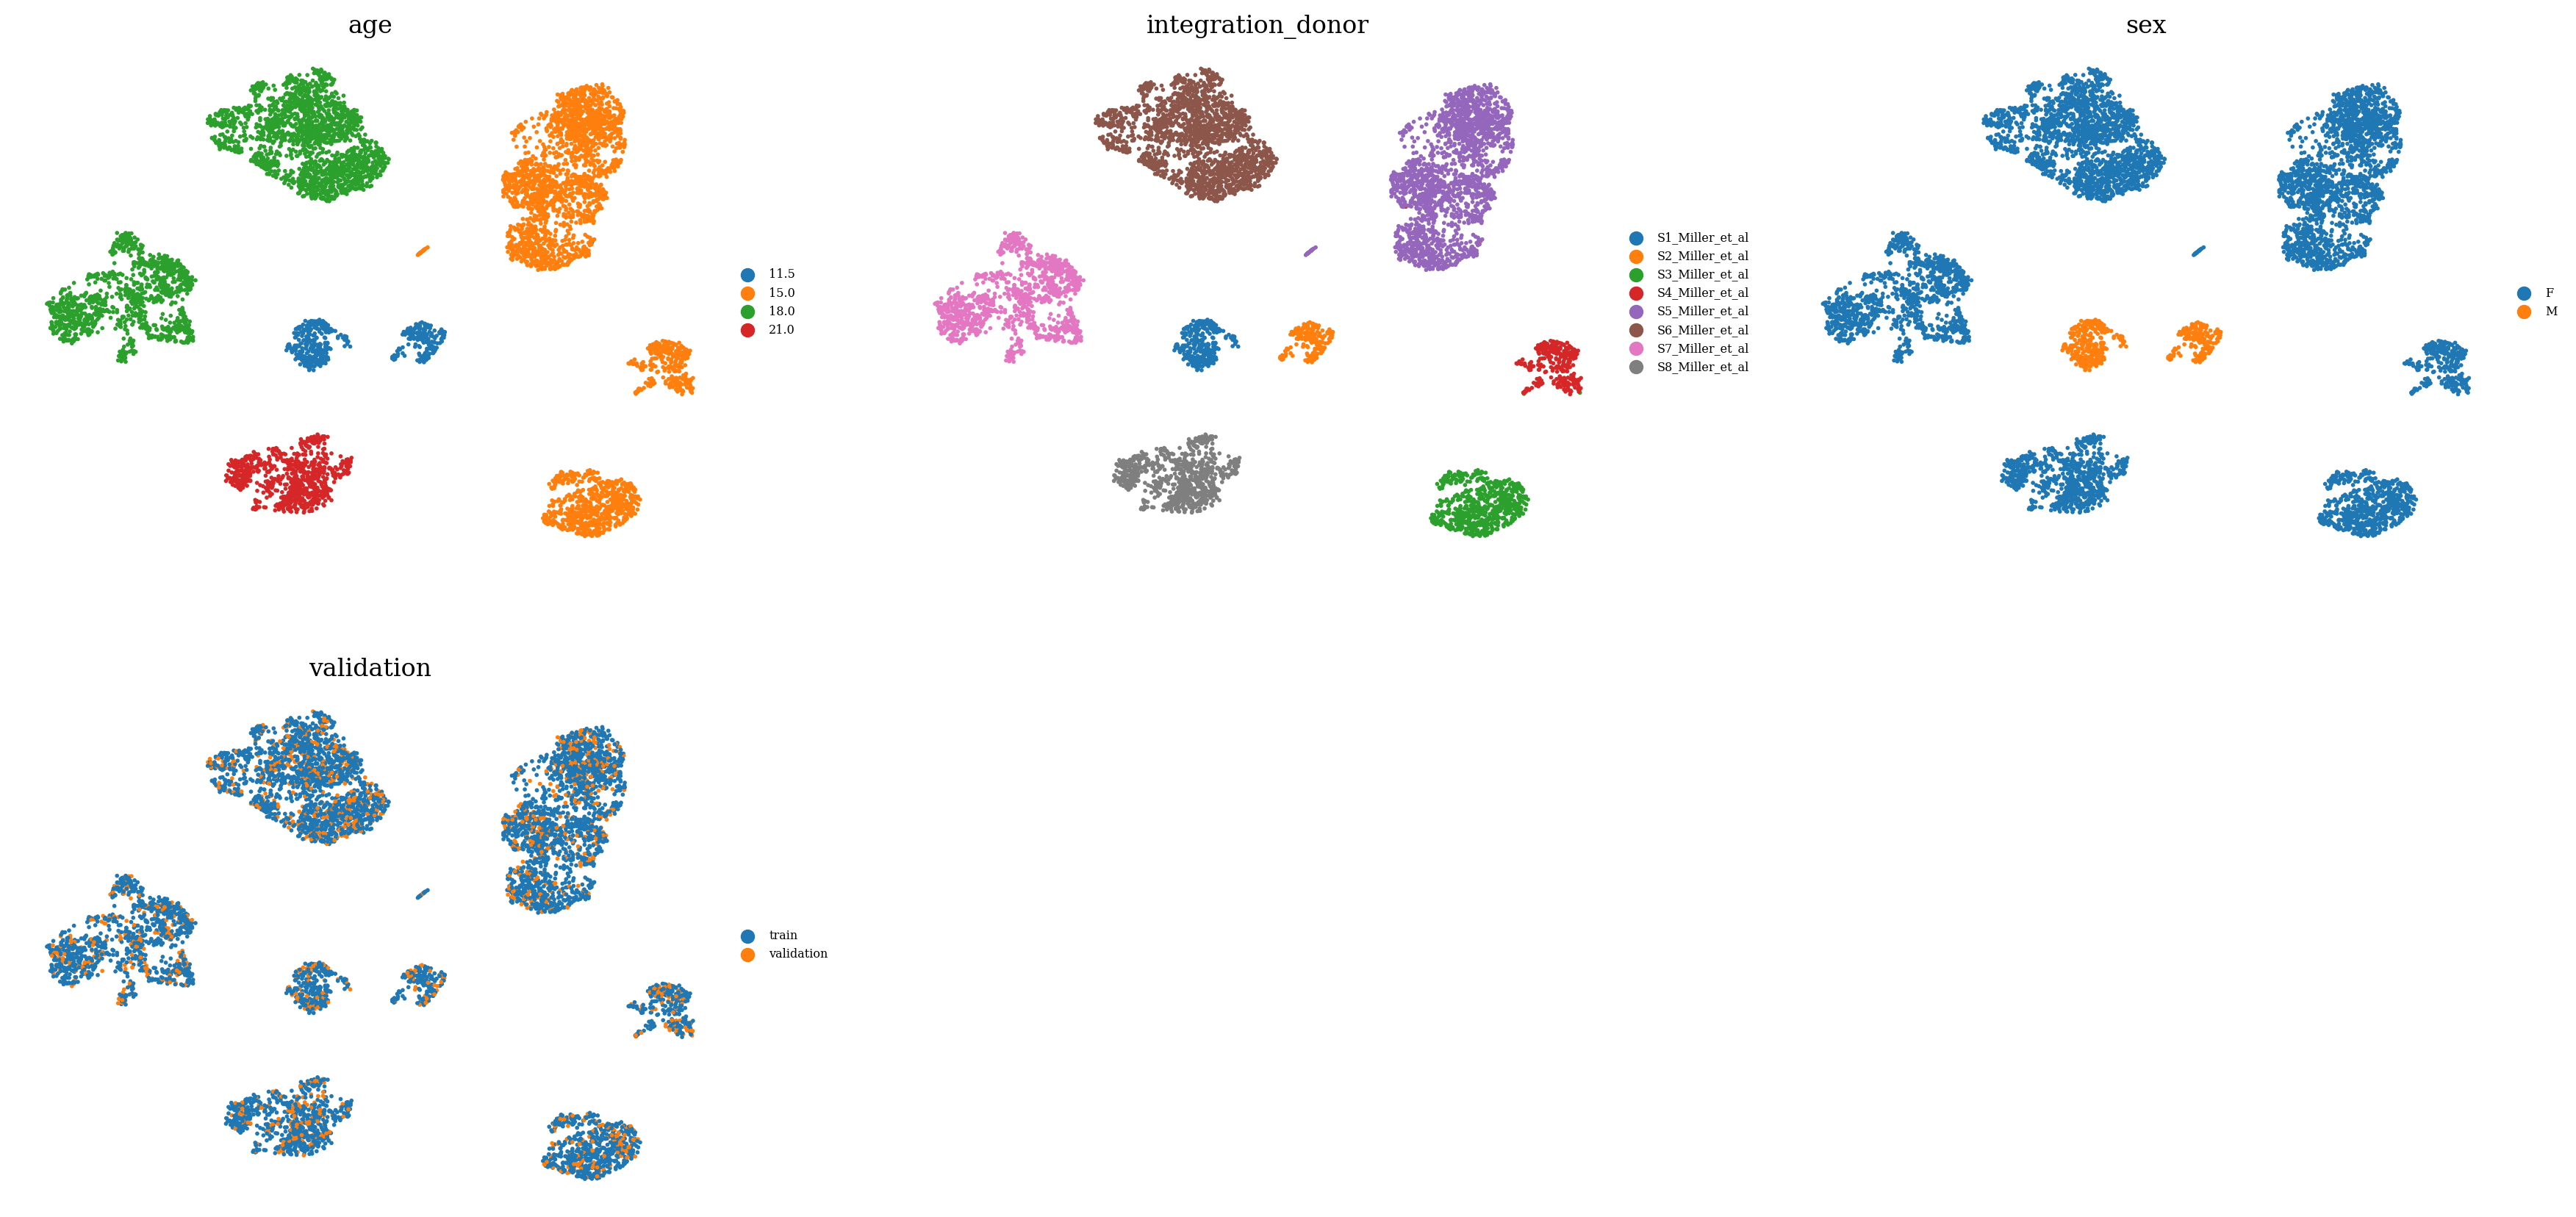

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
from tardis._disentanglementmanager import DisentanglementManager as DM

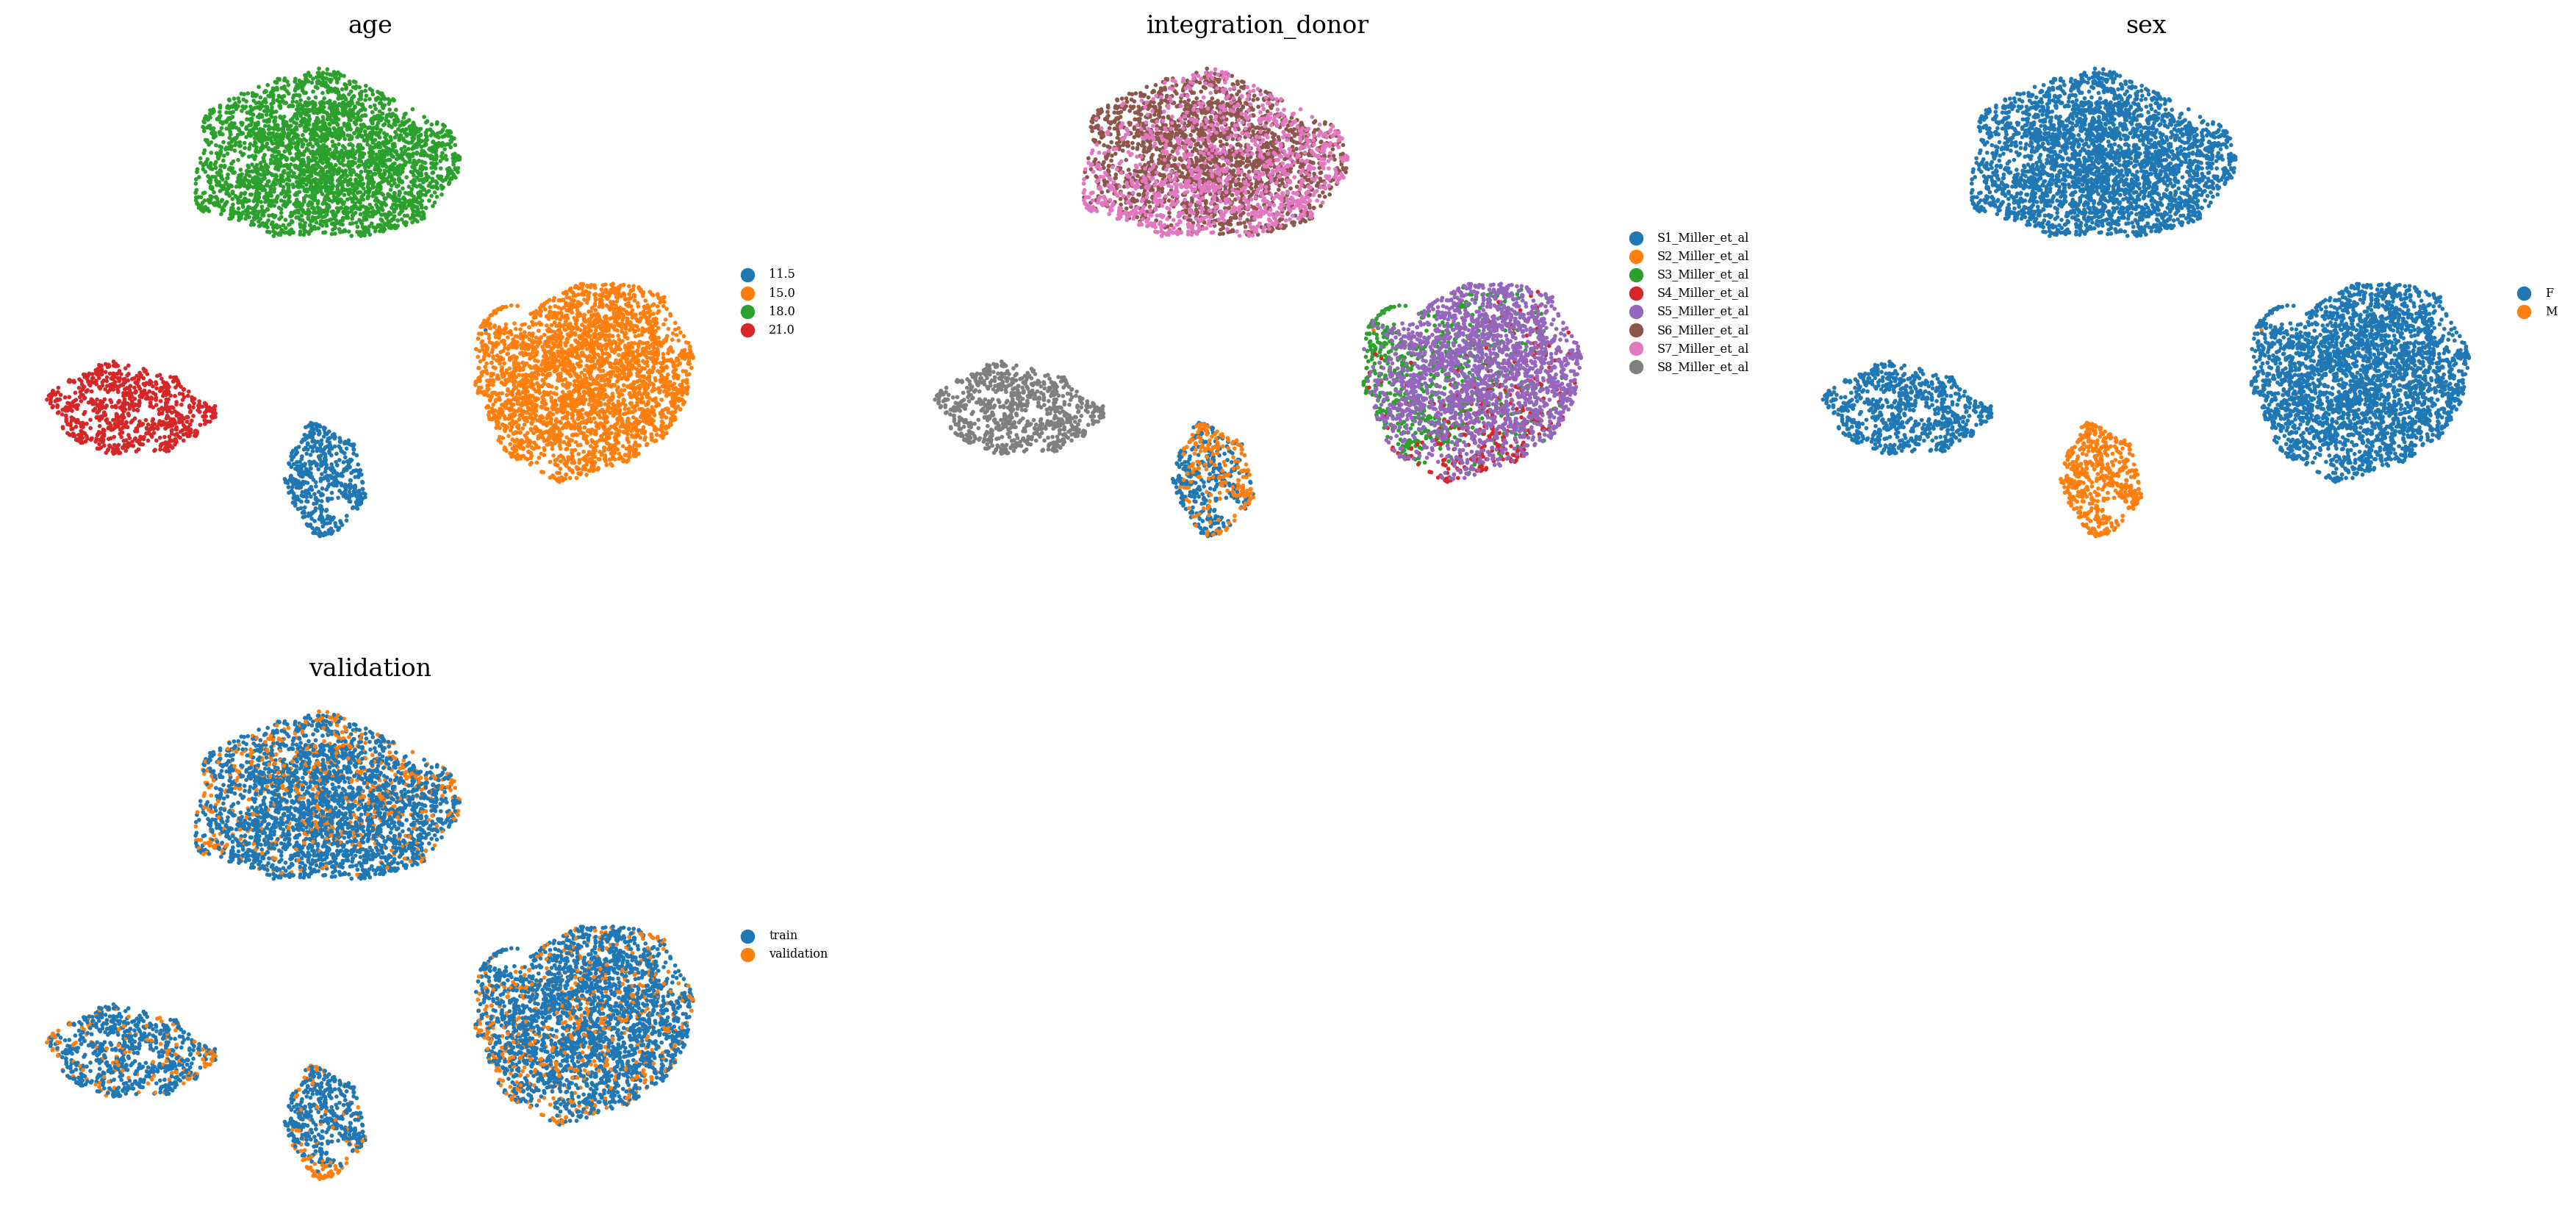

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

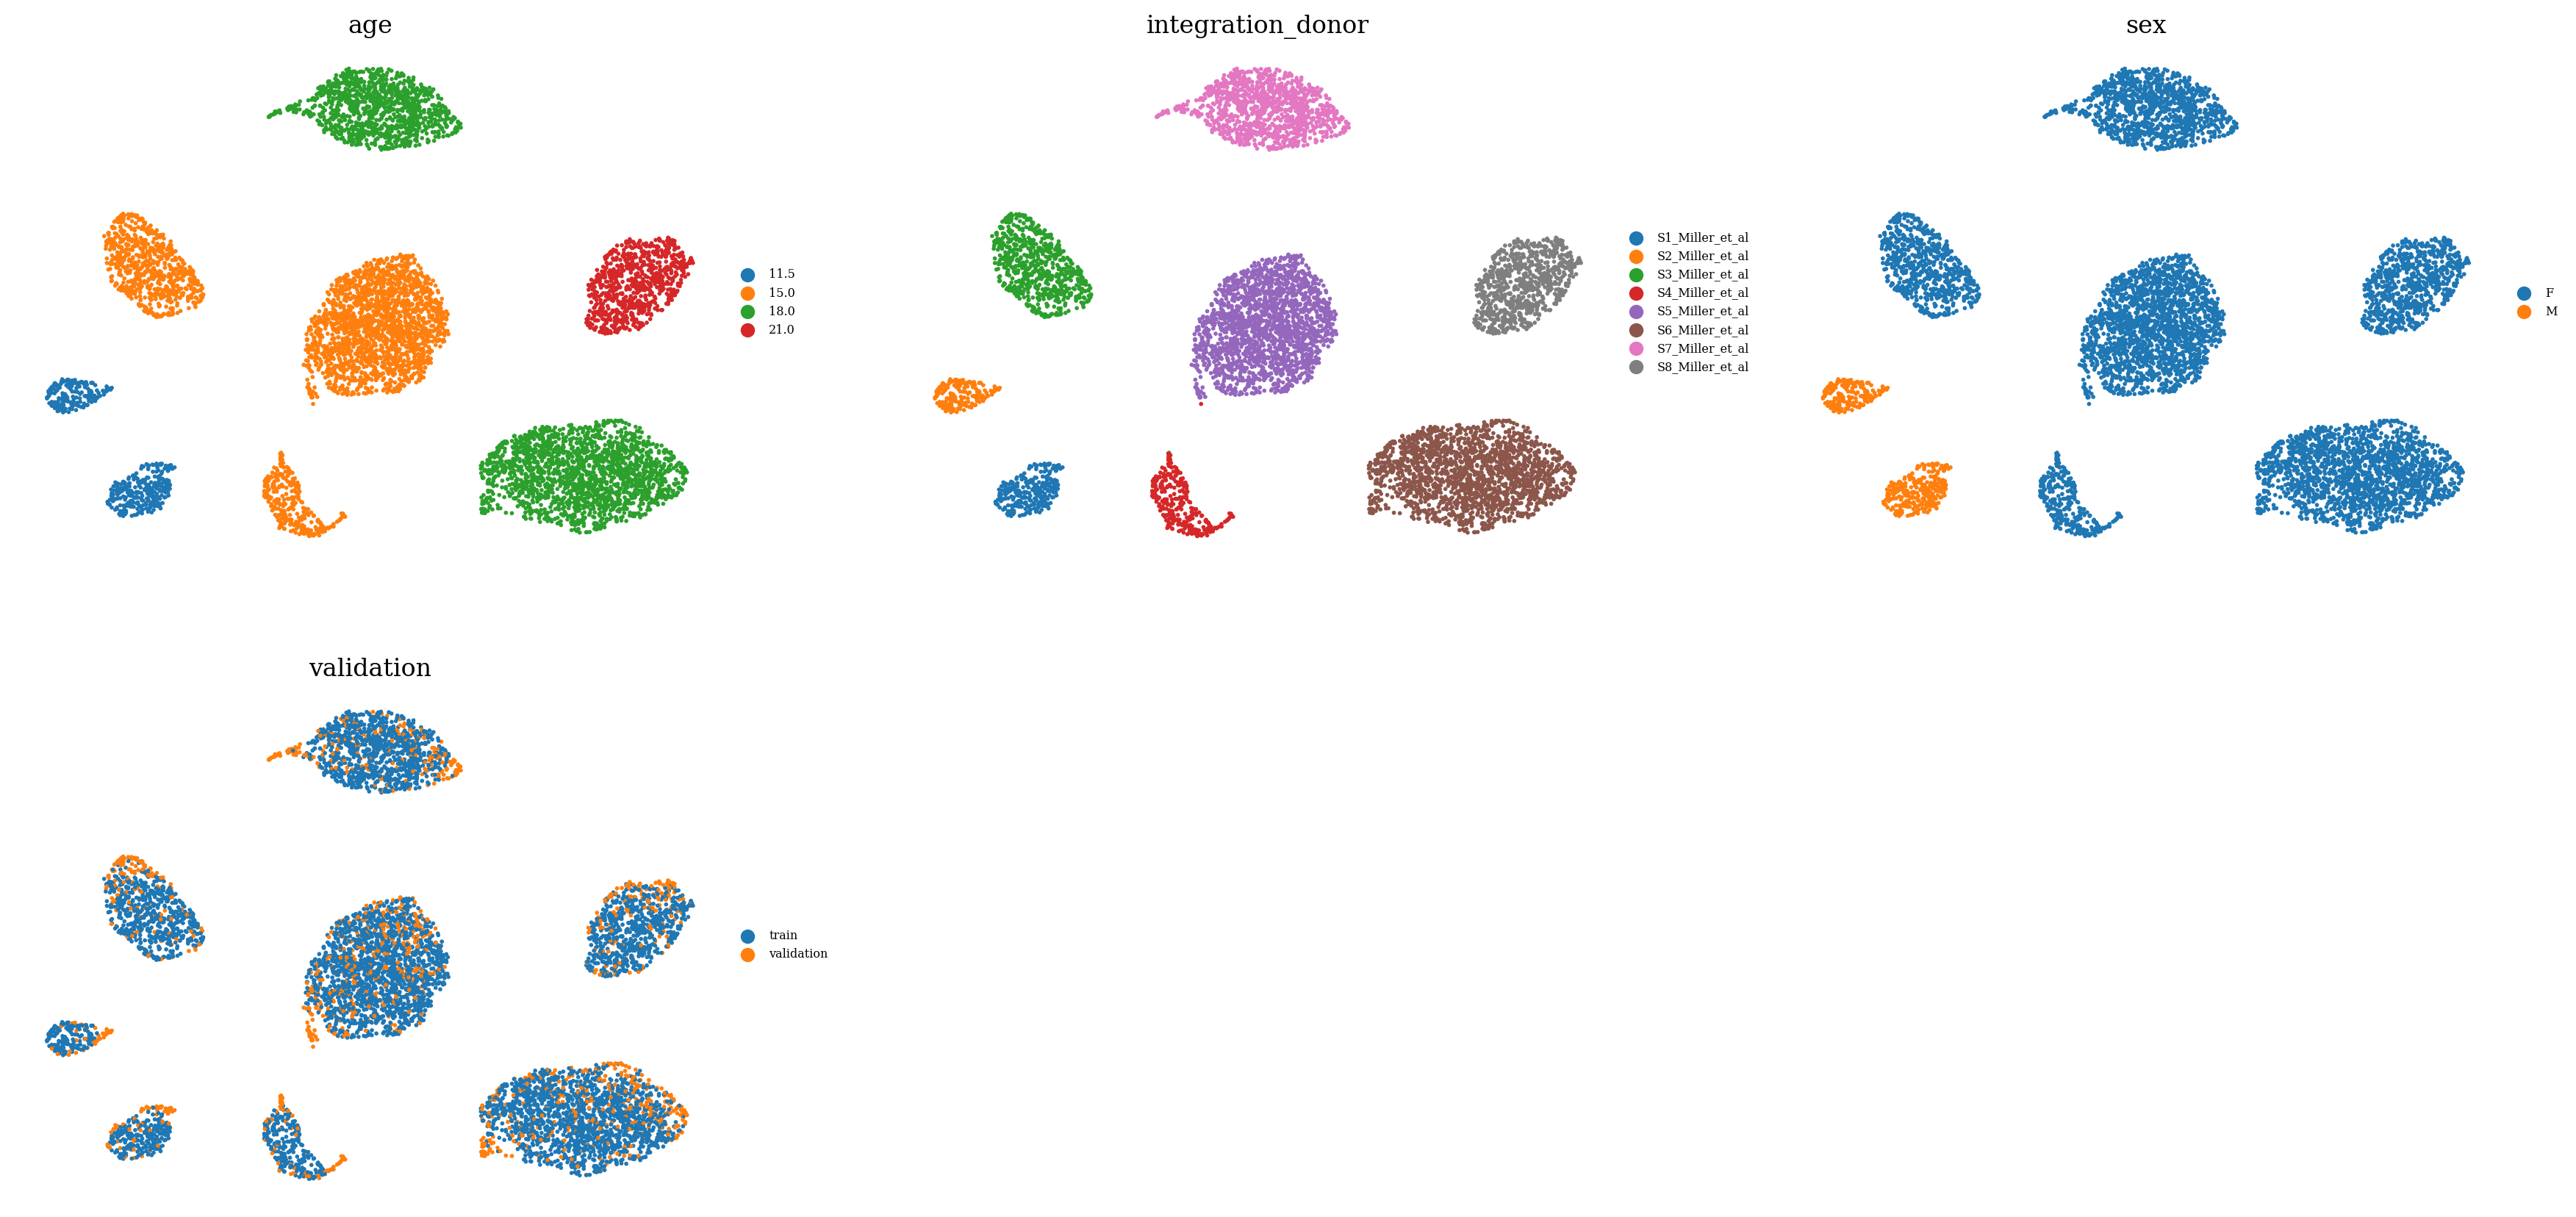

In [28]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["age_continuous"] = adata_main.obs["age"].astype(float)
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["age"].astype(float).unique()))}
adata_main.obs["age_training"] = [d[float(i)] for i in adata_main.obs["age"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [30]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


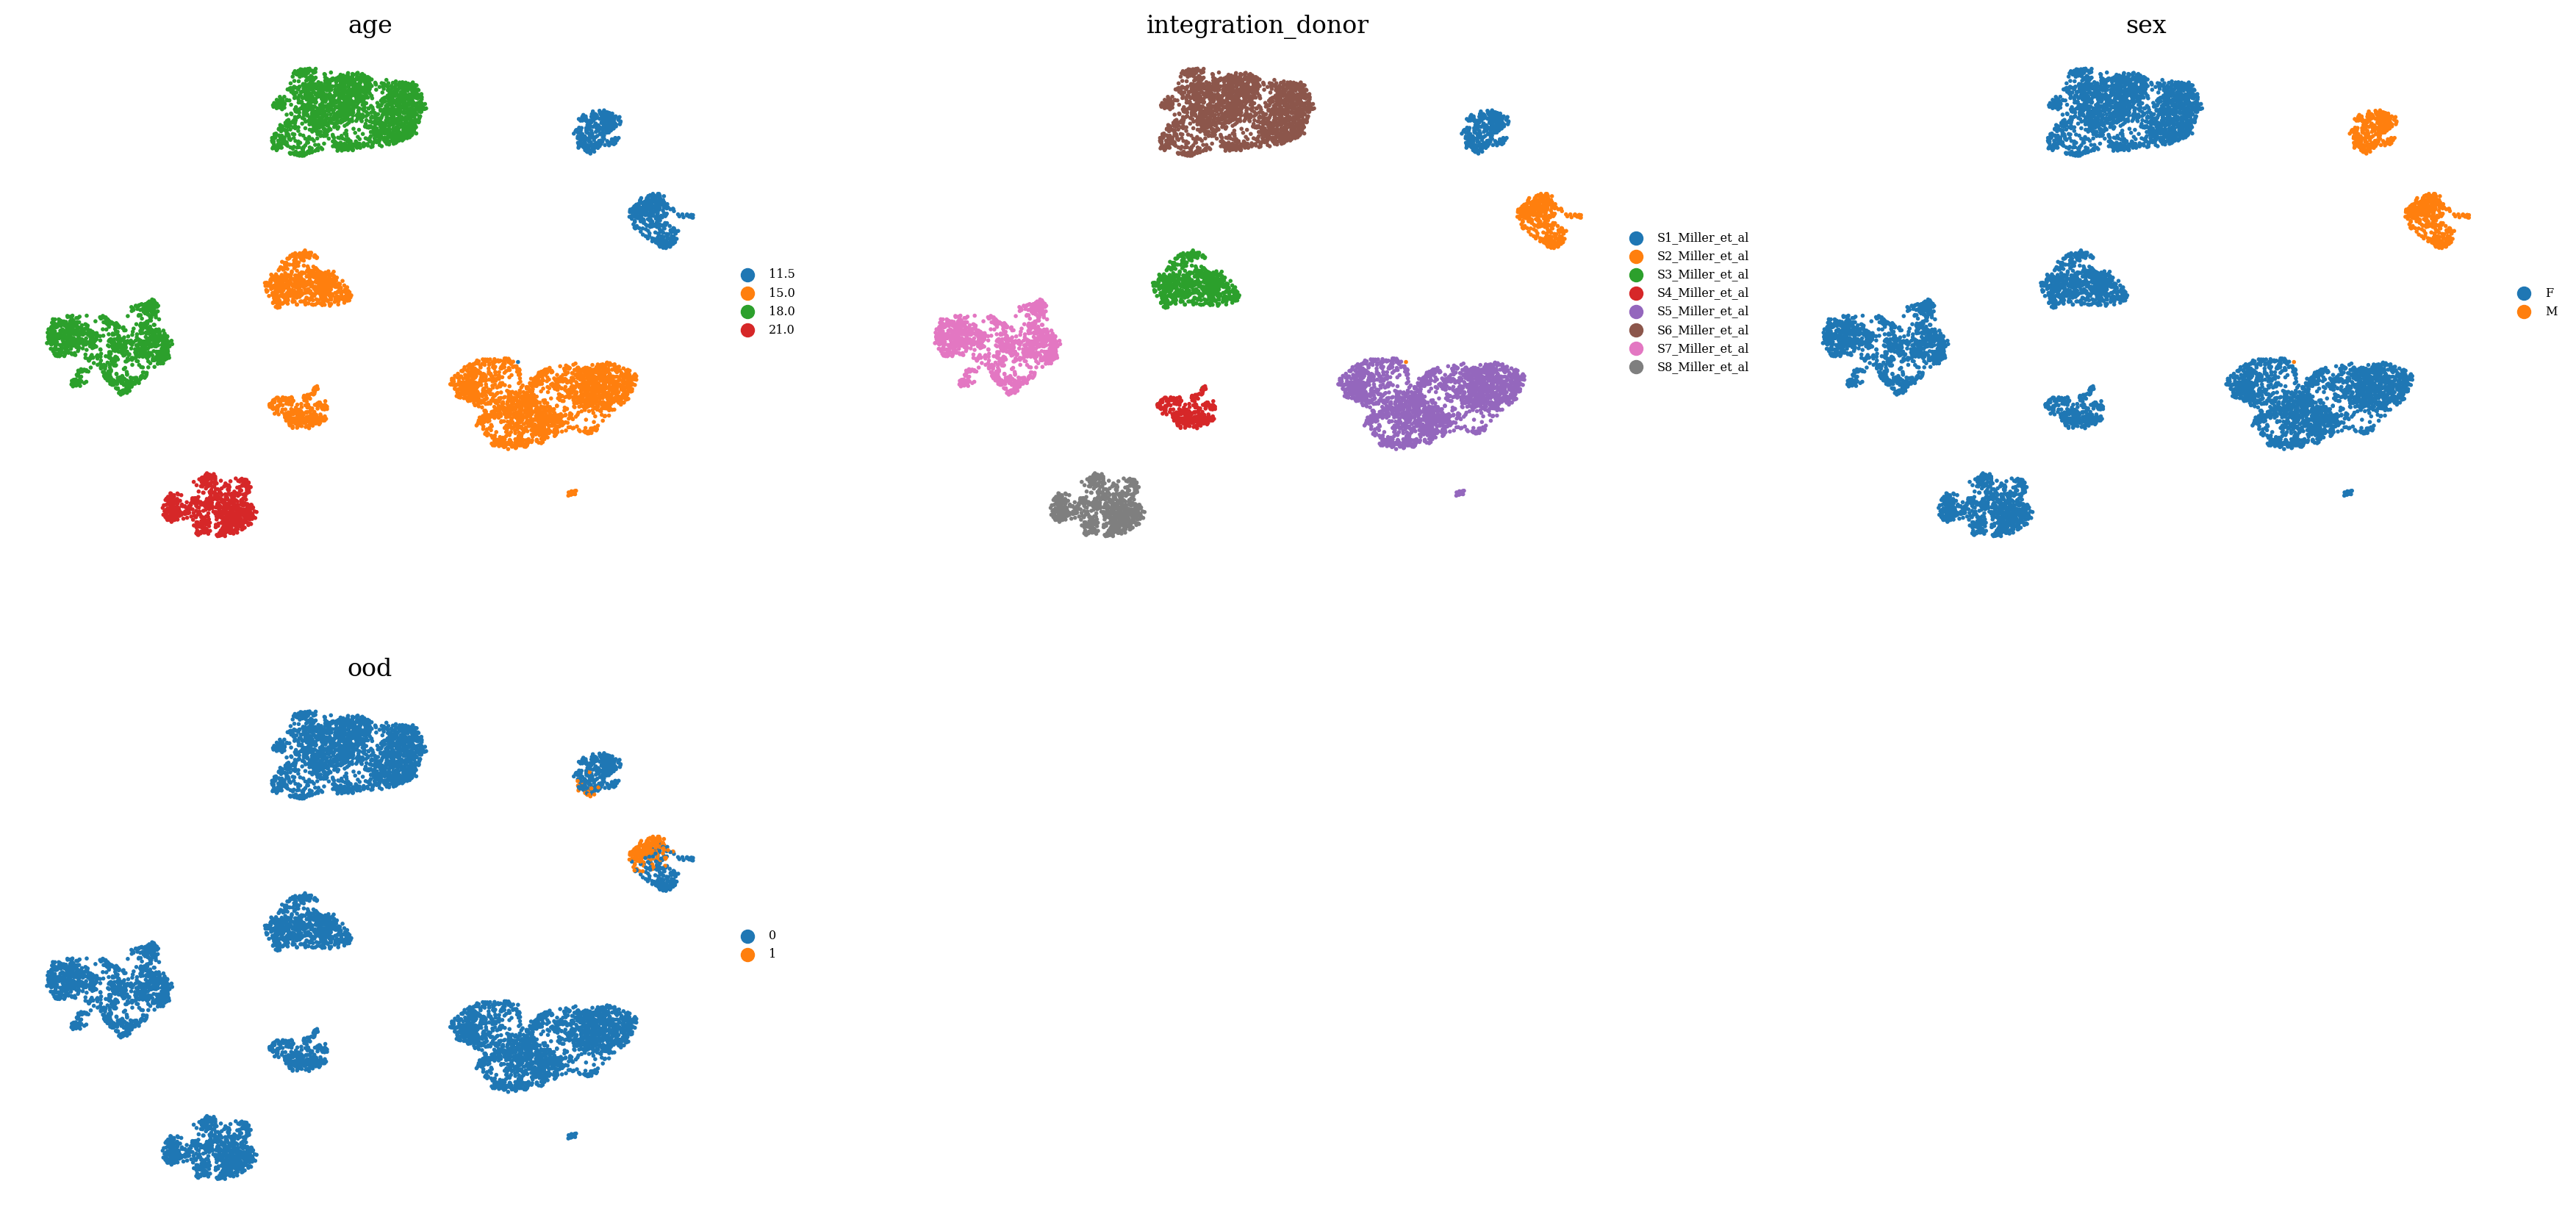

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )